In [1]:
import sys,array
import matplotlib.pyplot as plt
from ROOT import TFile
import root_numpy as rn
import numpy as np
import pandas as pd
import math
from matplotlib.colors import LogNorm
import matplotlib

%matplotlib inline
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'bold'

In [2]:
intime_to_mc = 40.3628

intime_to_onbeam = 18.6927
mc_to_onbeam = 0.463117
off_to_on = 1.19153

In [3]:
#MC BNB + Cosmics 
fmcc8 ='CCpi0hist_dataMCComp_v4_flashtreev0_stats.root'
a = rn.root2array(fmcc8,treename='tree')
df = pd.DataFrame(a)

df['calc_len'] = np.sqrt(pow(df.start_x - df.end_x,2) + pow(df.start_y - df.end_y,2) + \
                         pow(df.start_z - df.end_z,2) )
df['len_diff'] = df['len'] - df['calc_len']

# Add in distances to wall as well for easy fv study
df['dist_to_wall_x'] = np.where(256.35 - df.reco_vtx_x < df.reco_vtx_x, 256.35 - df.reco_vtx_x, df.reco_vtx_x) 
df['dist_to_wall_y'] = 116.5 - abs(df.reco_vtx_y)
df['dist_to_wall_z'] = np.where(1036.8 - df.reco_vtx_z < df.reco_vtx_z, 1036.8 - df.reco_vtx_z, df.reco_vtx_z) 

df['x_quad'] = np.where(df['reco_vtx_x'] < 128.175, 0,1)
df['y_quad'] = np.where(df['reco_vtx_y'] < 0, 0,1)
df['z_quad'] = np.where(df['reco_vtx_z'] < 518.4, 0,1)

df['quad'] = df['x_quad']

df.ix[(df.x_quad==0) & (df.y_quad==1) & (df.z_quad==0),'quad'] = 0
df.ix[(df.x_quad==0) & (df.y_quad==1) & (df.z_quad==1),'quad'] = 1
df.ix[(df.x_quad==1) & (df.y_quad==1) & (df.z_quad==0),'quad'] = 2
df.ix[(df.x_quad==1) & (df.y_quad==1) & (df.z_quad==1),'quad'] = 3
df.ix[(df.x_quad==0) & (df.y_quad==0) & (df.z_quad==0),'quad'] = 4
df.ix[(df.x_quad==0) & (df.y_quad==0) & (df.z_quad==1),'quad'] = 5
df.ix[(df.x_quad==1) & (df.y_quad==0) & (df.z_quad==0),'quad'] = 6
df.ix[(df.x_quad==1) & (df.y_quad==0) & (df.z_quad==1),'quad'] = 7

#print df['quad']
# df['quad'] = np.where(df['x_quad'] == 1 and df['y_quad'] == 1 and df['z_quad'] == 1, 3)

In [4]:
df_beam_mult1 = df.query('(mult == 1 ) and sample == 0')
df_offbeam_mult1 = df.query('(mult == 1) and sample == 1')
df_bnbcos_mult1 = df.query('(mult == 1 ) and sample == 2')
df_intime_mult1 = df.query('(mult == 1 ) and sample == 3')

df_beam_multgt1 = df.query('mult > 1 and sample == 0')
df_offbeam_multgt1 = df.query('mult > 1 and sample == 1')
df_bnbcos_multgt1 = df.query('mult > 1 and sample == 2')
df_intime_multgt1 = df.query('mult > 1 and sample == 3')

df_beam_mult2 = df.query('mult == 2 and sample == 0')
df_offbeam_mult2 = df.query('mult == 2 and sample == 1')
df_bnbcos_mult2 = df.query('mult == 2 and sample == 2')
df_intime_mult2 = df.query('mult == 2 and sample == 3')

In [5]:
# Cuts to explore: 
# -Flash PE cut
# -FV

# -same 2d plots at different places in detector (start 1d though):
#  - length vs vtx diff for all quadrants 

#print df.head()

#plt.hist(df_offbeam_mult2.len.values,bins=100)

In [6]:
# Easy function to test cuts in 8 regions of det
def getRegions(df_on_i,df_off_i,df_mc_i,name='',flash_cut=50,fv_x=20.,fv_y=20.,fv_z=10.):
       
    store_it = 0
    for fl in xrange(50,800,50):
        df00 = df_on_i.query('flash_npe > %i and dist_to_wall_x > %f and dist_to_wall_y > %f \
                        and dist_to_wall_z > %f' % (fl,fv_x,fv_y,fv_z) )
        df10 = df_off_i.query('flash_npe > %i and dist_to_wall_x > %f and dist_to_wall_y > %f \
                        and dist_to_wall_z > %f' % (fl,fv_x,fv_y,fv_z) )    
        df20 = df_mc_i.query('flash_npe > %i and dist_to_wall_x > %f and dist_to_wall_y > %f \
                        and dist_to_wall_z > %f' % (fl,fv_x,fv_y,fv_z) )    
    
        display_dim = 3
        plt.figure(figsize=(35,15))
    
        #8 Regions of the detector
        for it in xrange(8):
         
            df0 = df00.query('quad == %i'%it)
            df1 = df10.query('quad == %i'%it)
            df2 = df20.query('quad == %i'%it)
                      
            nbins = 40
            x_on, y_on = np.histogram(df0.len.values,bins=nbins,range=(0,500))
            x_off, y_off = np.histogram(df1.len.values,bins=nbins,range=(0,500))
            x_bnb, y_bnb = np.histogram(df2.len.values,bins=nbins,range=(0,500))
            bins = (y_bnb[:-1] + y_bnb[1:])/2
                        
            y_bnbcos = [ x_bnb[i]*mc_to_onbeam for i in xrange(len(x_bnb)) ]
            y_off_min_on = [x_on[i] - x_off[i]*off_to_on for i in xrange(len(x_on))]

            err_x = 0.5 * (bins[1] - bins[0])
            err_y = [ math.sqrt(y_bnbcos[i]) for i in xrange(len(y_bnbcos))]
            err_on_y = [ math.sqrt(y_off_min_on[i]) if y_off_min_on[i] >= 0 else 0 for i in xrange(len(y_off_min_on))]
            
            plt.subplot(display_dim-1,display_dim+1,it+1)
            plt.plot(bins,y_bnbcos,'-',color='k',label="BNBCos",marker='.')
            plt.plot(bins,y_off_min_on,'-',color='r',label="OnBeam",marker='.')
            #plt.errorbar(bins,y_bnbcos,yerr=err_y,xerr=err_x,fmt='o',color='k',lw=3,label='BNBCos')
            #plt.errorbar(bins,y_off_min_on,yerr=err_on_y,xerr=err_x,fmt='o',color='r',lw=3,label='OnBeam')
            plt.xlabel("Length [cm]",fontsize=22,weight='bold')
            plt.ylabel("Counts",fontsize=22,weight='bold')
            plt.legend(title="Quadrant %i, %s"%(it,name))
            plt.grid(True)
            #plt.xlim(0,1000)
            plt.ylim(0,60)
        
        plt.suptitle('Flash Cut %i'%(fl),fontsize=30,weight='bold')
        plt.savefig('FLASHES/len_%s_image%04i.png'%(name,store_it))
        plt.show()
        
        plt.figure(figsize=(35,15))
     
        for it in xrange(8):
         
            df0 = df00.query('quad == %i'%it)
            df1 = df10.query('quad == %i'%it)
            df2 = df20.query('quad == %i'%it)
        
            nbins = 100
            x_on, y_on = np.histogram(df0.vtx_diff.values,bins=nbins,range=(0,100))
            x_off, y_off = np.histogram(df1.vtx_diff.values,bins=nbins,range=(0,100))
            x_bnb, y_bnb = np.histogram(df2.vtx_diff.values,bins=nbins,range=(0,100))
            bins = (y_bnb[:-1] + y_bnb[1:])/2

            y_bnbcos = [ x_bnb[i]*mc_to_onbeam for i in xrange(len(x_bnb)) ]
            y_off_min_on = [x_on[i] - x_off[i]*off_to_on for i in xrange(len(x_on))]

            plt.subplot(display_dim-1,display_dim+1,it+1)
            #plt.title("Quadrant %i"%it,size=18)
            plt.plot(bins,y_bnbcos,'-',color='k',label="BNBCos",marker='.')
            plt.xlabel("Vtx Diff [cm]",fontsize=22,weight='bold')
            plt.ylabel("Counts",fontsize=22,weight='bold')
            plt.legend(title="Quadrant %i, %s"%(it,name))
            plt.grid(True)
            plt.yscale('log')
            plt.ylim(0,150)

        plt.suptitle('Flash Cut %i'%(fl),fontsize=30,weight='bold')
        plt.savefig('FLASHES/vert_%s_image%04i.png'%(name,store_it))
        plt.show()
        store_it += 1
    

In [7]:
# Easy function to test cuts in 8 regions of det
def getFVRegions(df_on_i,df_off_i,df_mc_i,name='',flash_cut=50,fv_x=20.,fv_y=20.,fv_z=10.):
       
    store_it = 0
    fv_x -= 5
    fv_y -= 5
    fv_z -= 5
    for fl in xrange(0,35,5):
        fv_x += 5; fv_y += 5; fv_z += 5
        
        print fv_x, fv_y, fv_z
        
        df00 = df_on_i.query('flash_npe > %i and dist_to_wall_x > %f and dist_to_wall_y > %f \
                        and dist_to_wall_z > %f' % (flash_cut,fv_x,fv_y,fv_z) )
        df10 = df_off_i.query('flash_npe > %i and dist_to_wall_x > %f and dist_to_wall_y > %f \
                        and dist_to_wall_z > %f' % (flash_cut,fv_x,fv_y,fv_z) )    
        df20 = df_mc_i.query('flash_npe > %i and dist_to_wall_x > %f and dist_to_wall_y > %f \
                        and dist_to_wall_z > %f' % (flash_cut,fv_x,fv_y,fv_z) )    
    
        display_dim = 3
        plt.figure(figsize=(35,15))
    
        #8 Regions of the detector
        for it in xrange(8):
         
            df0 = df00.query('quad == %i'%it)
            df1 = df10.query('quad == %i'%it)
            df2 = df20.query('quad == %i'%it)
                      
            nbins = 40
            x_on, y_on = np.histogram(df0.len.values,bins=nbins,range=(0,500))
            x_off, y_off = np.histogram(df1.len.values,bins=nbins,range=(0,500))
            x_bnb, y_bnb = np.histogram(df2.len.values,bins=nbins,range=(0,500))
            bins = (y_bnb[:-1] + y_bnb[1:])/2

            y_bnbcos = [ x_bnb[i]*mc_to_onbeam for i in xrange(len(x_bnb)) ]
            y_off_min_on = [x_on[i] - x_off[i]*off_to_on for i in xrange(len(x_on))]

            plt.subplot(display_dim-1,display_dim+1,it+1)
            plt.plot(bins,y_bnbcos,'-',color='k',label="BNBCos",marker='.')
            plt.plot(bins,y_off_min_on,'-',color='r',label="OnBeam",marker='.')
            #plt.title("Quadrant %i FV (%i,%i,%i)"%(it,fv_x,fv_y,fv_z))#,size=20)
            plt.xlabel("Length [cm]")#,fontsize=18,weight='bold')
            plt.ylabel("Counts")#,fontsize=18,weight='bold')
            plt.legend(title="Quadrant %i, %s"%(it,name))
            plt.grid(True)
            plt.ylim(0,60)
        
        plt.suptitle('FV Cut FV (%i,%i,%i)'%(fv_x,fv_y,fv_z),fontsize=30,weight='bold')
        plt.savefig('FV/lenFV_%simage%04i.png'%(name,store_it))
        plt.show()
        
        plt.figure(figsize=(35,15))
     
        for it in xrange(8):
         
            df0 = df00.query('quad == %i'%it)
            df1 = df10.query('quad == %i'%it)
            df2 = df20.query('quad == %i'%it)
        
            nbins = 100
            x_on, y_on = np.histogram(df0.vtx_diff.values,bins=nbins,range=(0,100))
            x_off, y_off = np.histogram(df1.vtx_diff.values,bins=nbins,range=(0,100))
            x_bnb, y_bnb = np.histogram(df2.vtx_diff.values,bins=nbins,range=(0,100))
            bins = (y_bnb[:-1] + y_bnb[1:])/2

            y_bnbcos = [ x_bnb[i]*mc_to_onbeam for i in xrange(len(x_bnb)) ]
            y_off_min_on = [x_on[i] - x_off[i]*off_to_on for i in xrange(len(x_on))]

            plt.subplot(display_dim-1,display_dim+1,it+1)
            plt.title("Quadrant %i FV (%i,%i,%i)"%(it,fv_x,fv_y,fv_z))#,size=20)
            plt.plot(bins,y_bnbcos,'-',color='k',label="BNBCos",marker='.')
            plt.xlabel("Vtx Diff [cm]",fontsize=22,weight='bold')
            plt.ylabel("Counts",fontsize=22,weight='bold')
            plt.legend(title="Quadrant %i, %s"%(it,name))
            plt.grid(True)
            plt.yscale('log')
            plt.ylim(0,150)
        plt.suptitle('FV Cut FV (%i,%i,%i)'%(fv_x,fv_y,fv_z),fontsize=30,weight='bold')
        plt.savefig('FV/vertFV_%simage%04i.png'%(name,store_it))
        plt.show()
        store_it += 1
    

In [ ]:
getRegions(df_beam_mult2, df_offbeam_mult2, df_bnbcos_mult2,name='mult2')

20.0 20.0 10.0


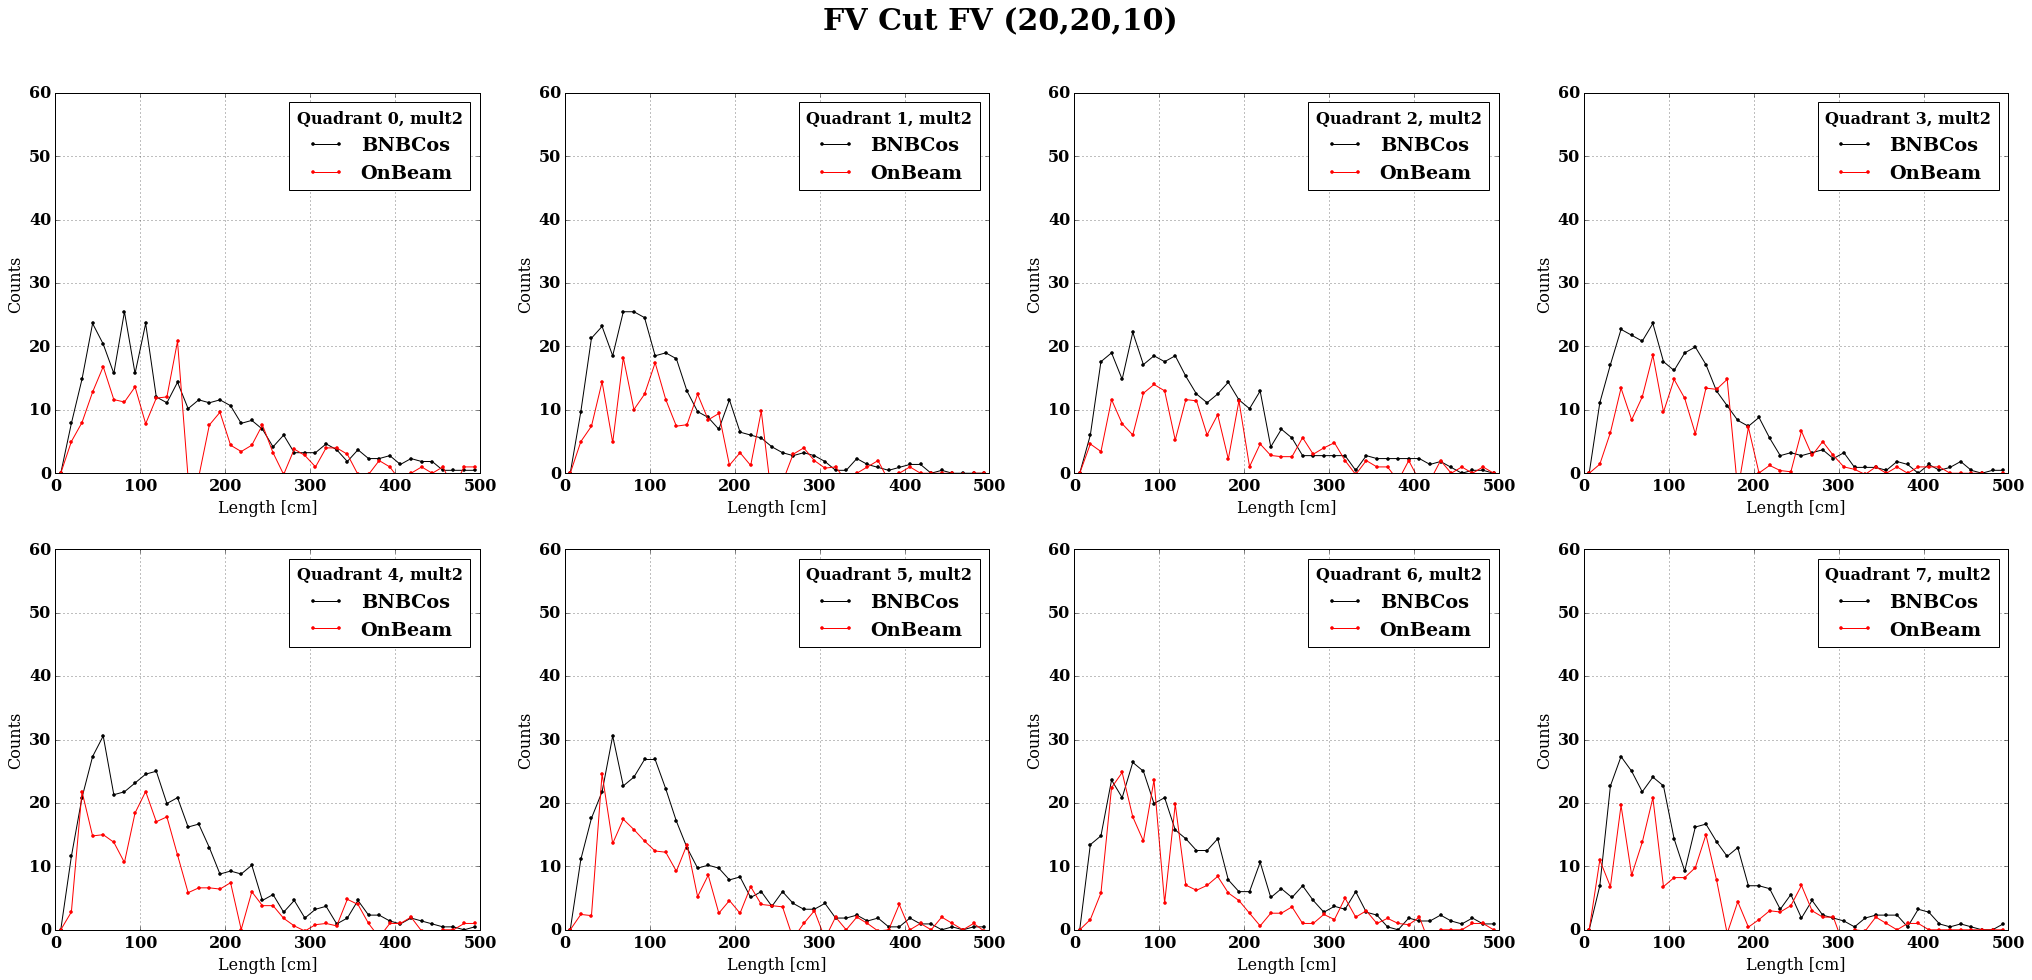

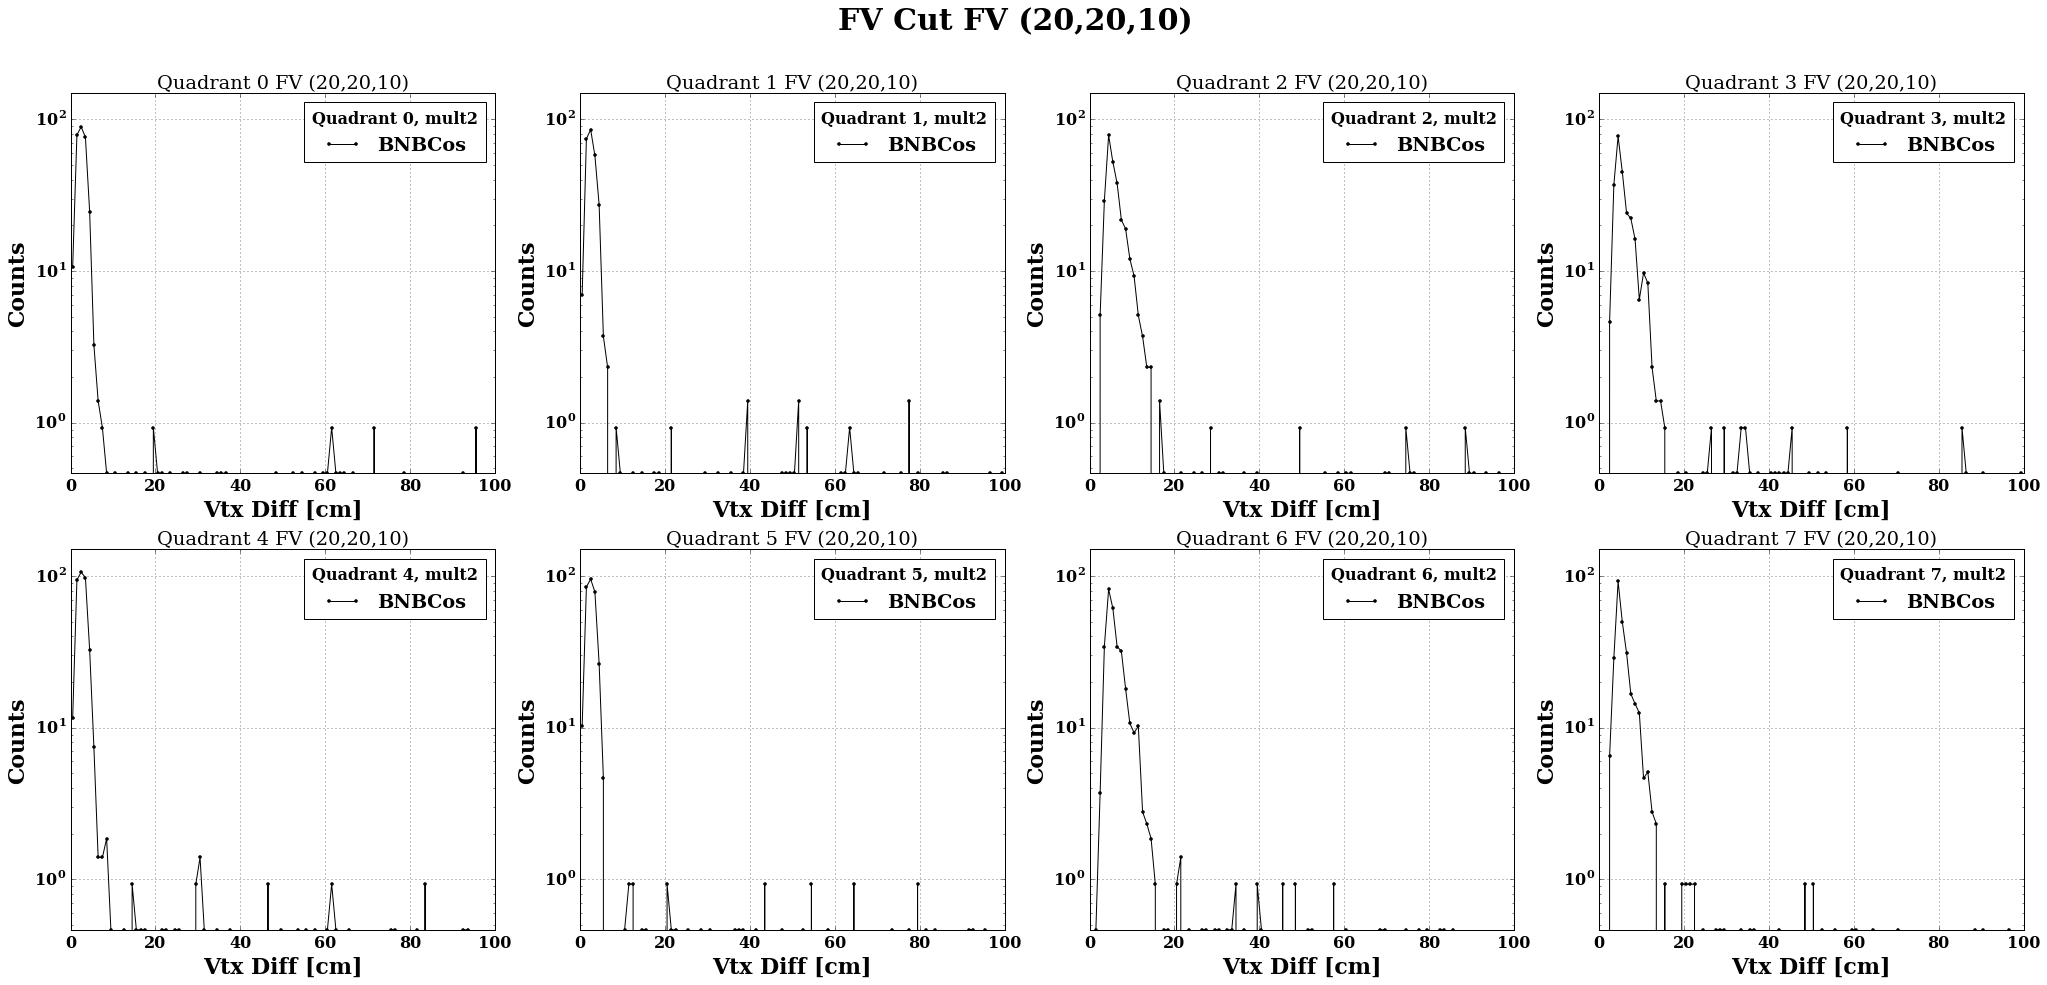

25.0 25.0 15.0


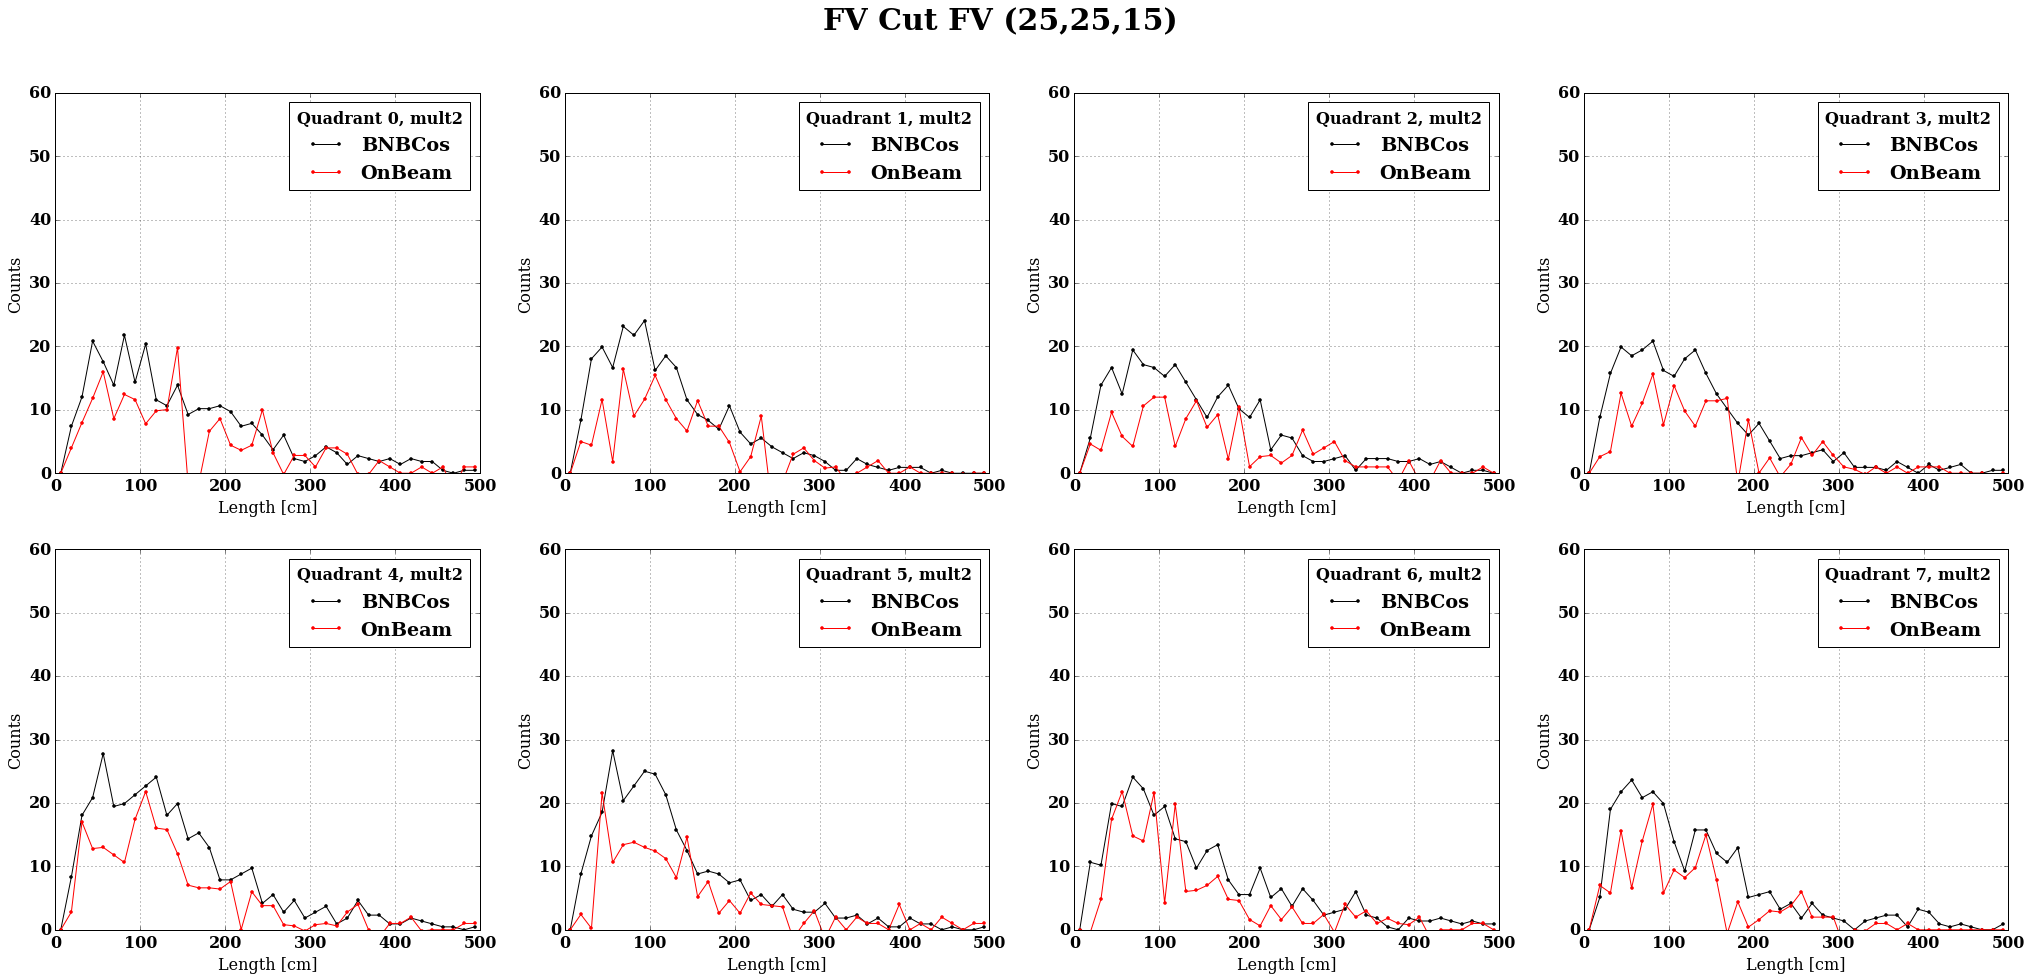

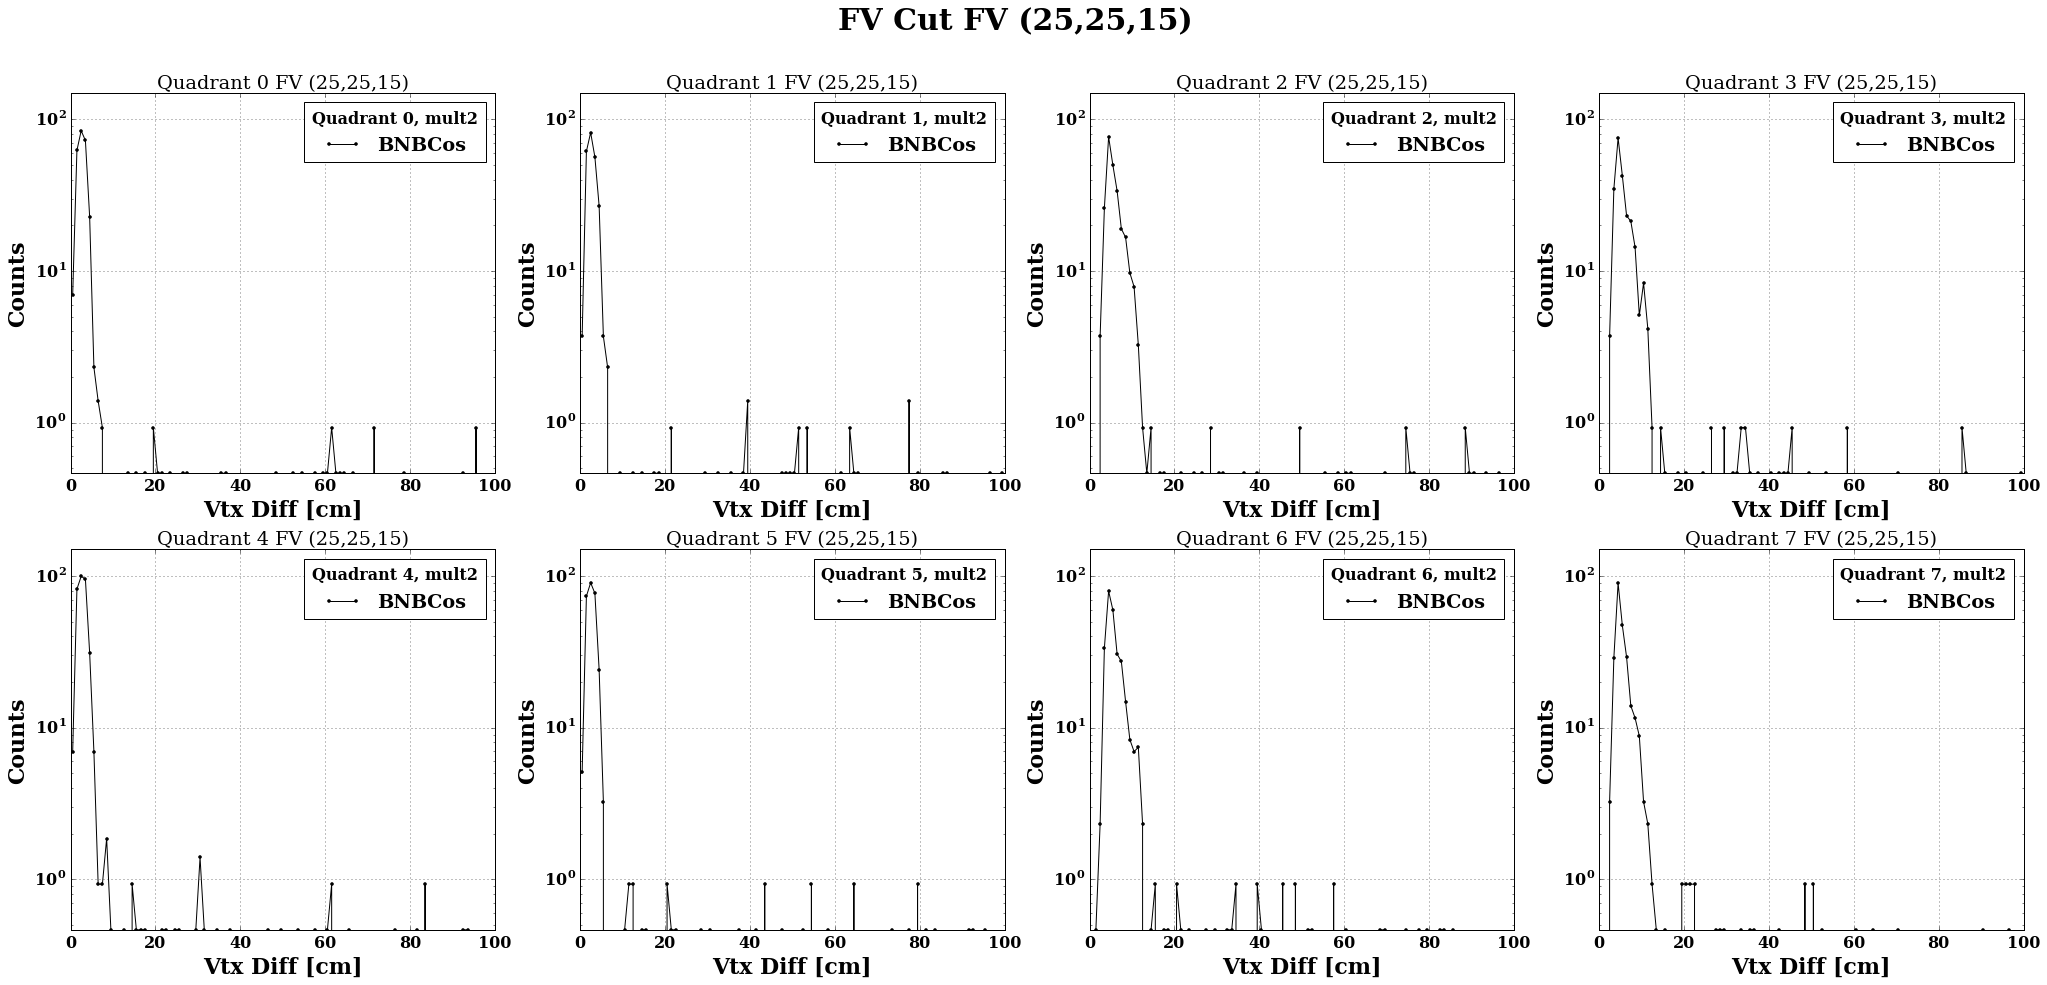

30.0 30.0 20.0


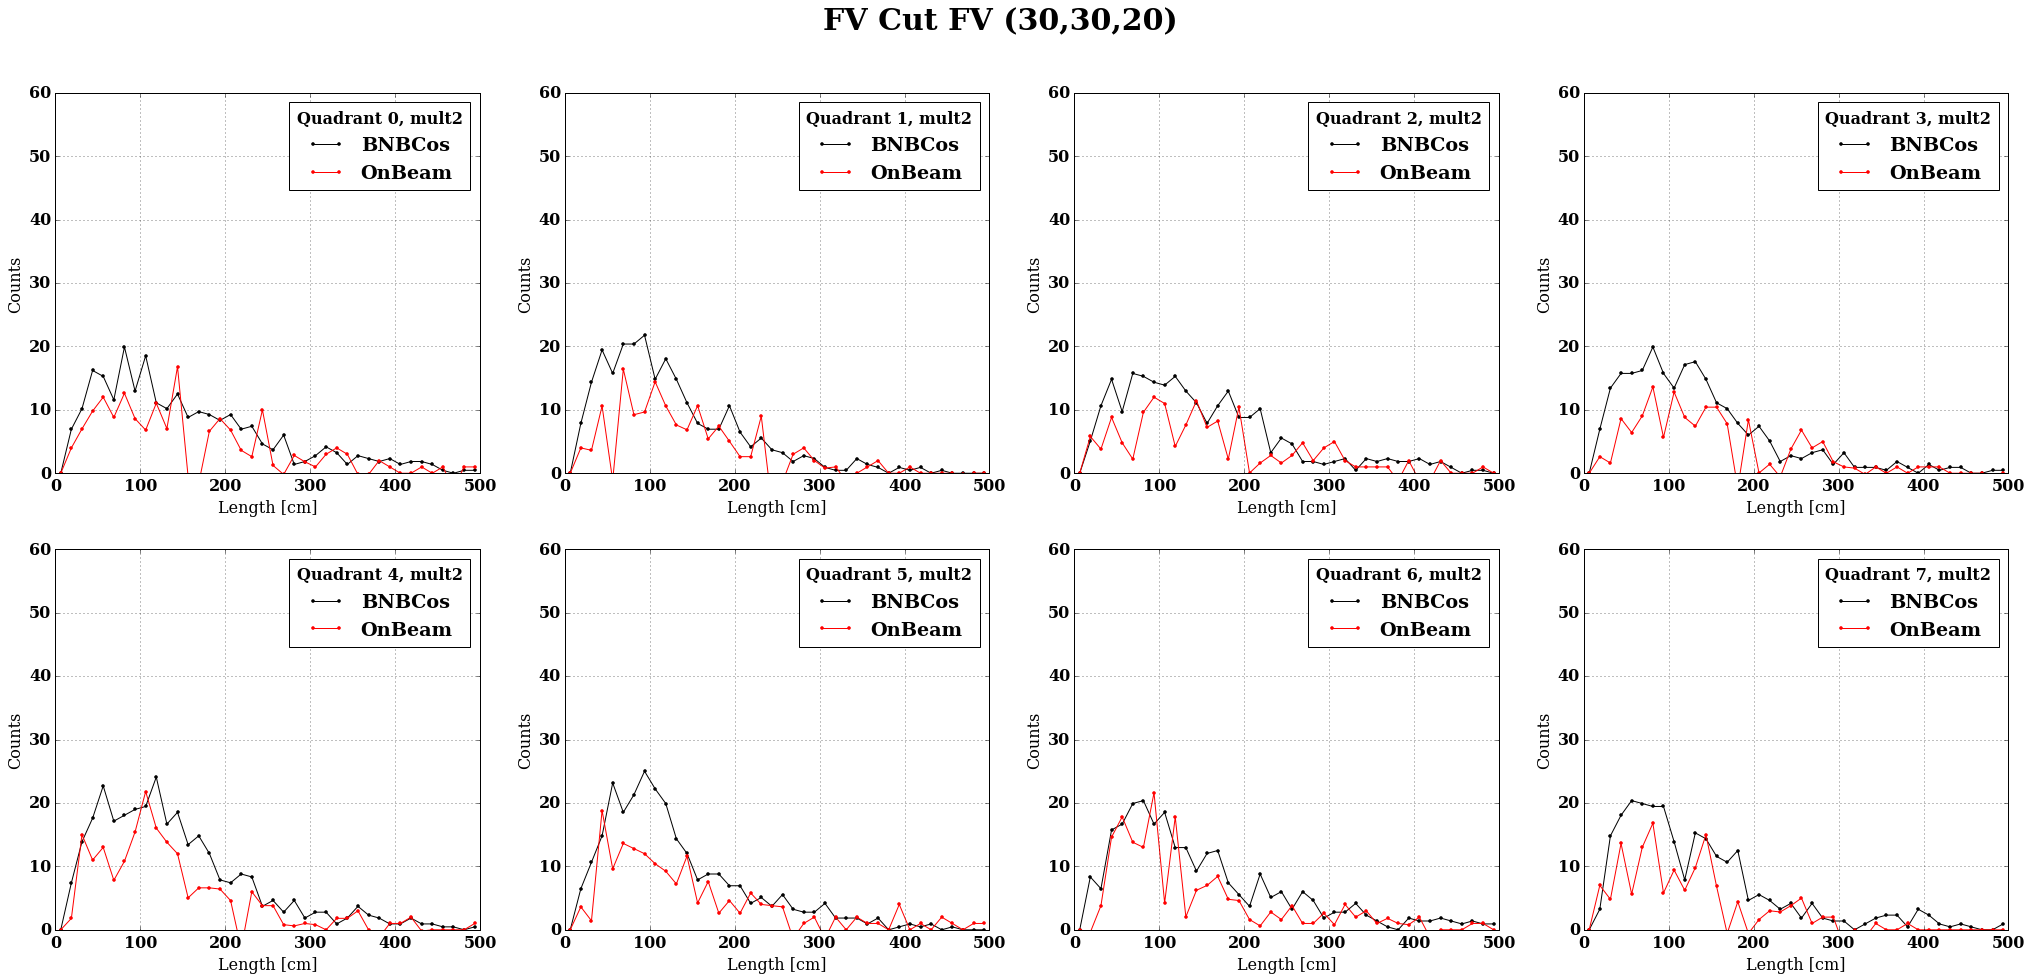

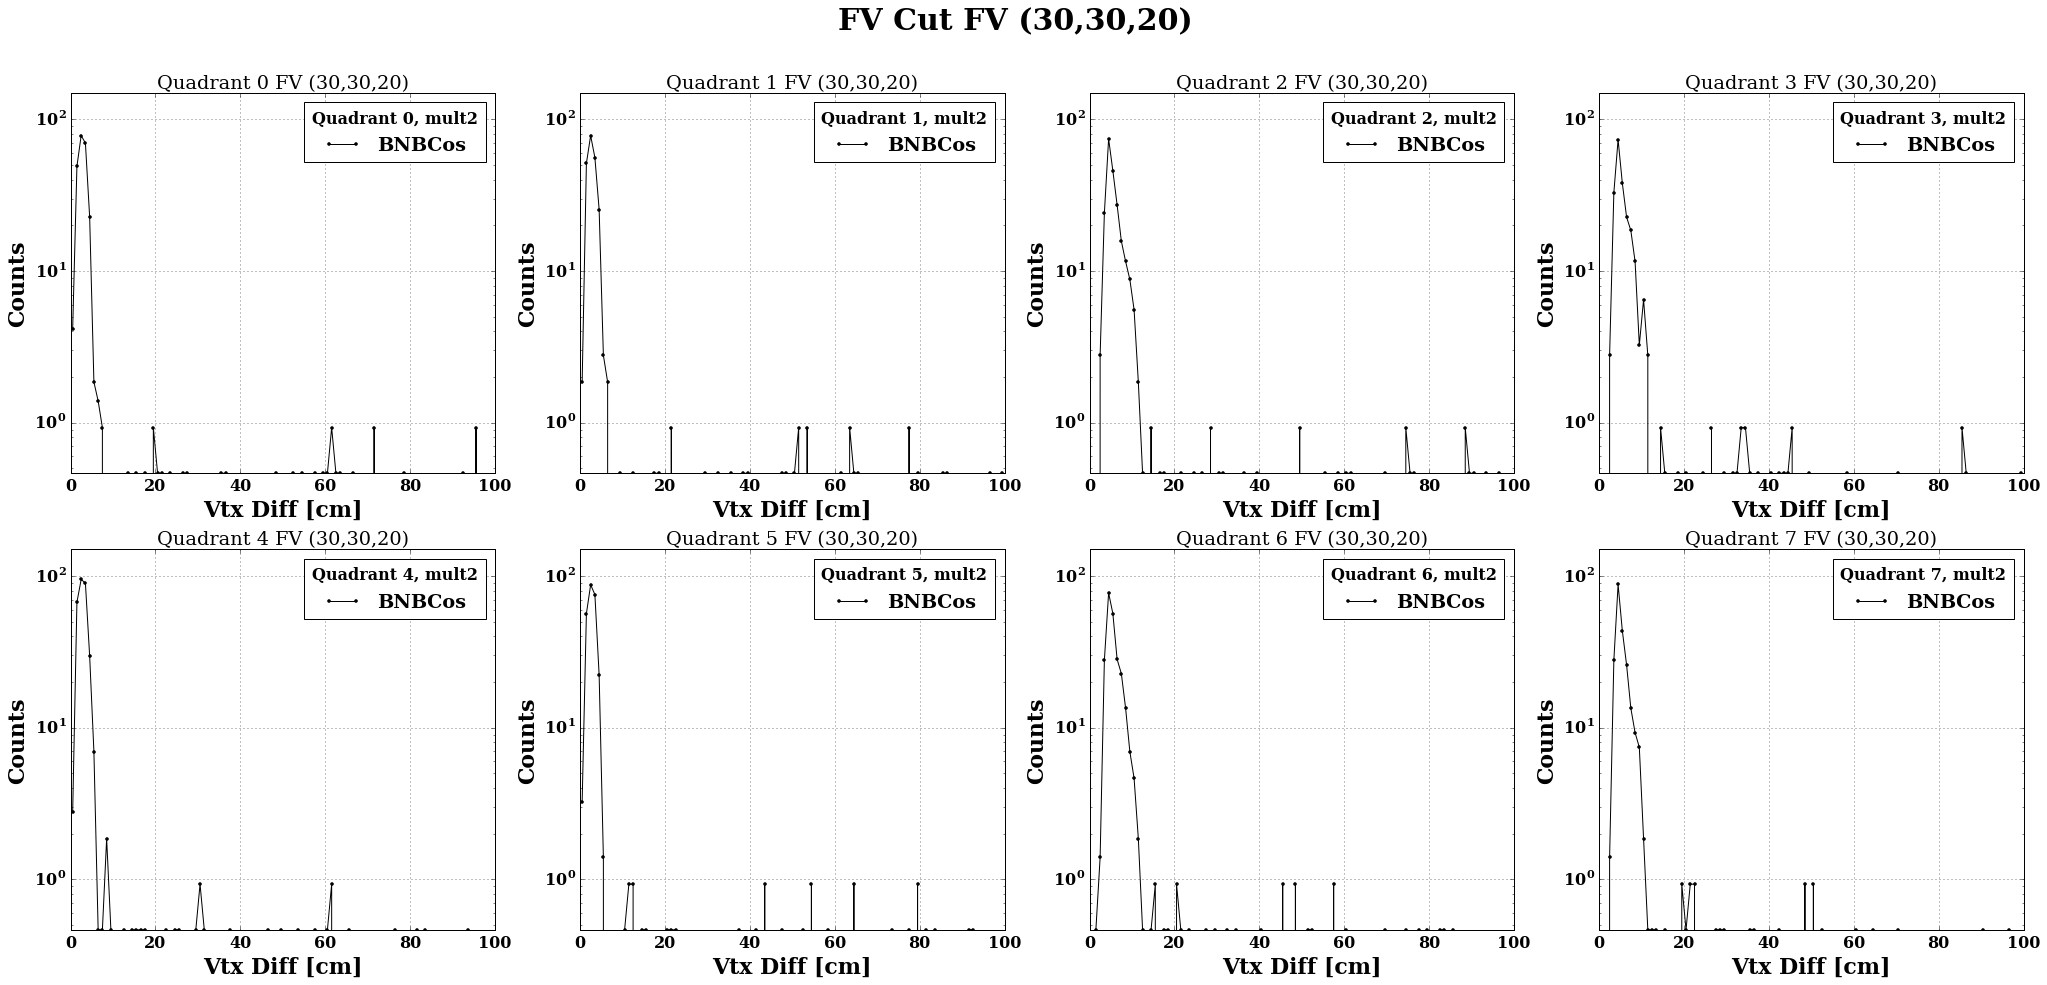

35.0 35.0 25.0


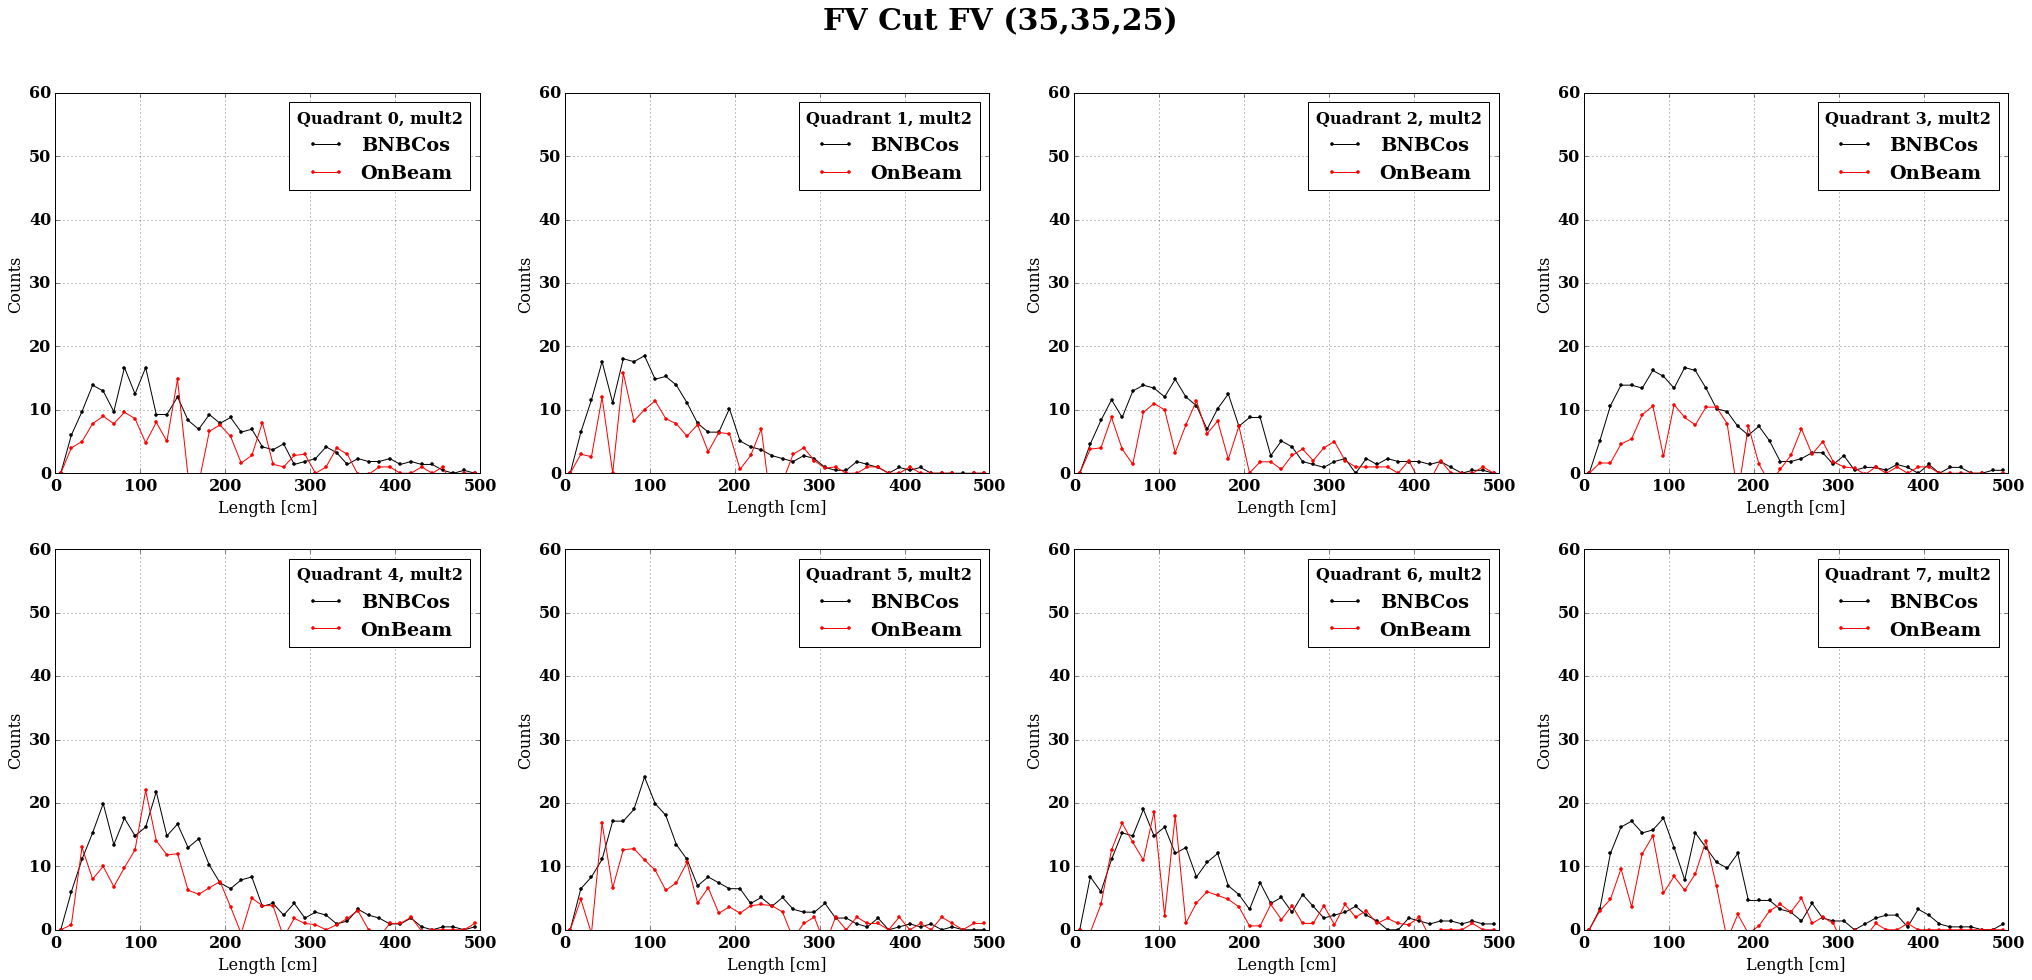

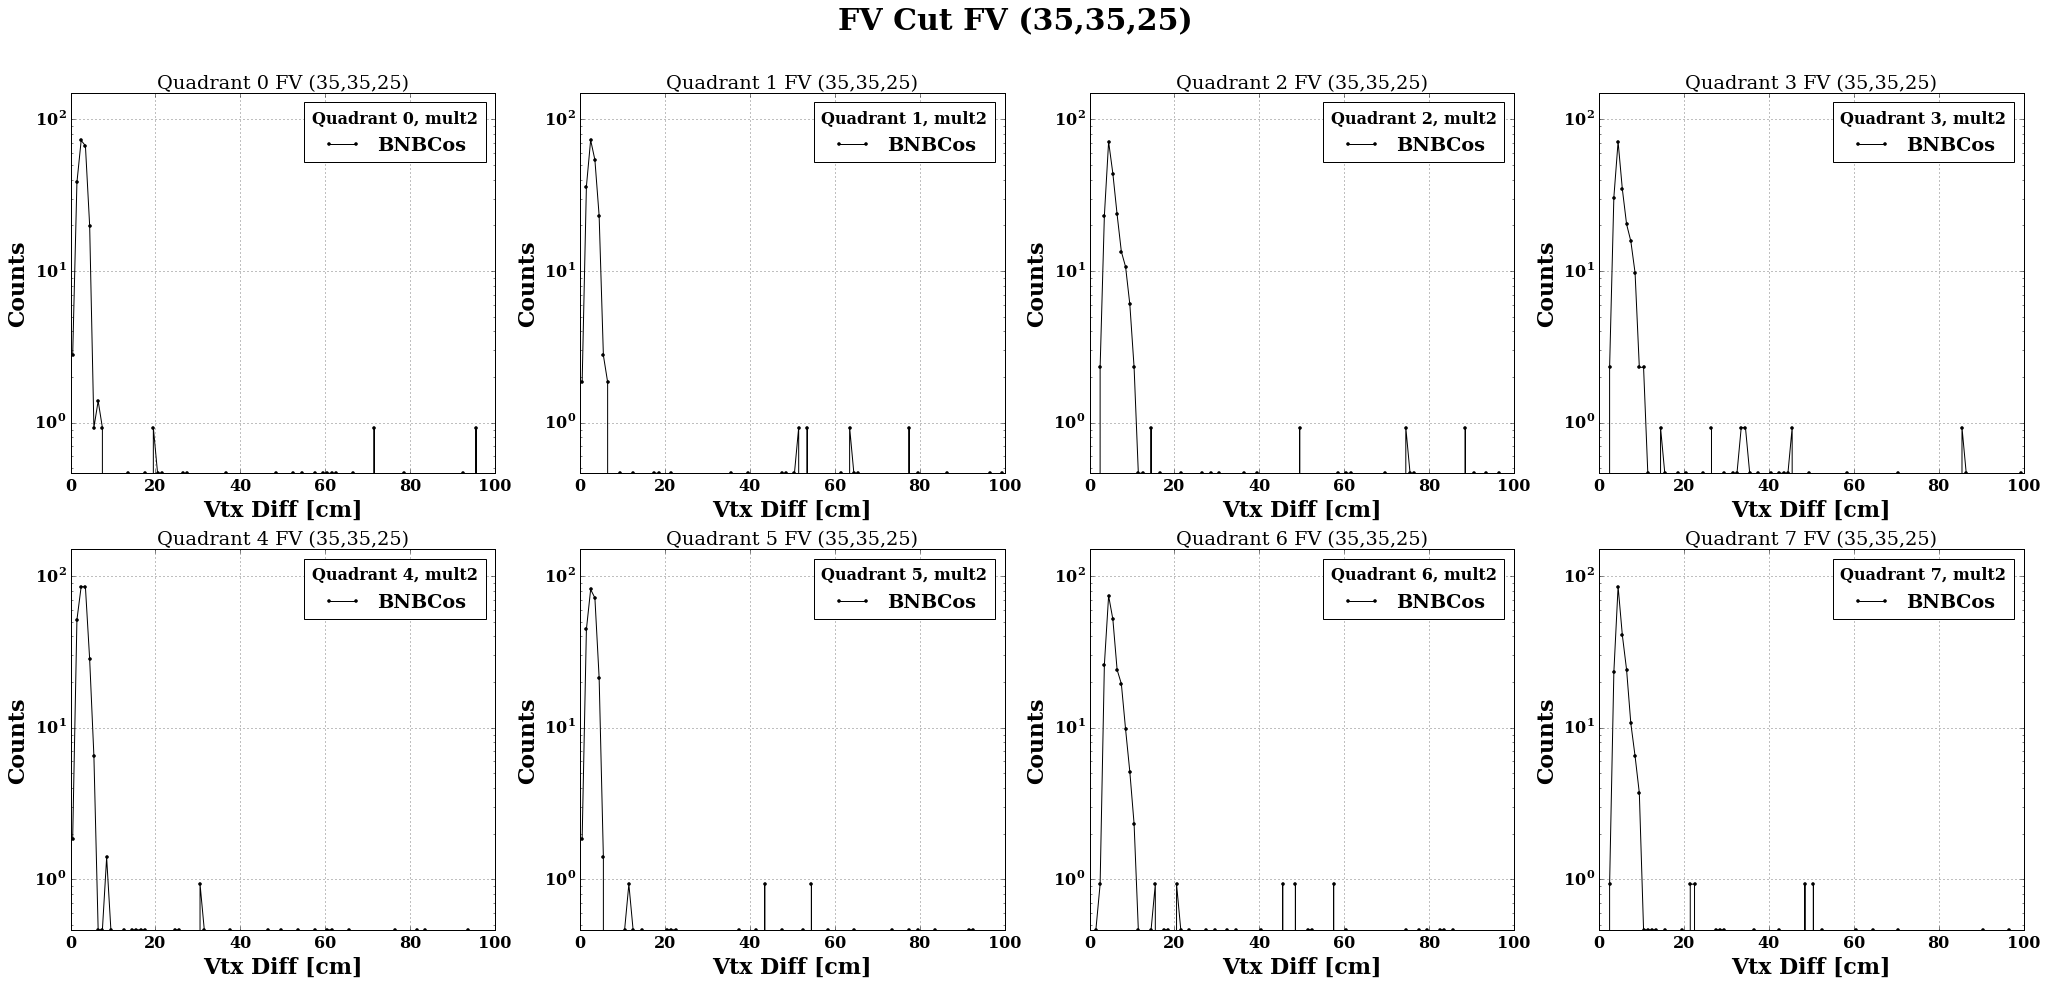

40.0 40.0 30.0


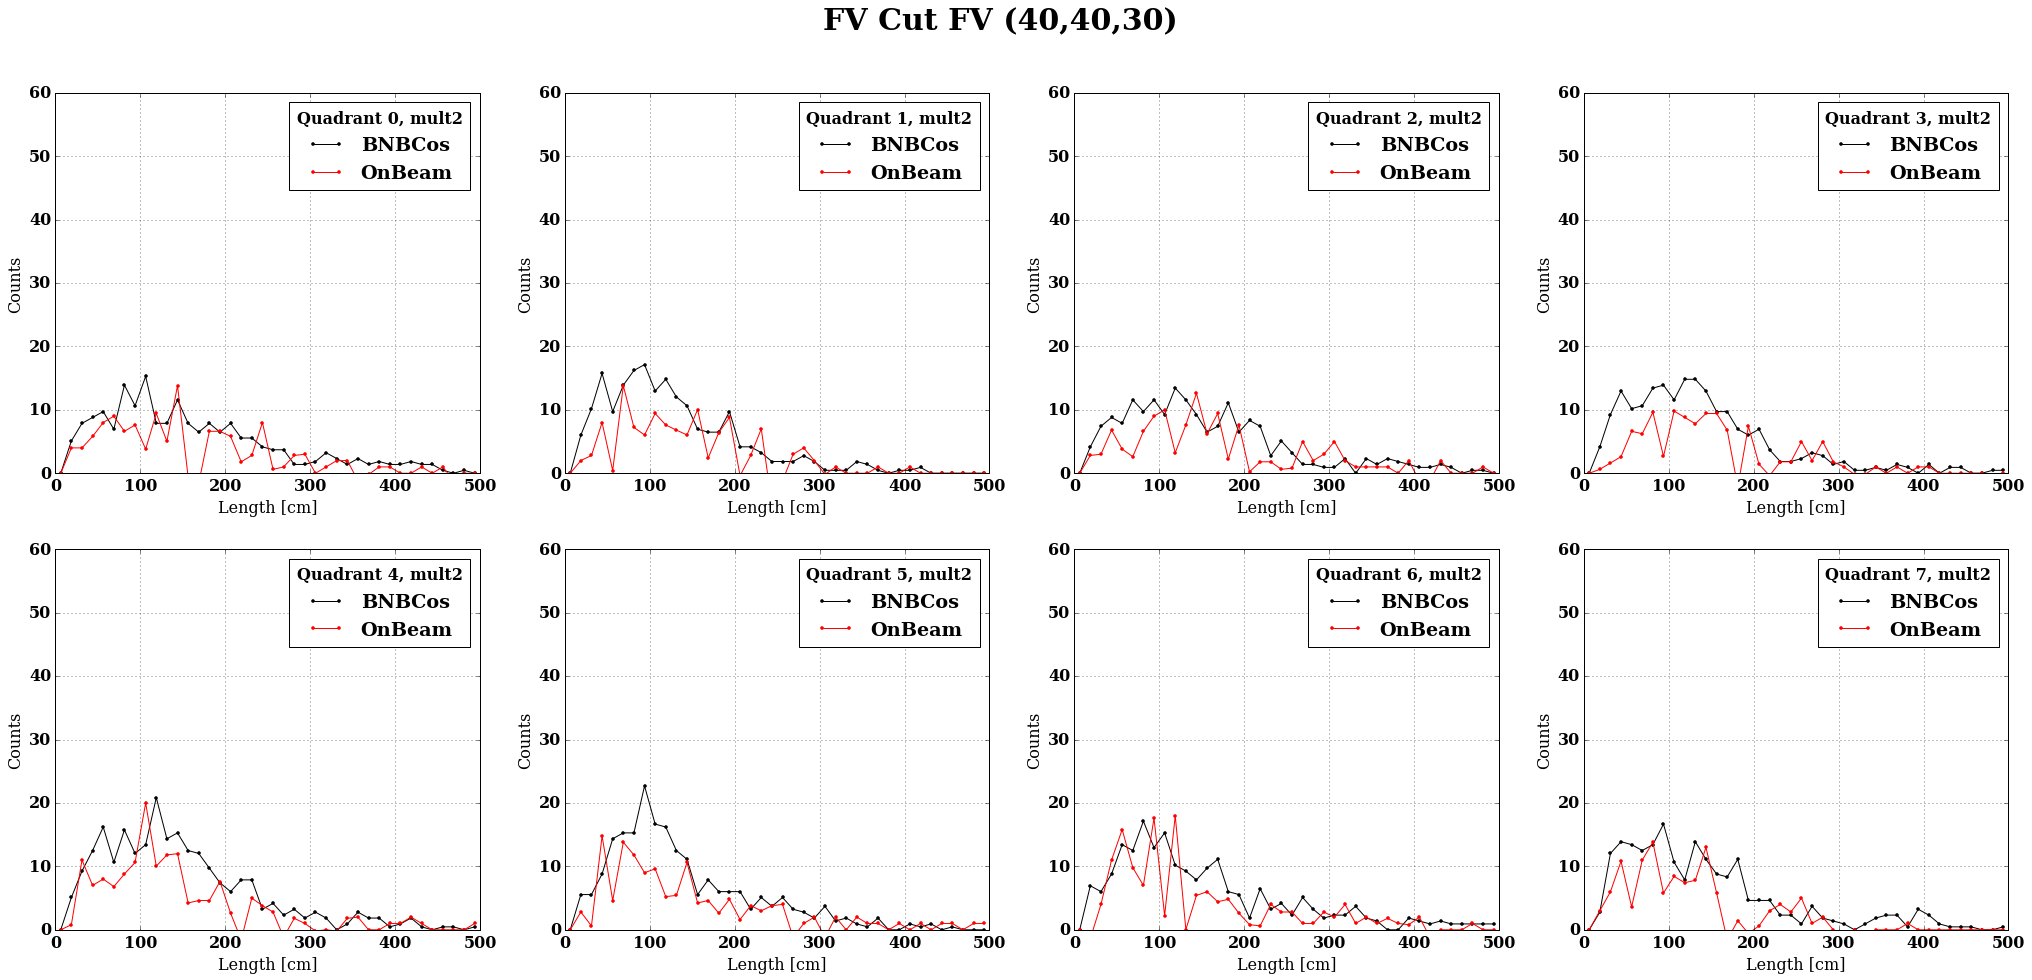

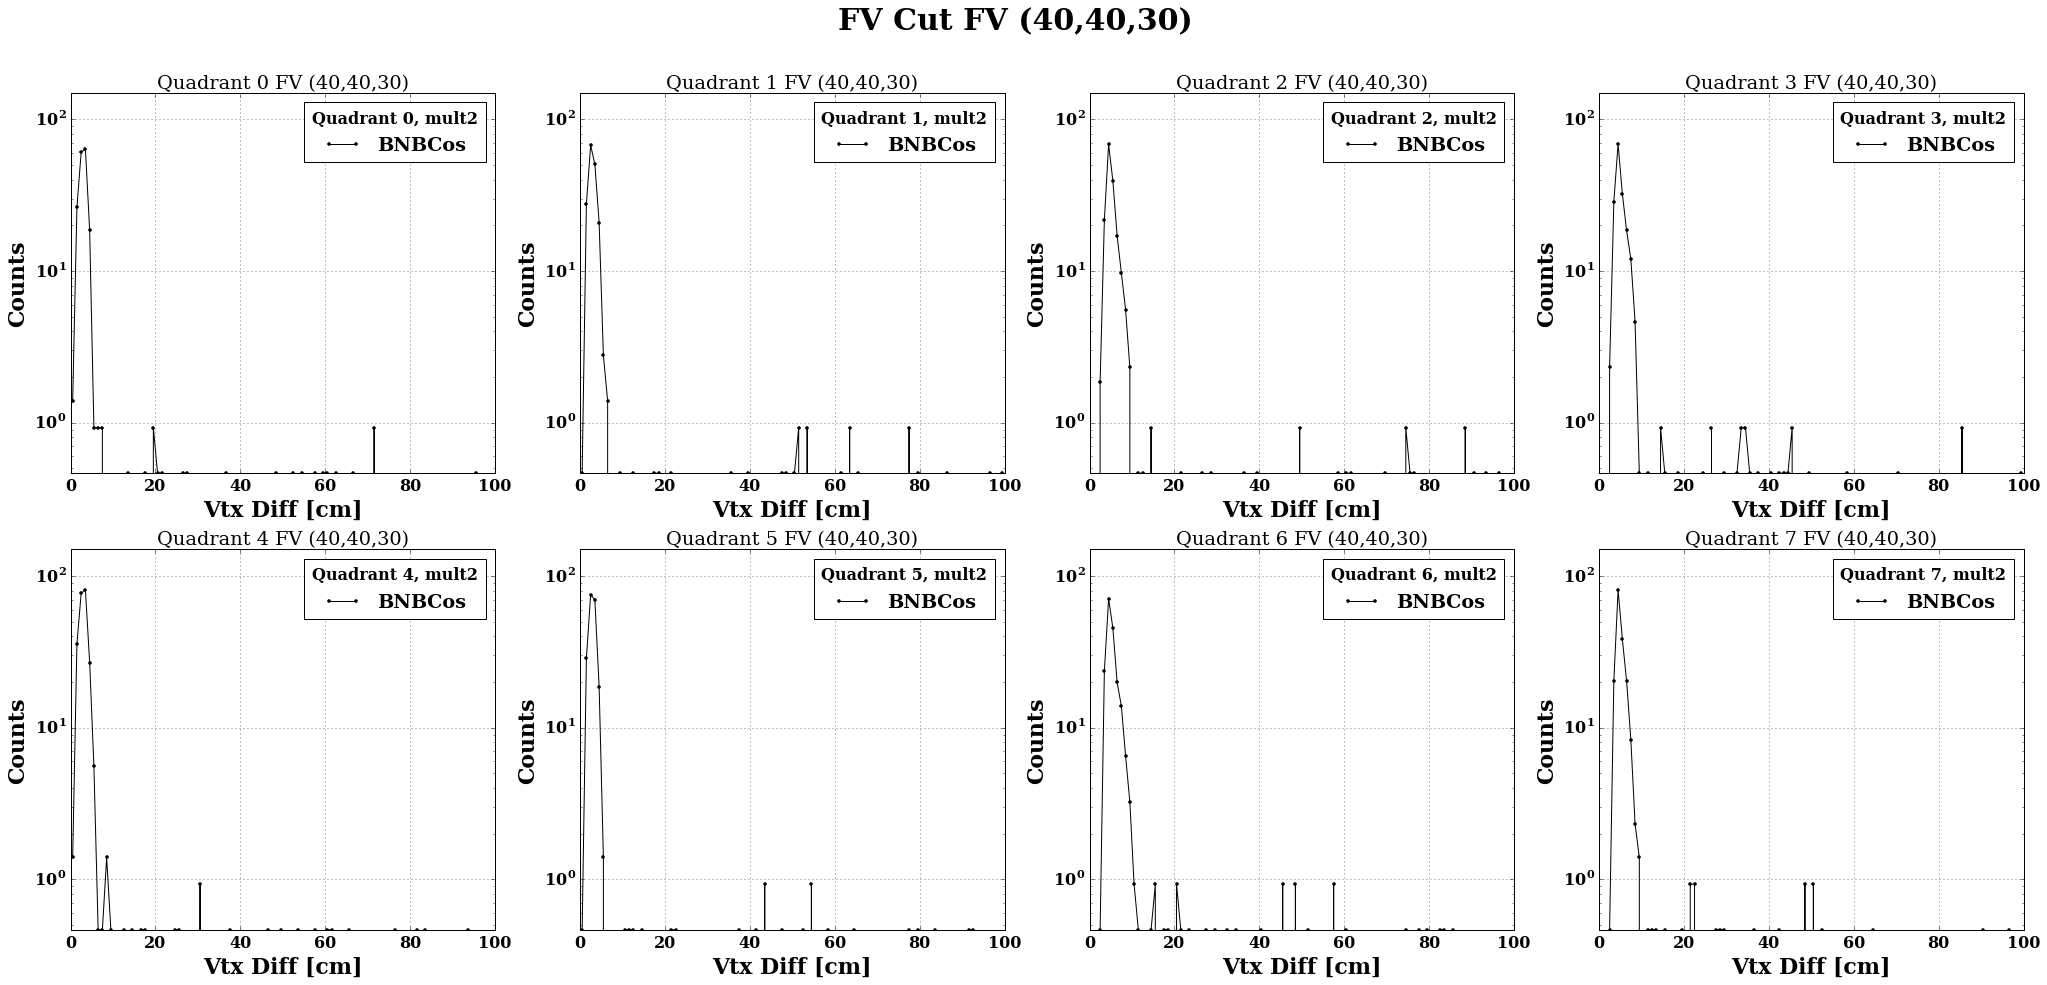

45.0 45.0 35.0


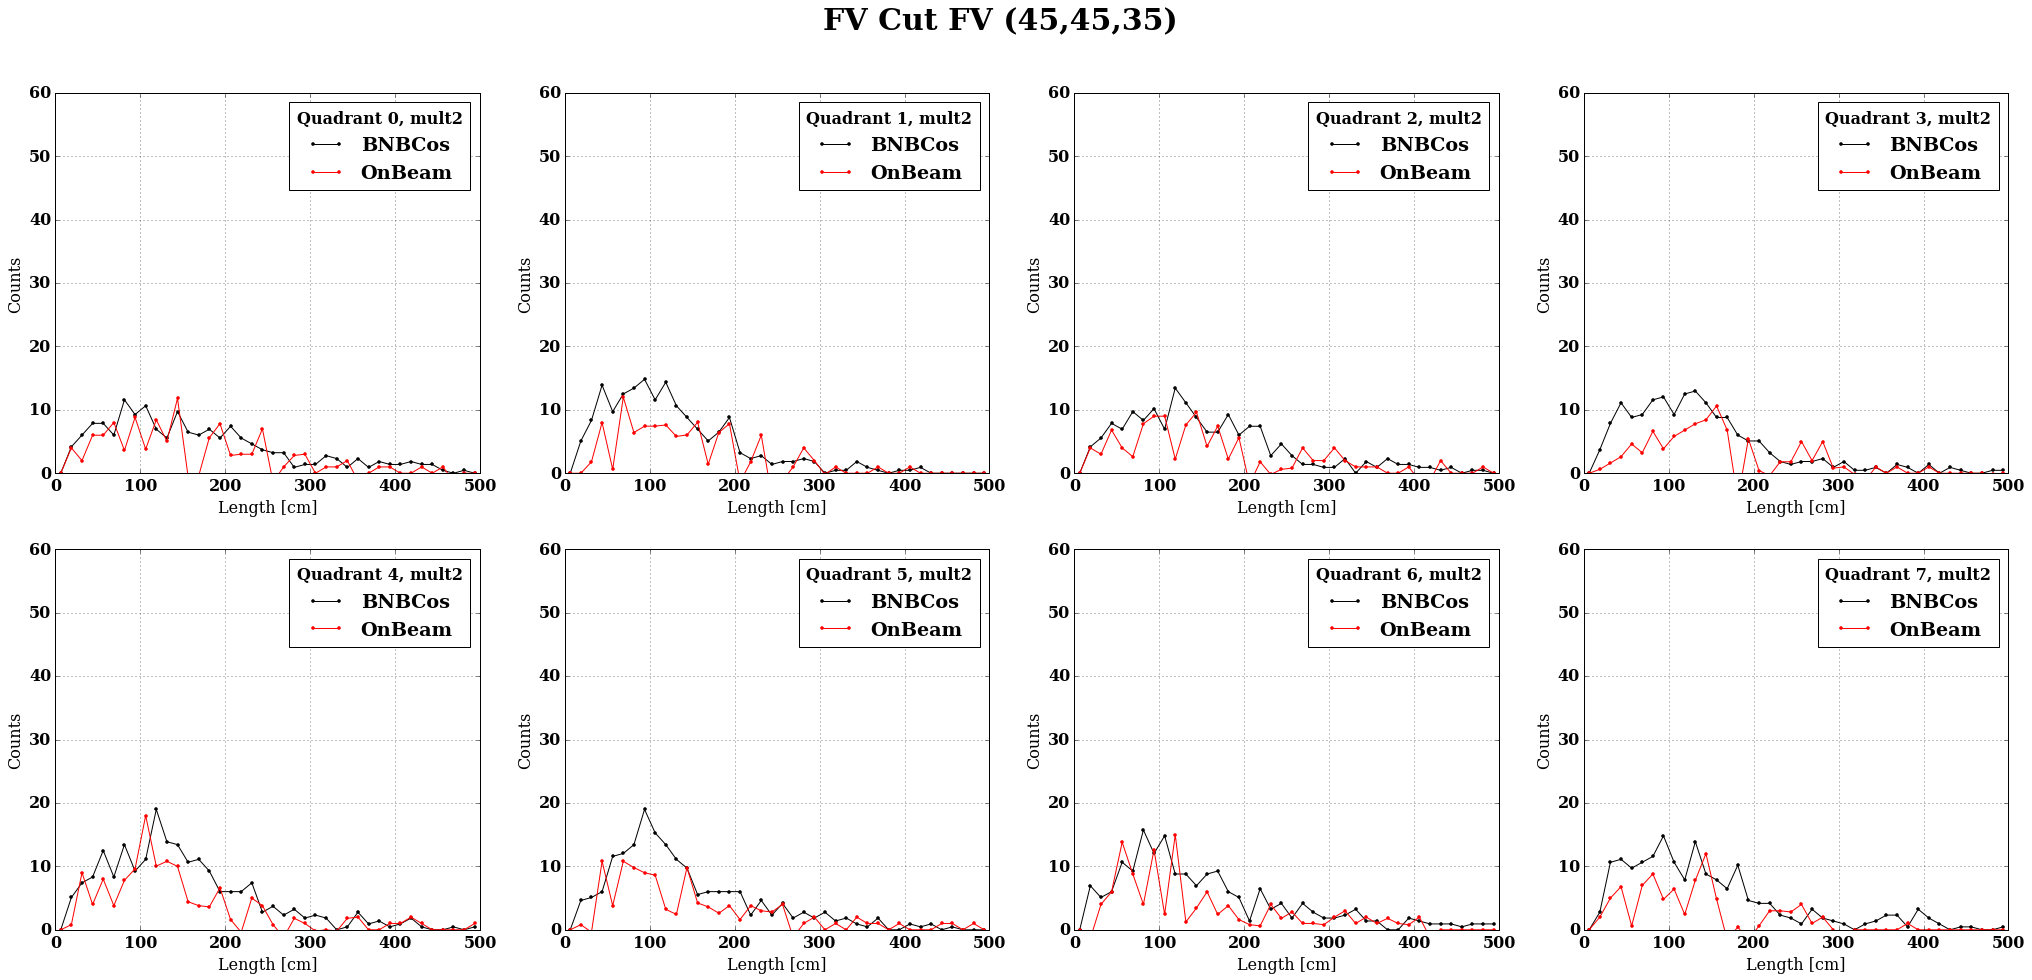

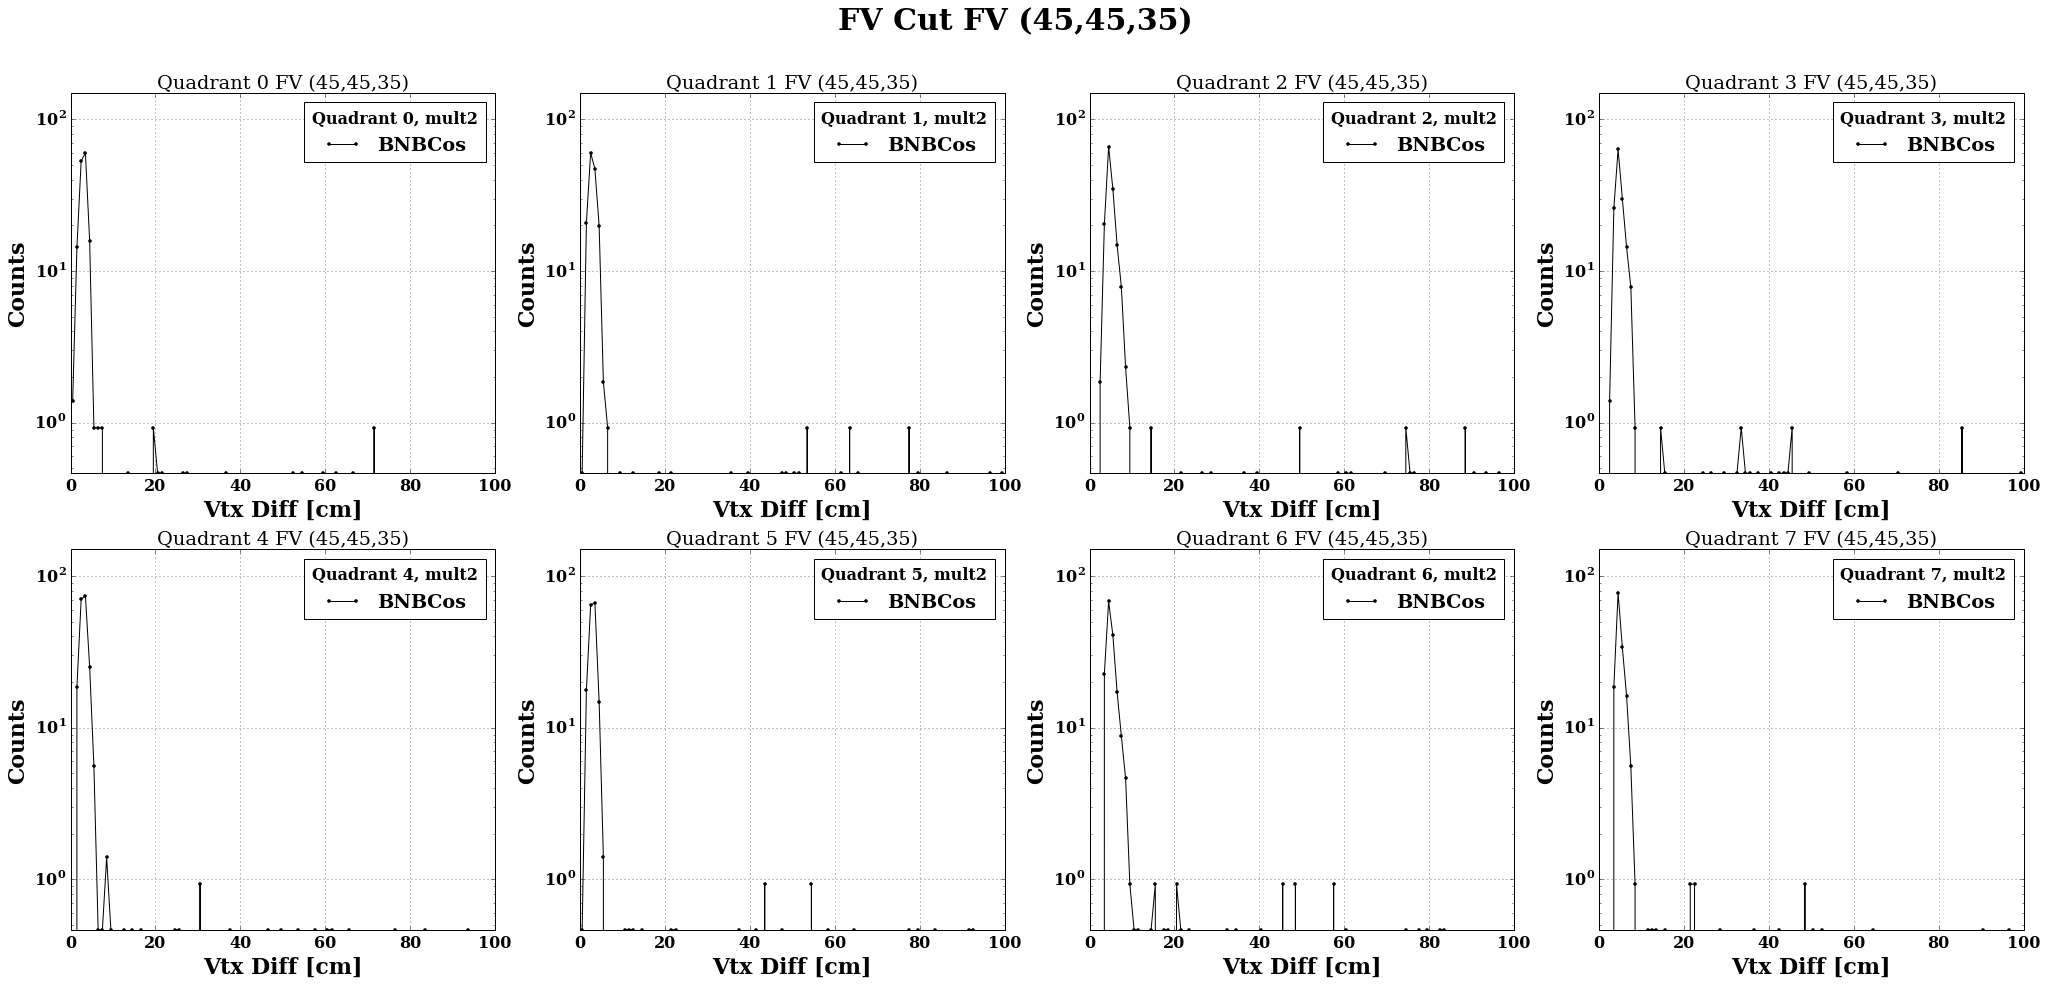

50.0 50.0 40.0


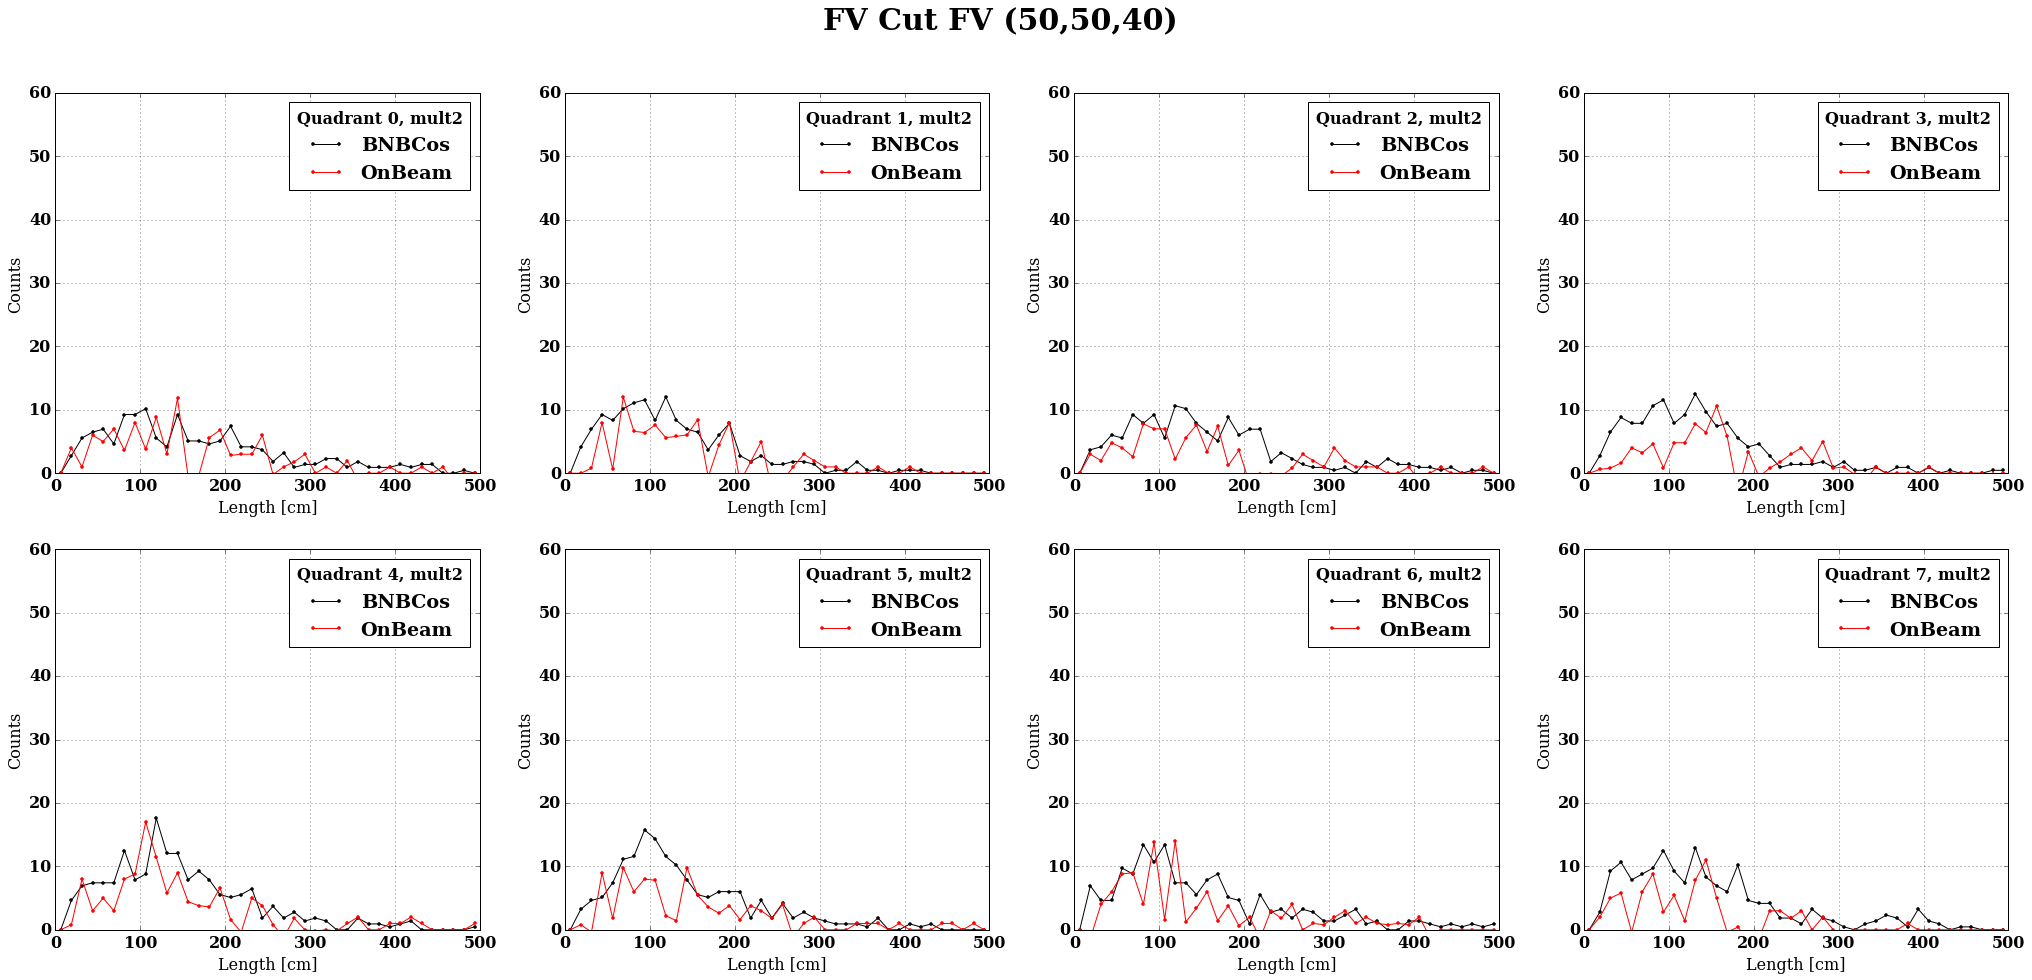

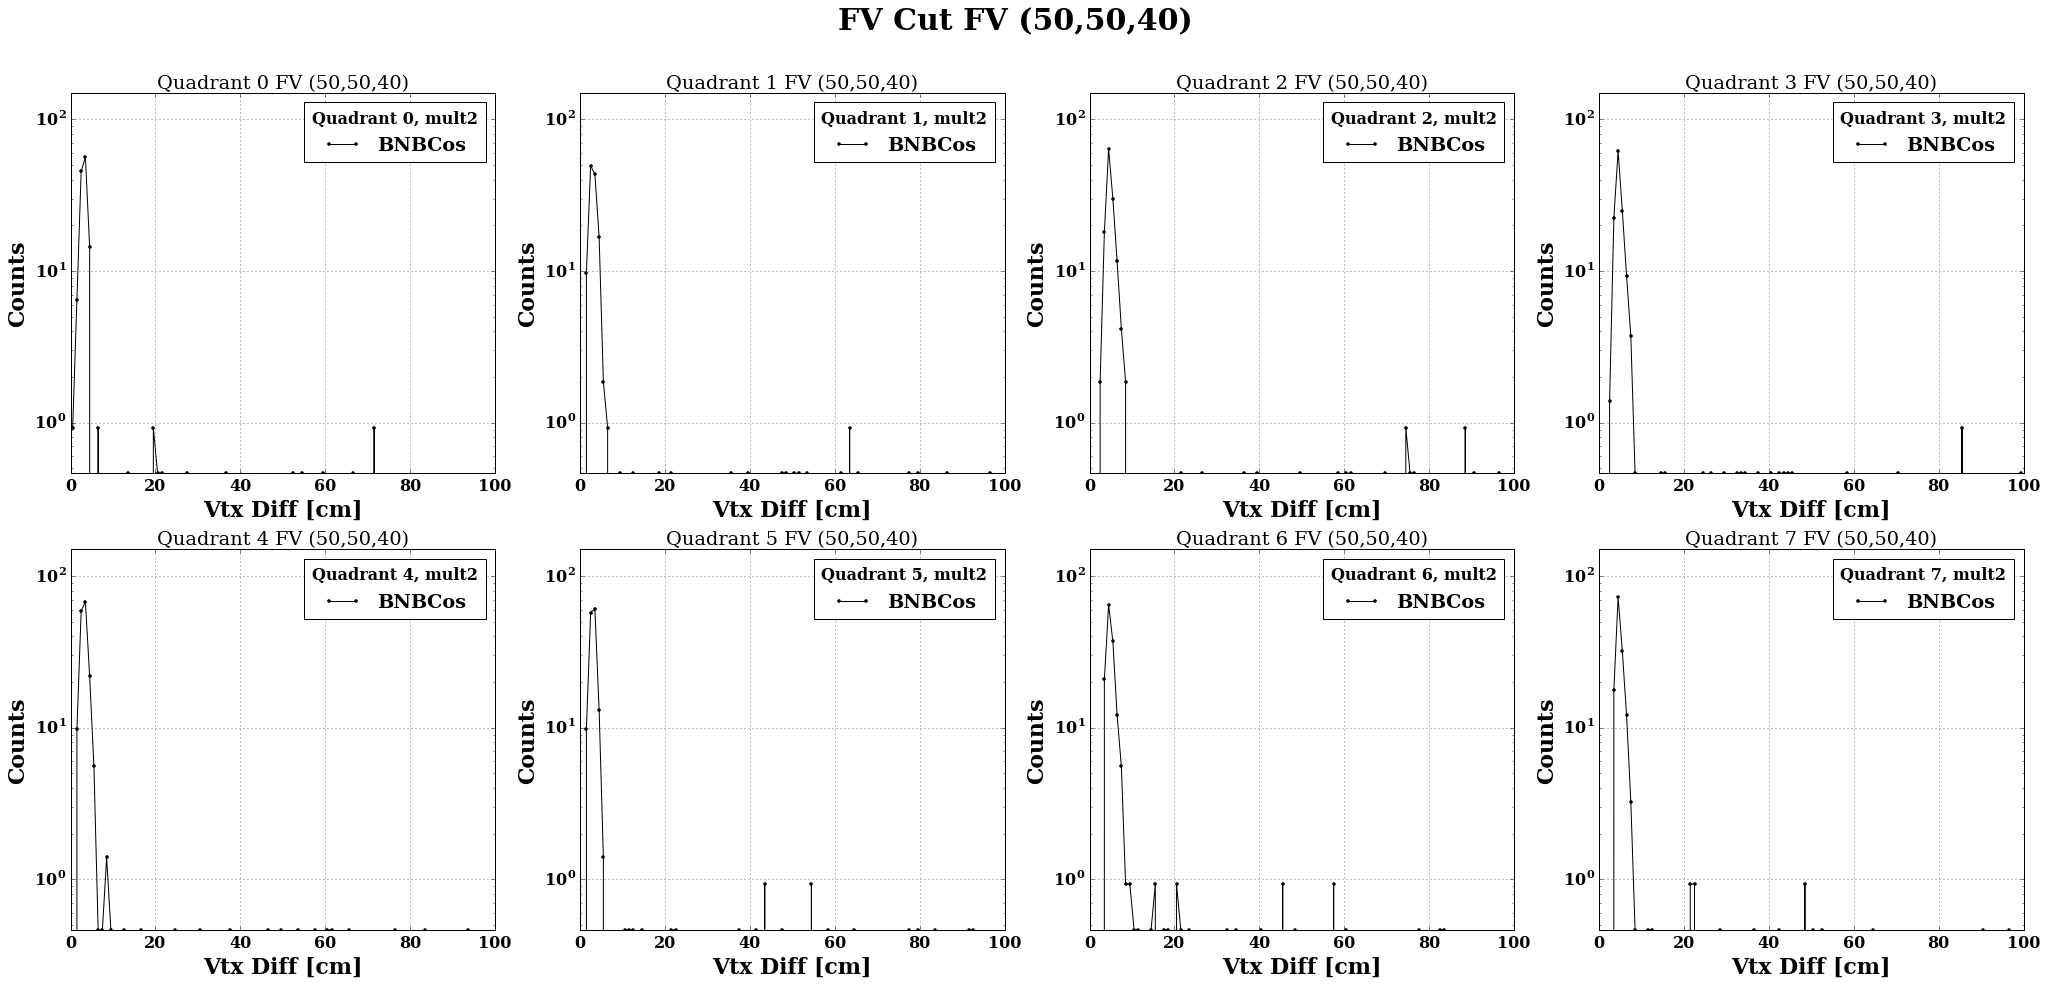

In [244]:
getFVRegions(df_beam_mult2, df_offbeam_mult2, df_bnbcos_mult2,name='mult2')

In [ ]:
getRegions(df_beam_mult1, df_offbeam_mult1, df_bnbcos_mult1,name='mult1')

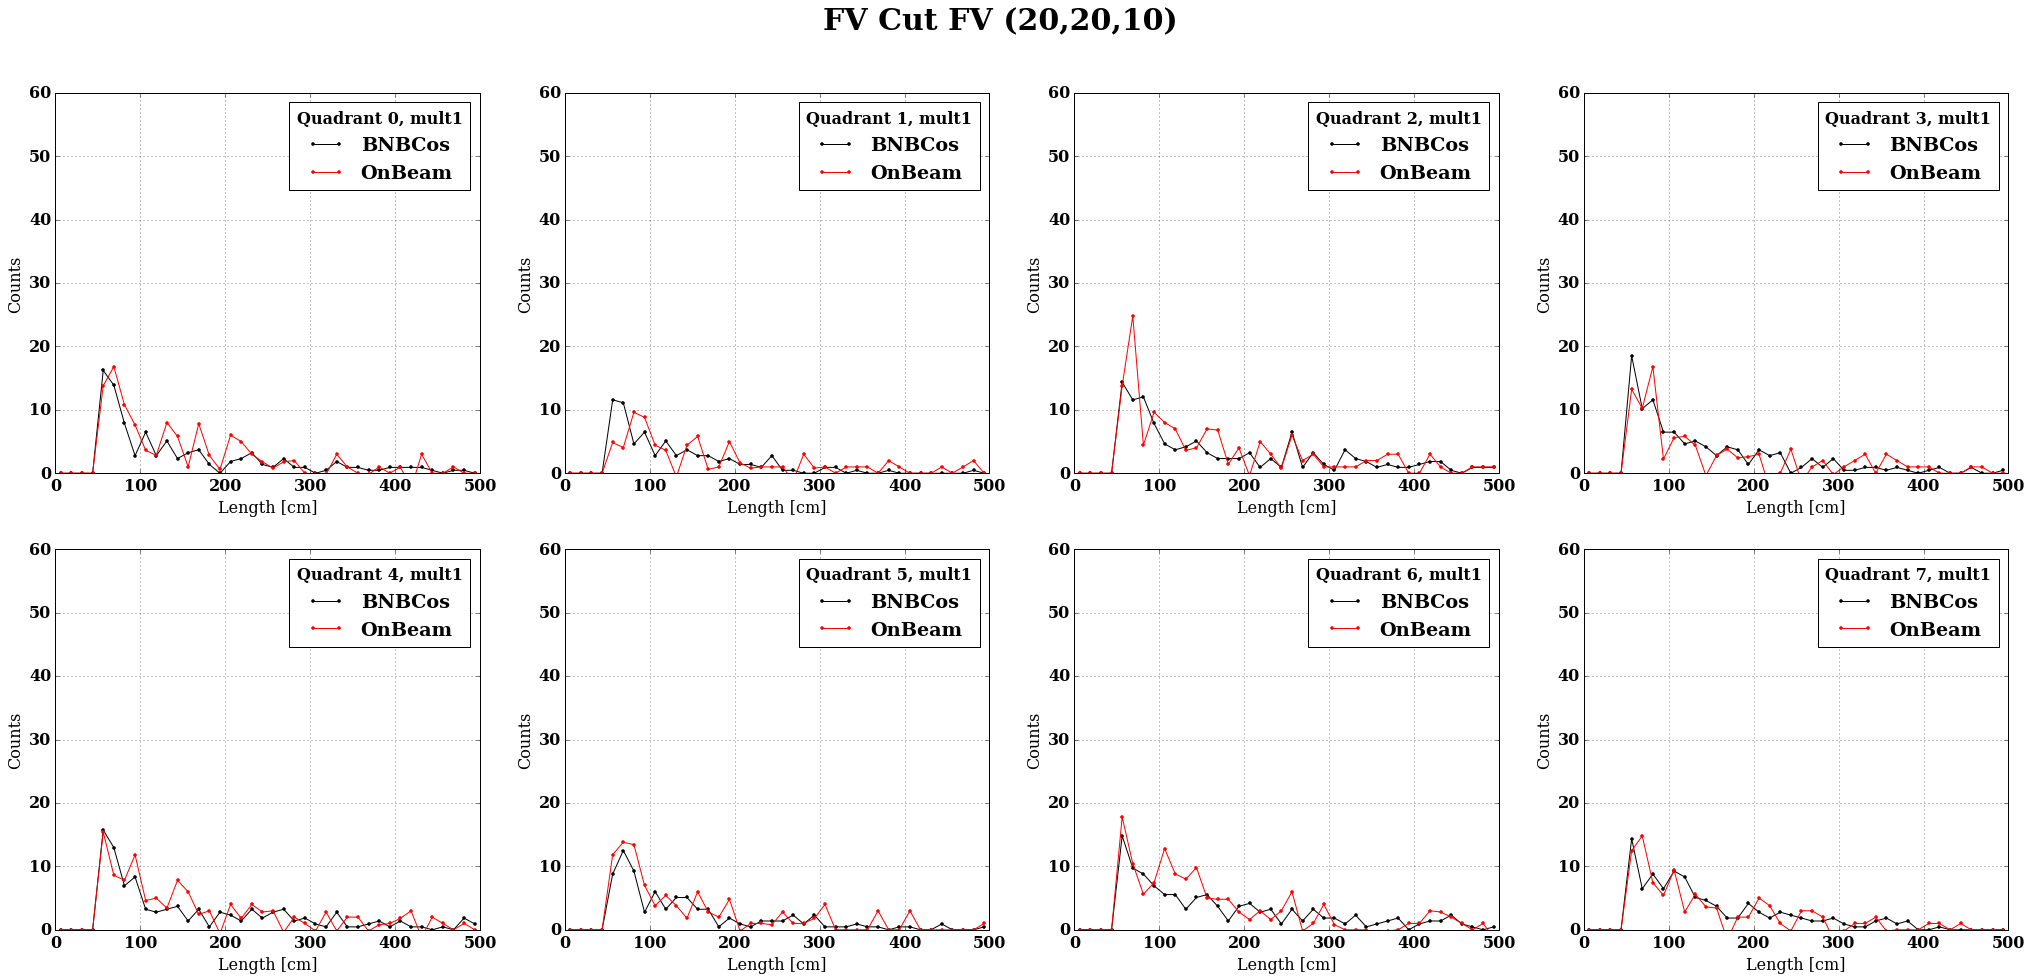

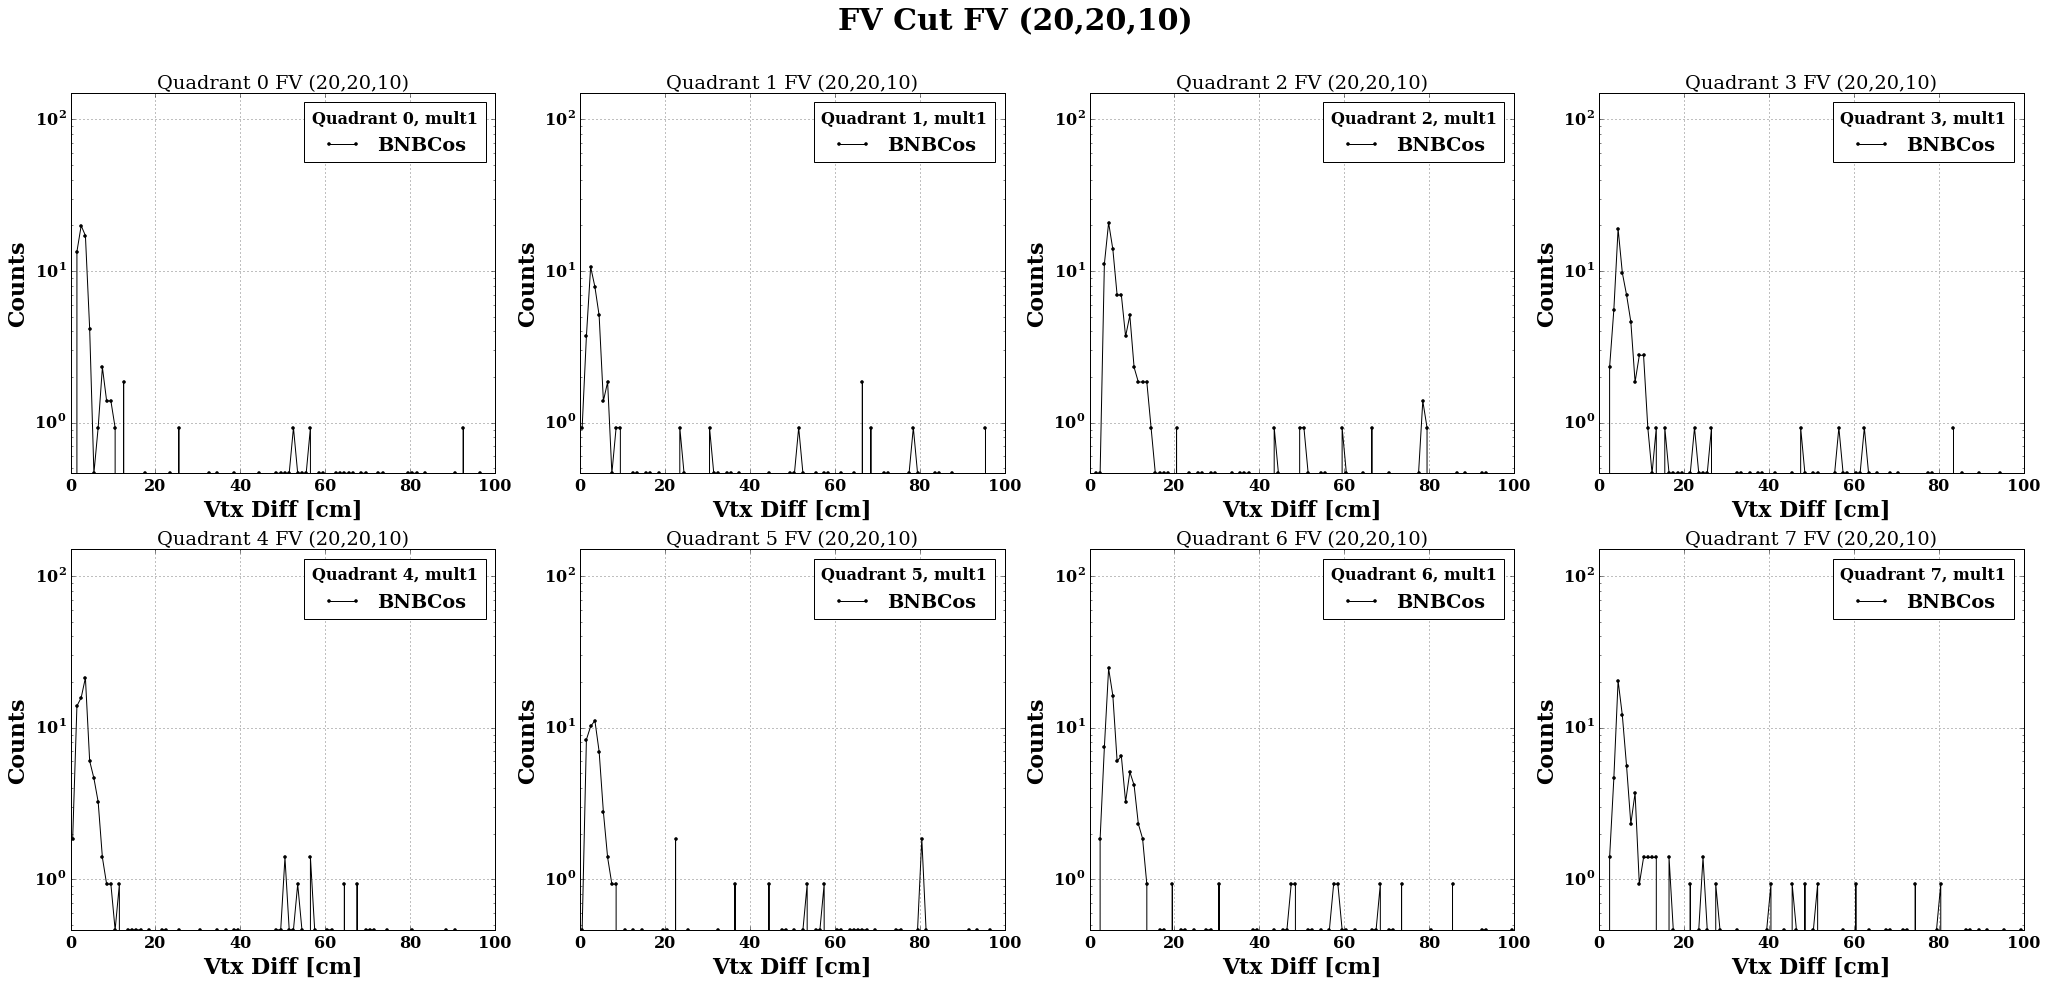

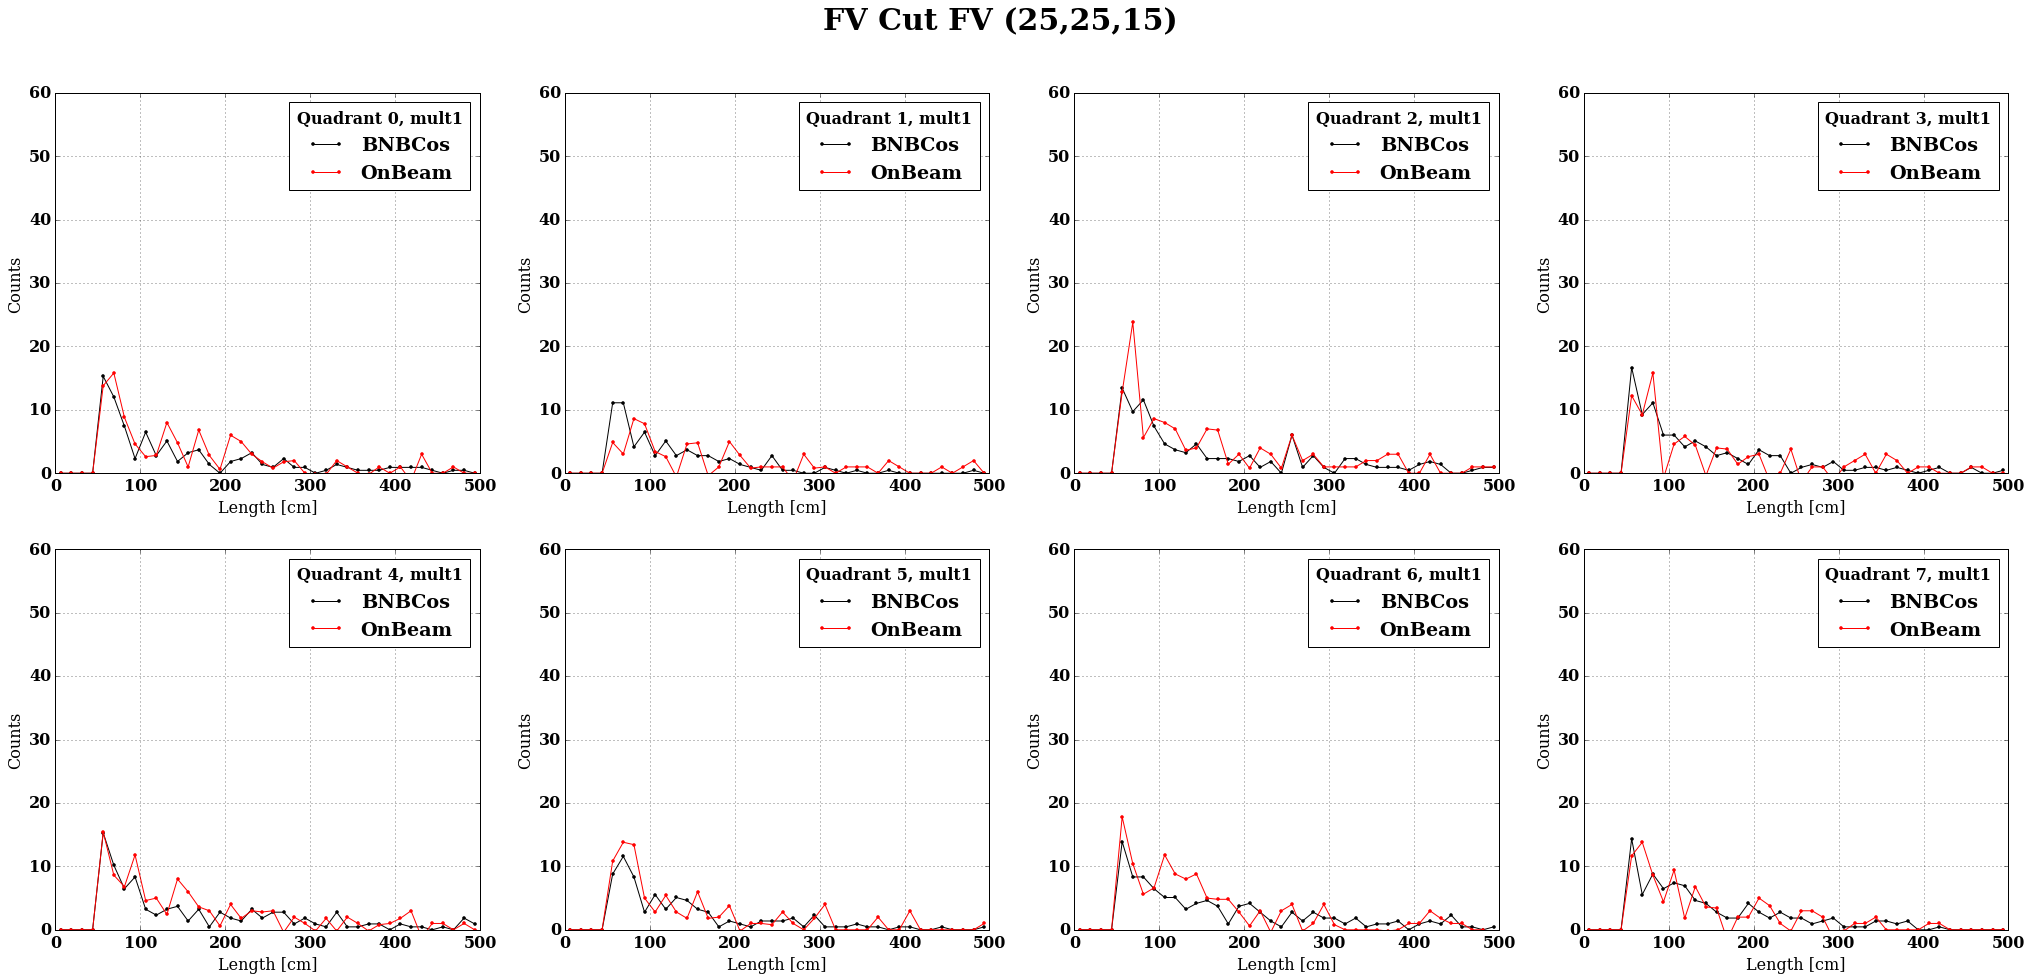

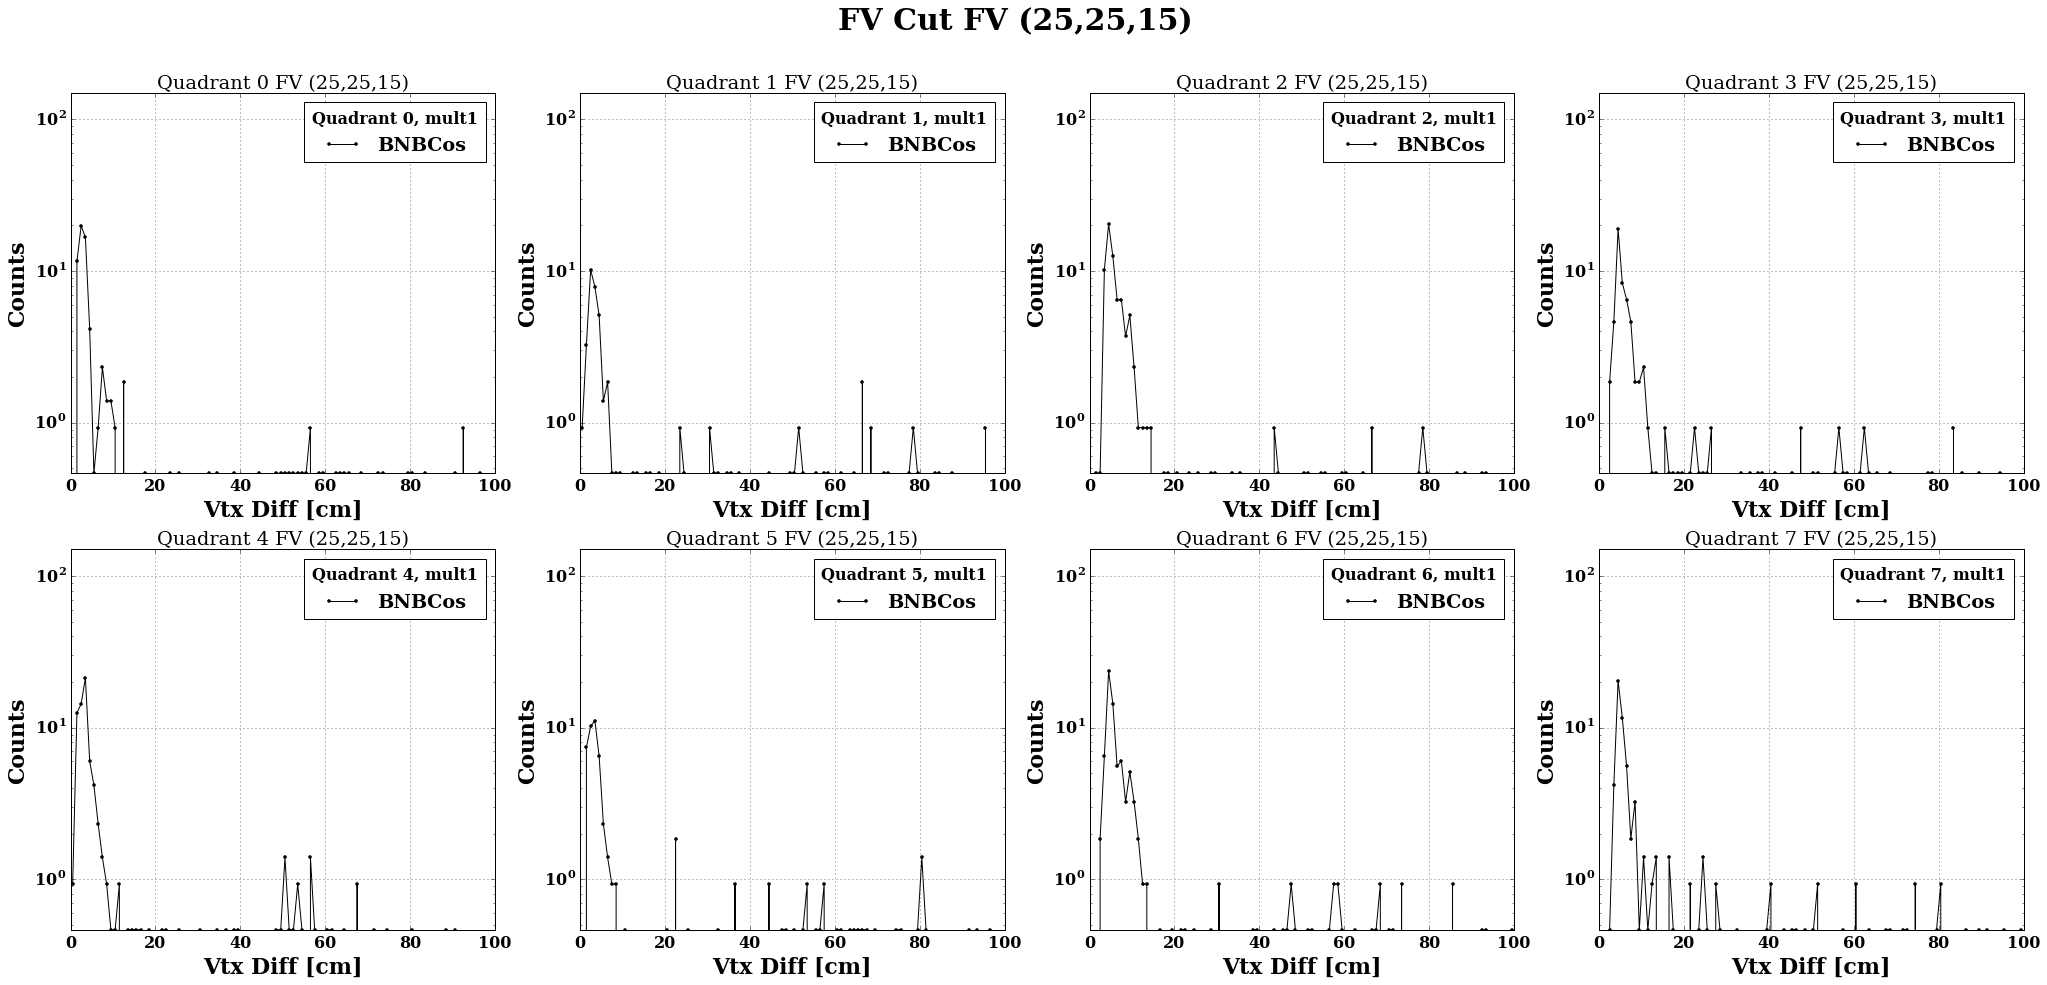

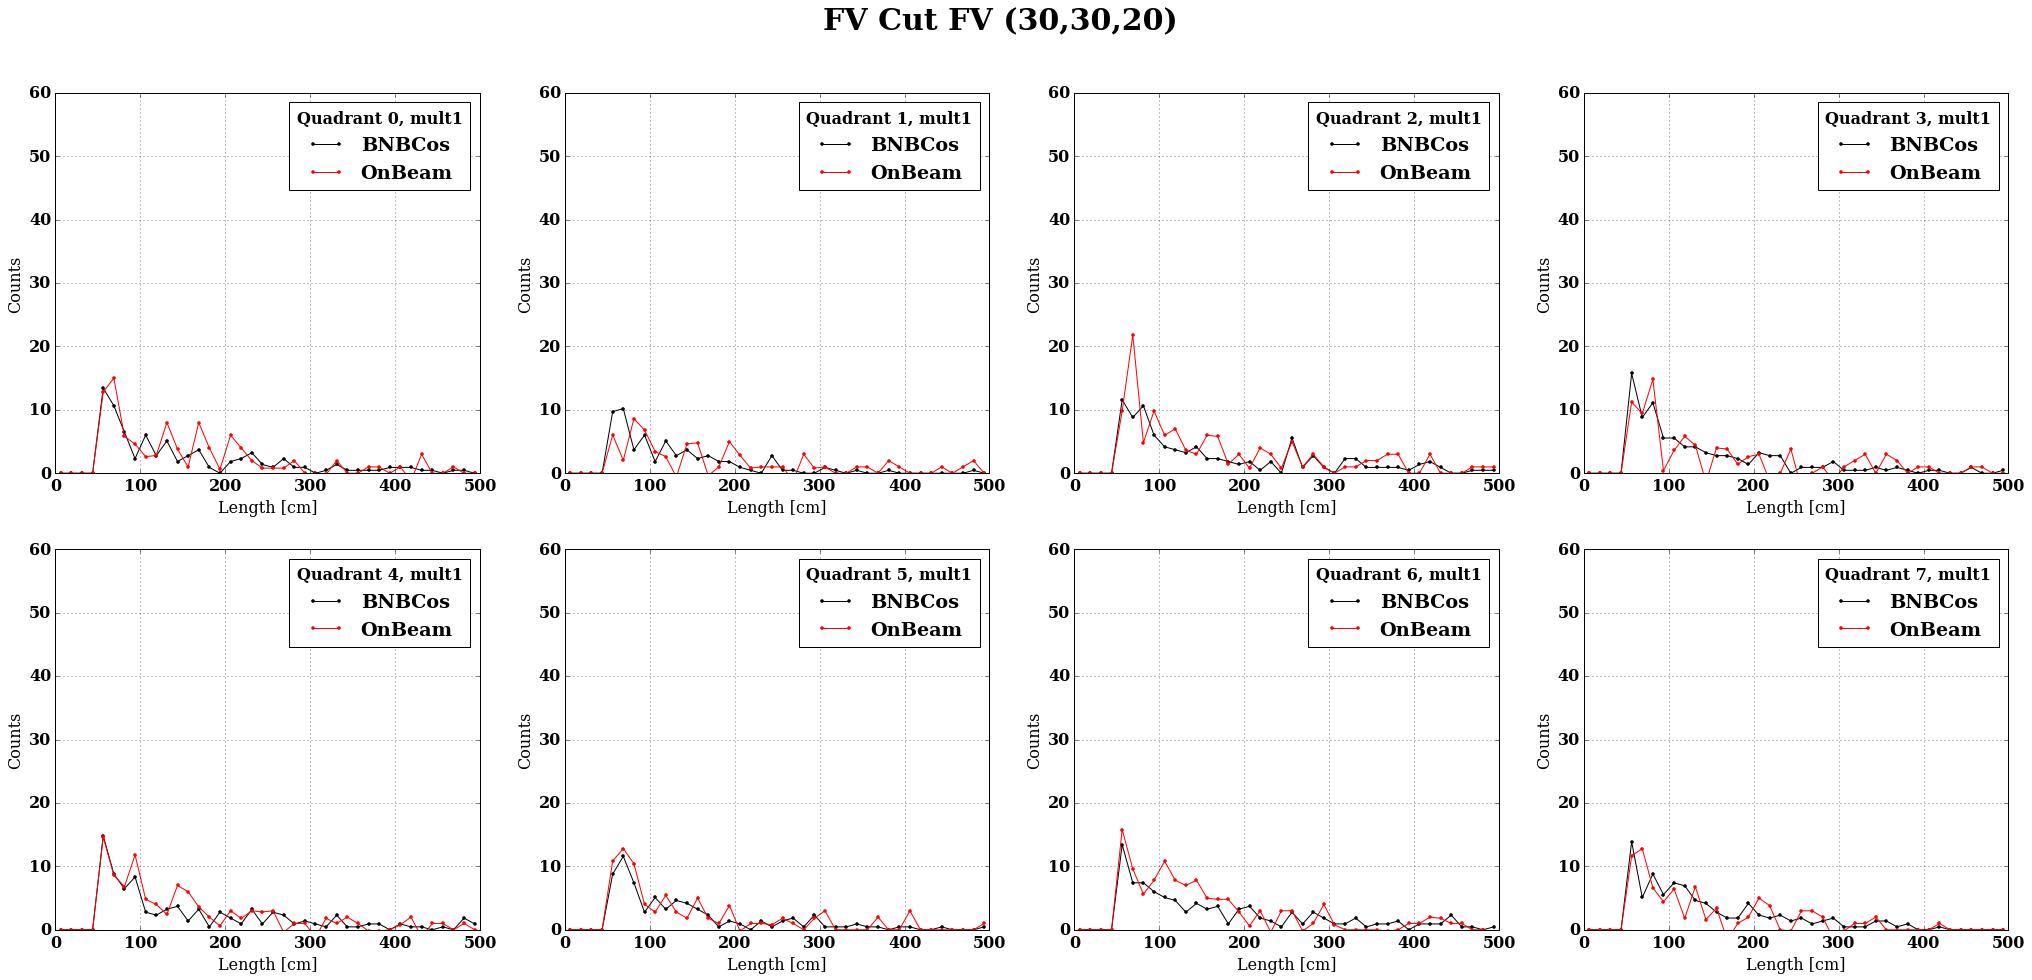

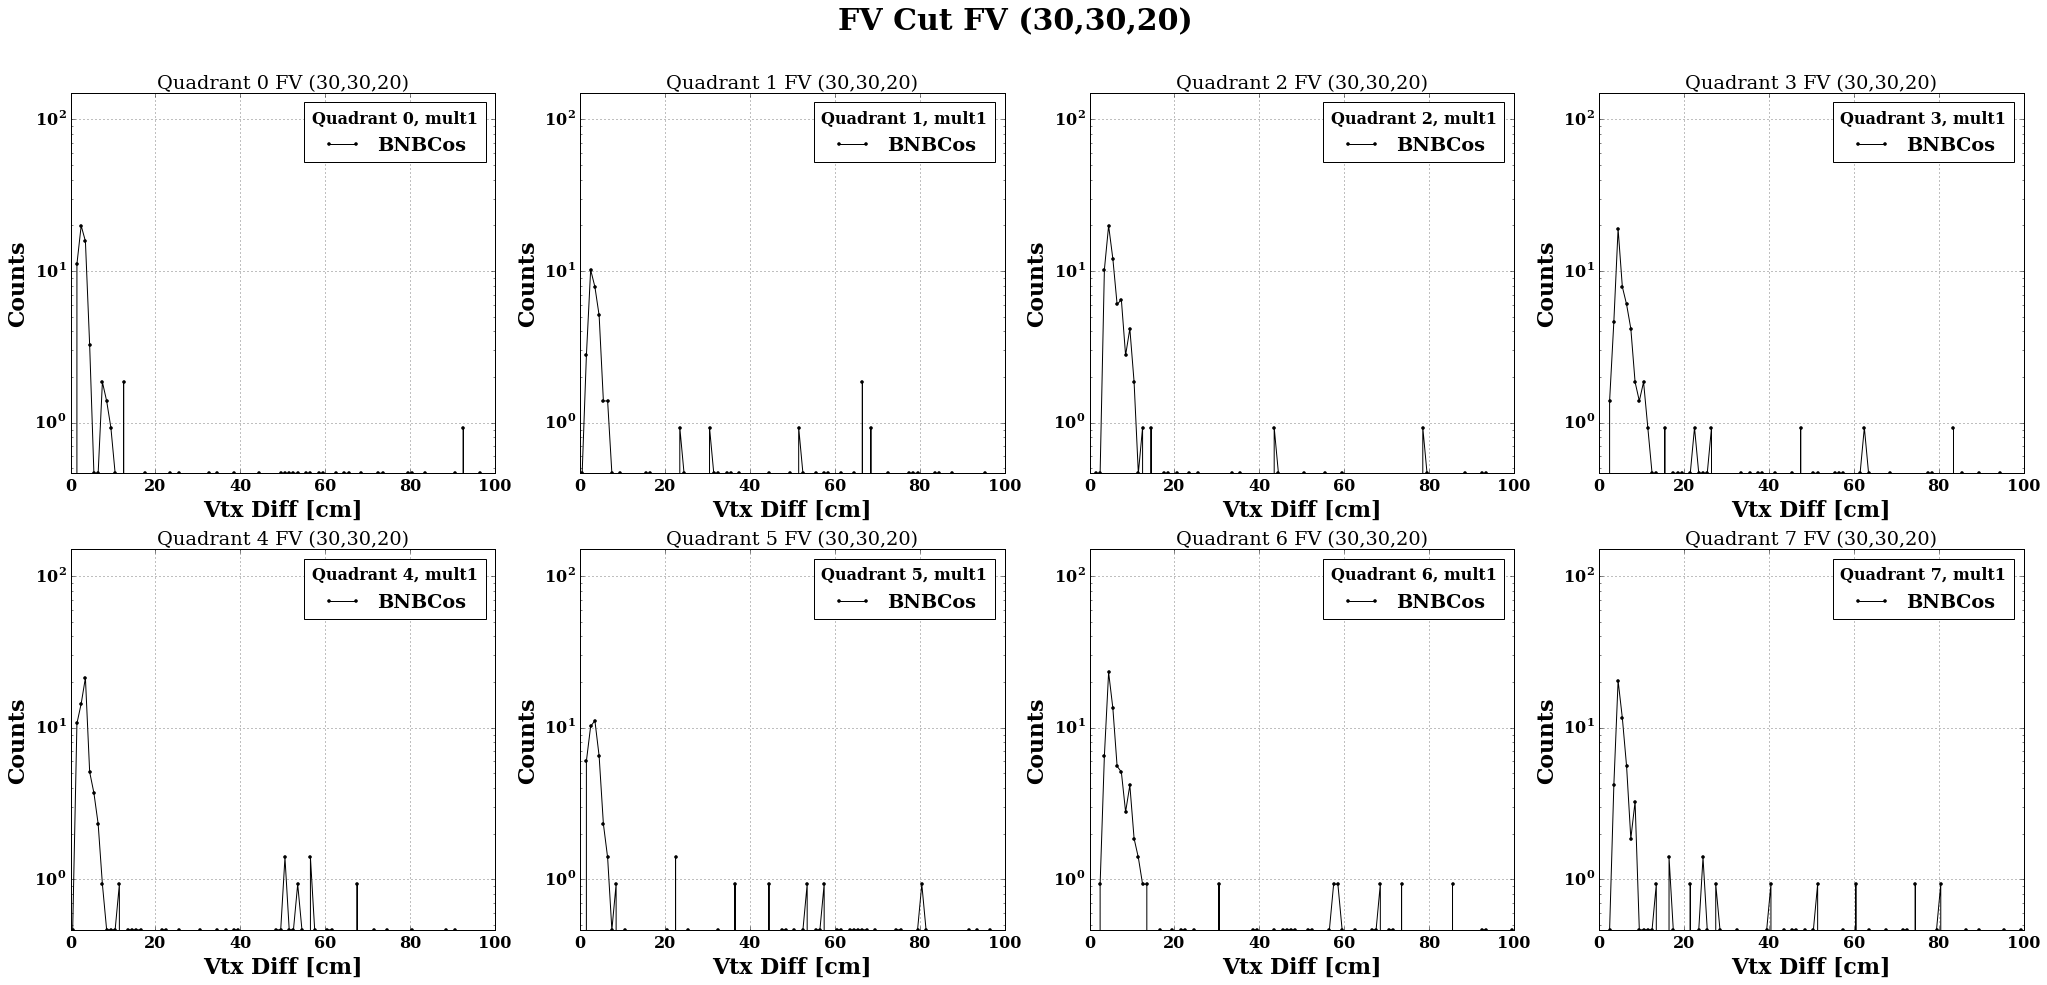

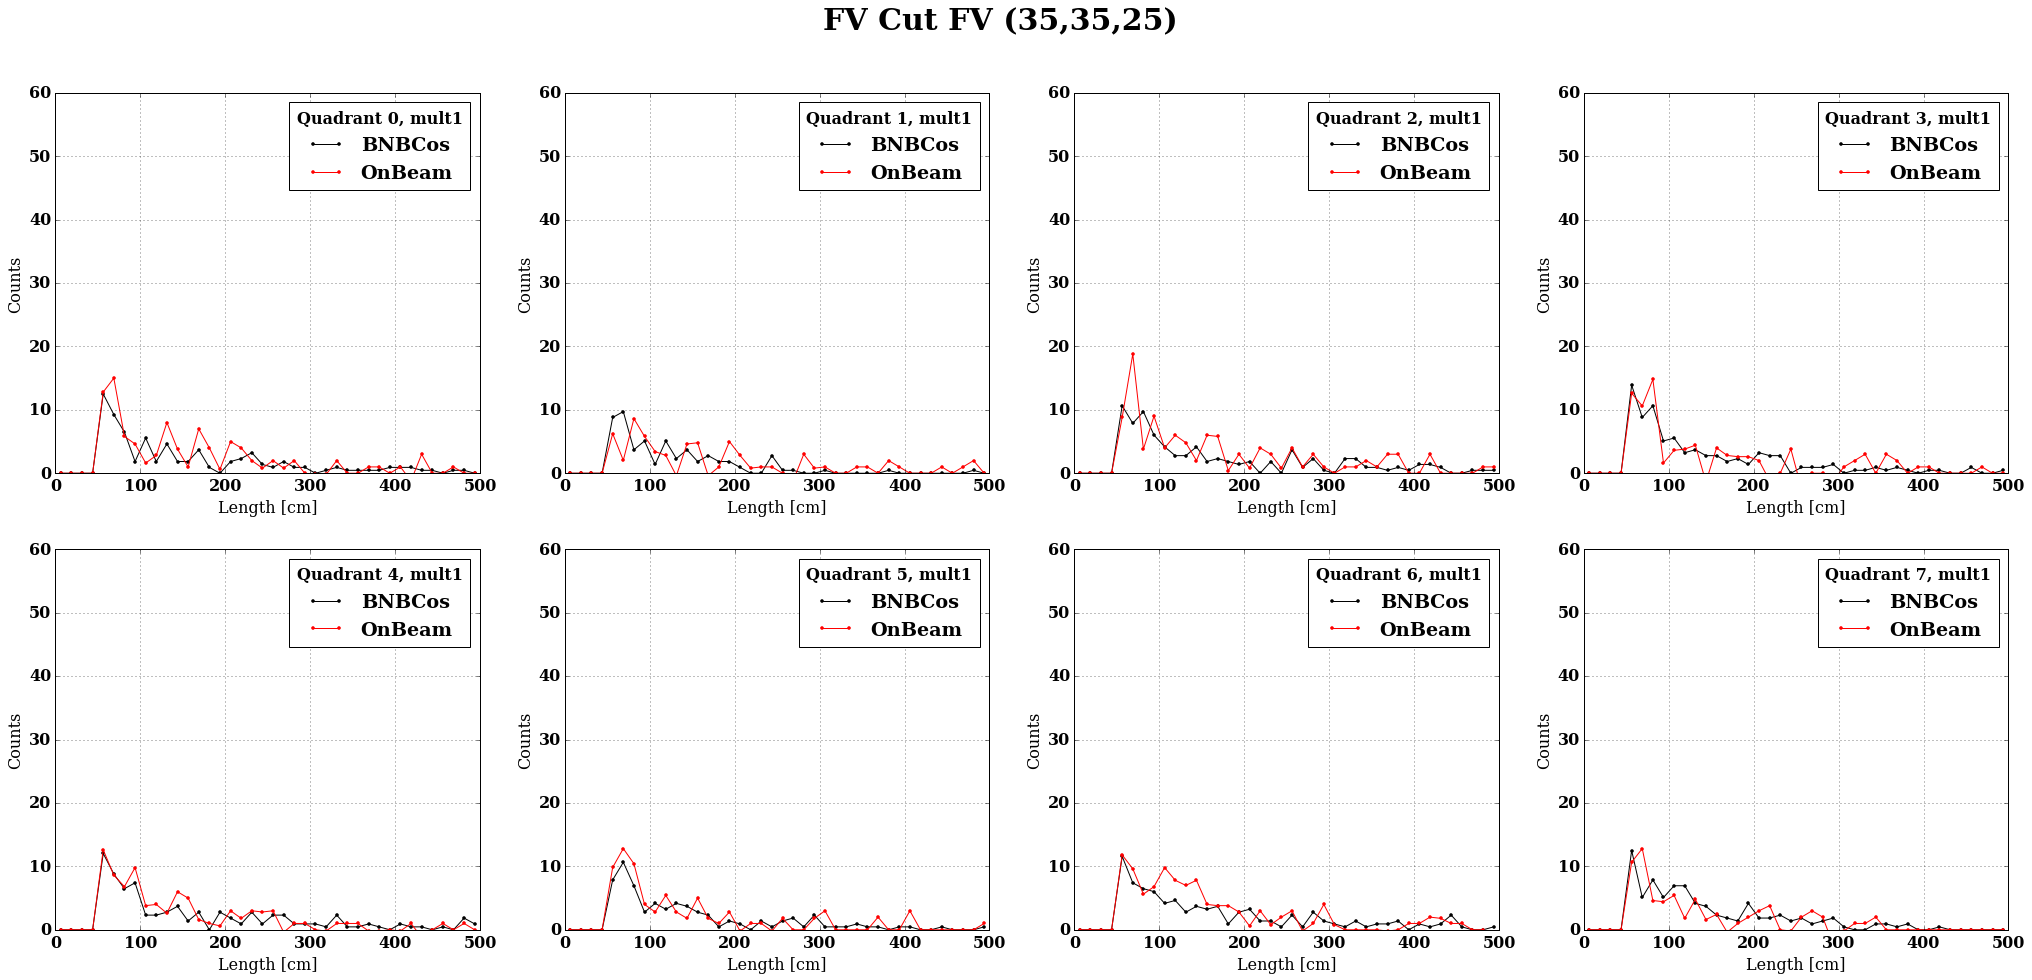

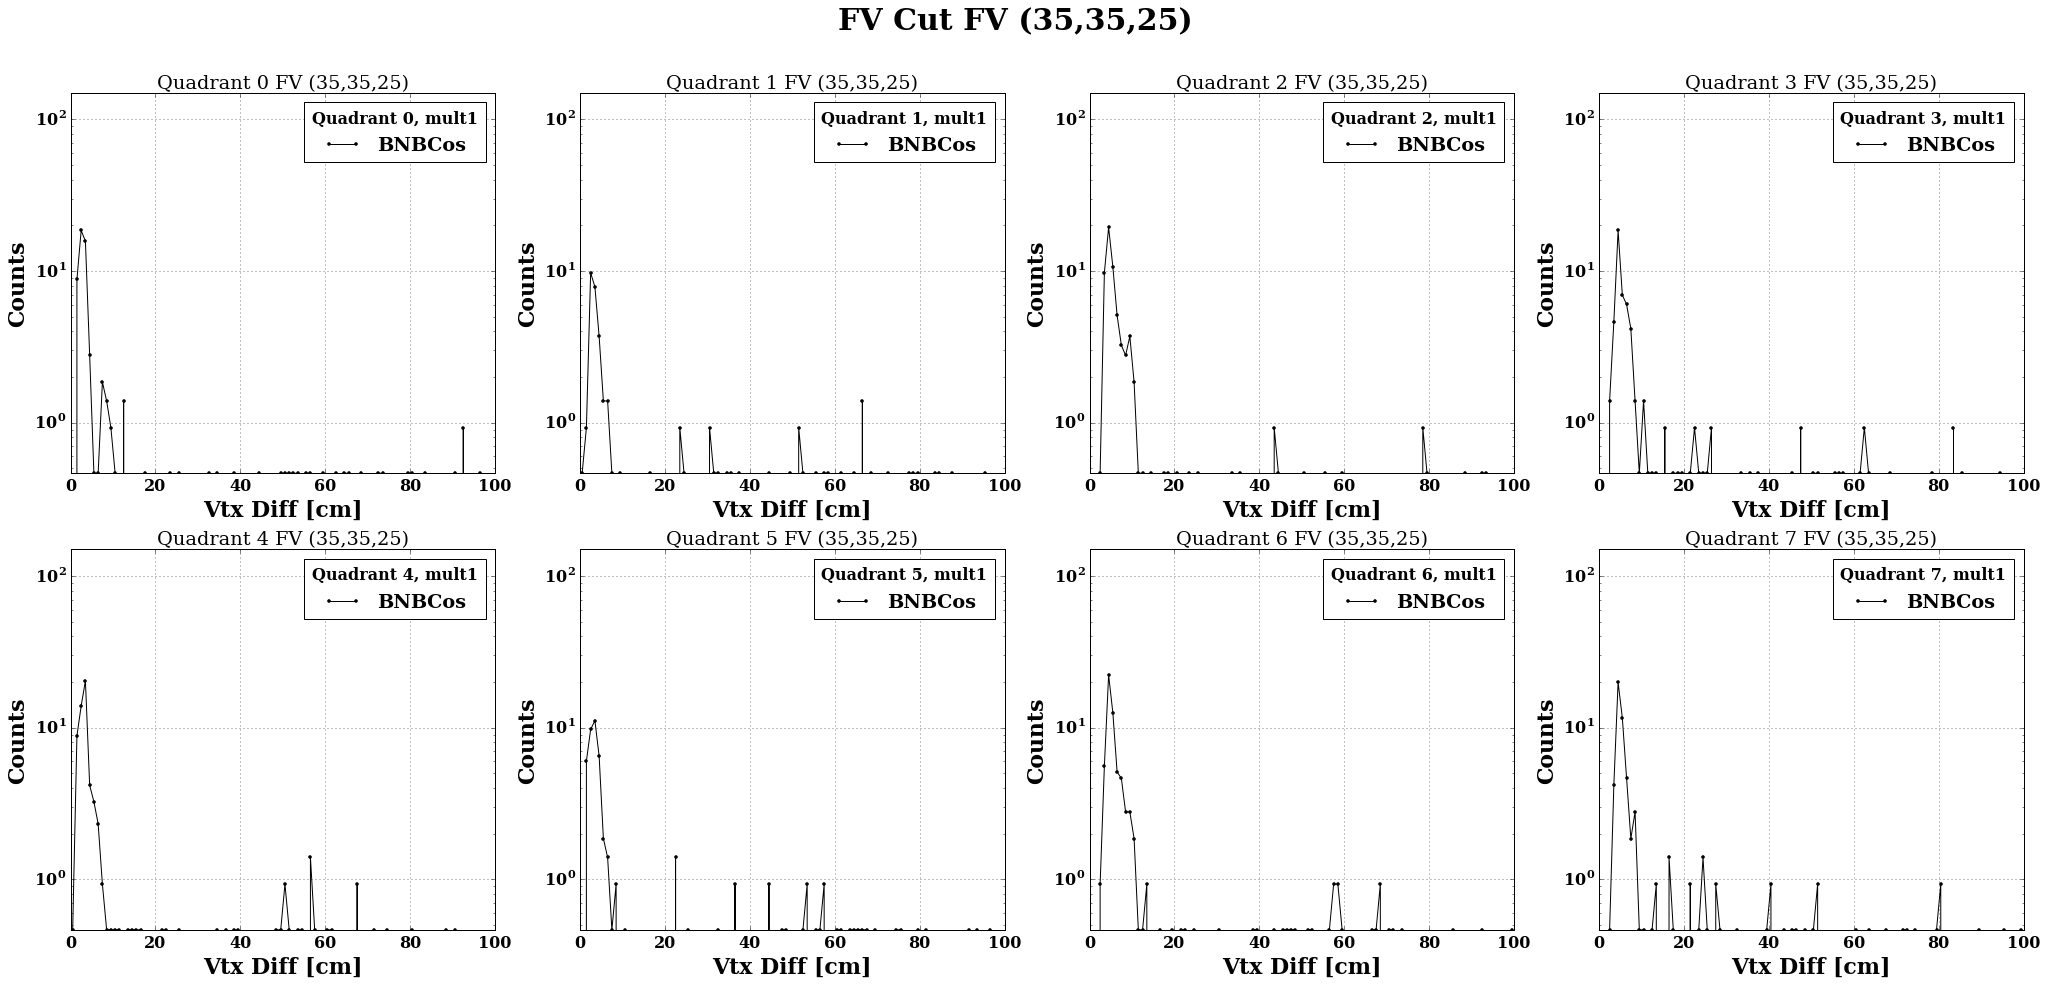

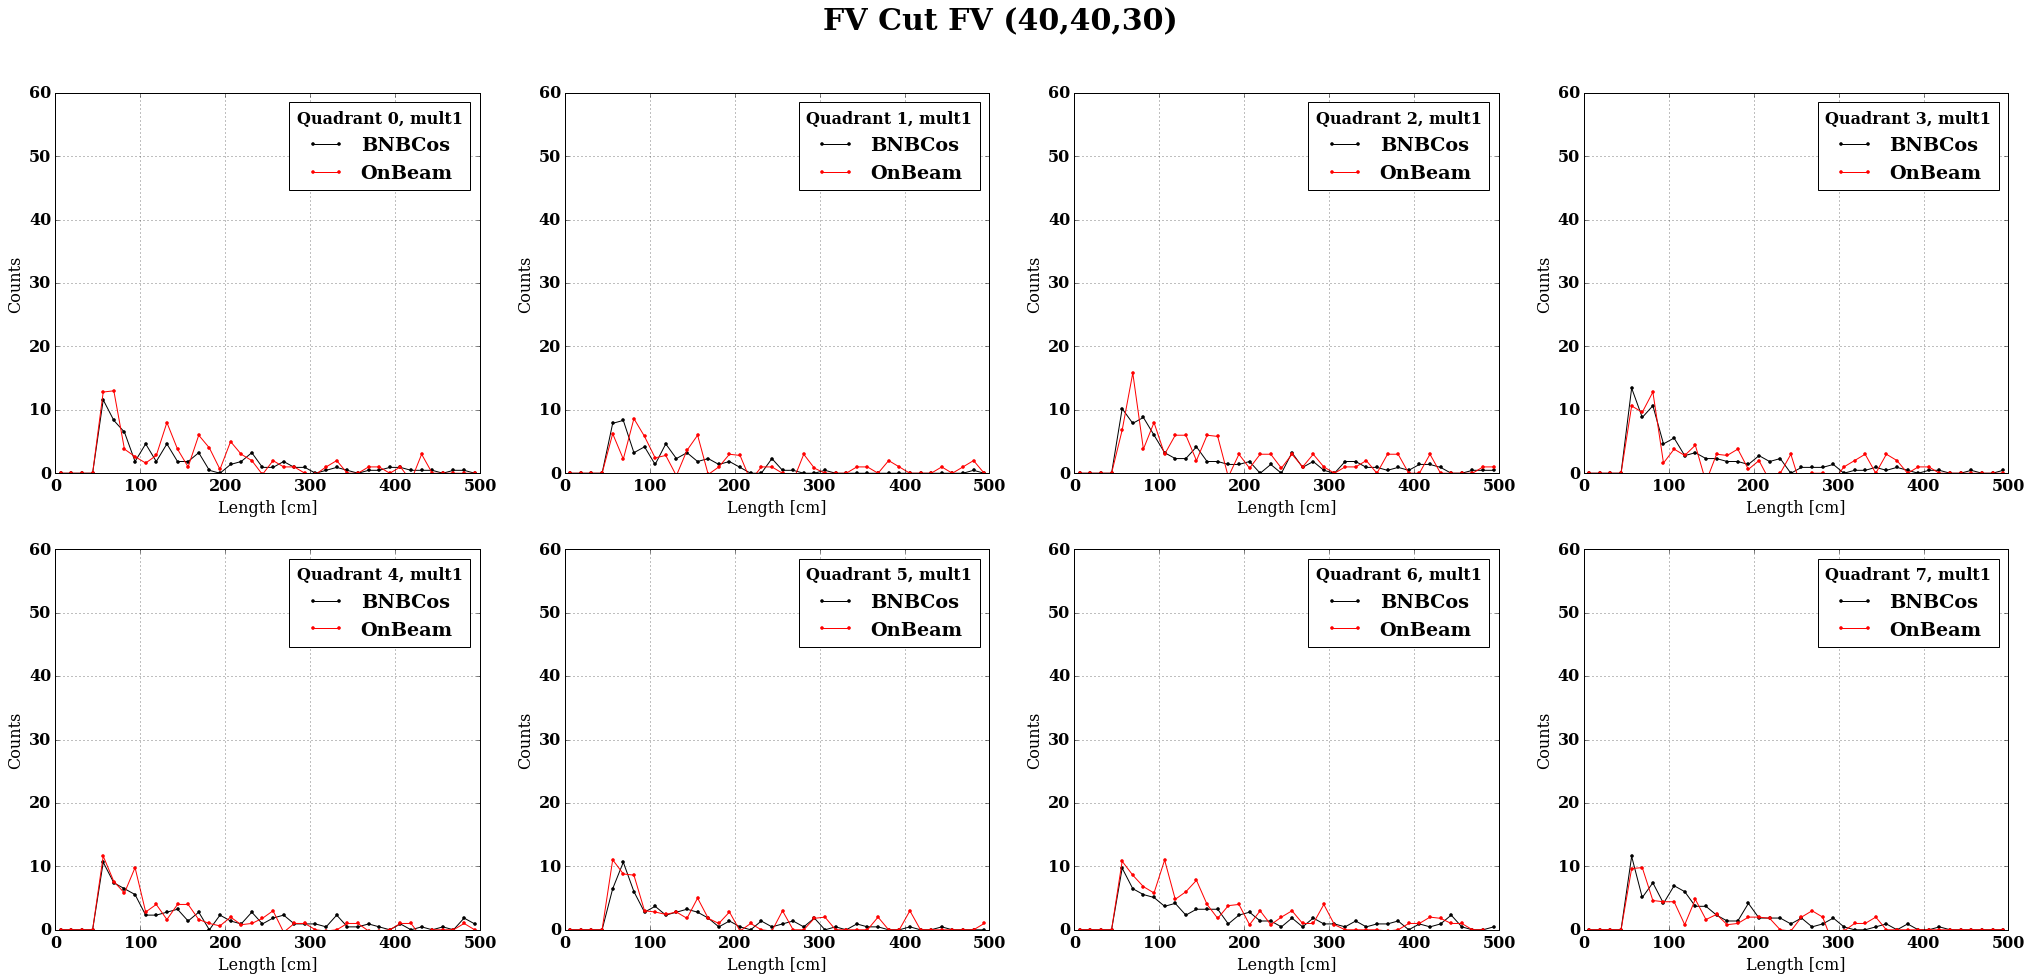

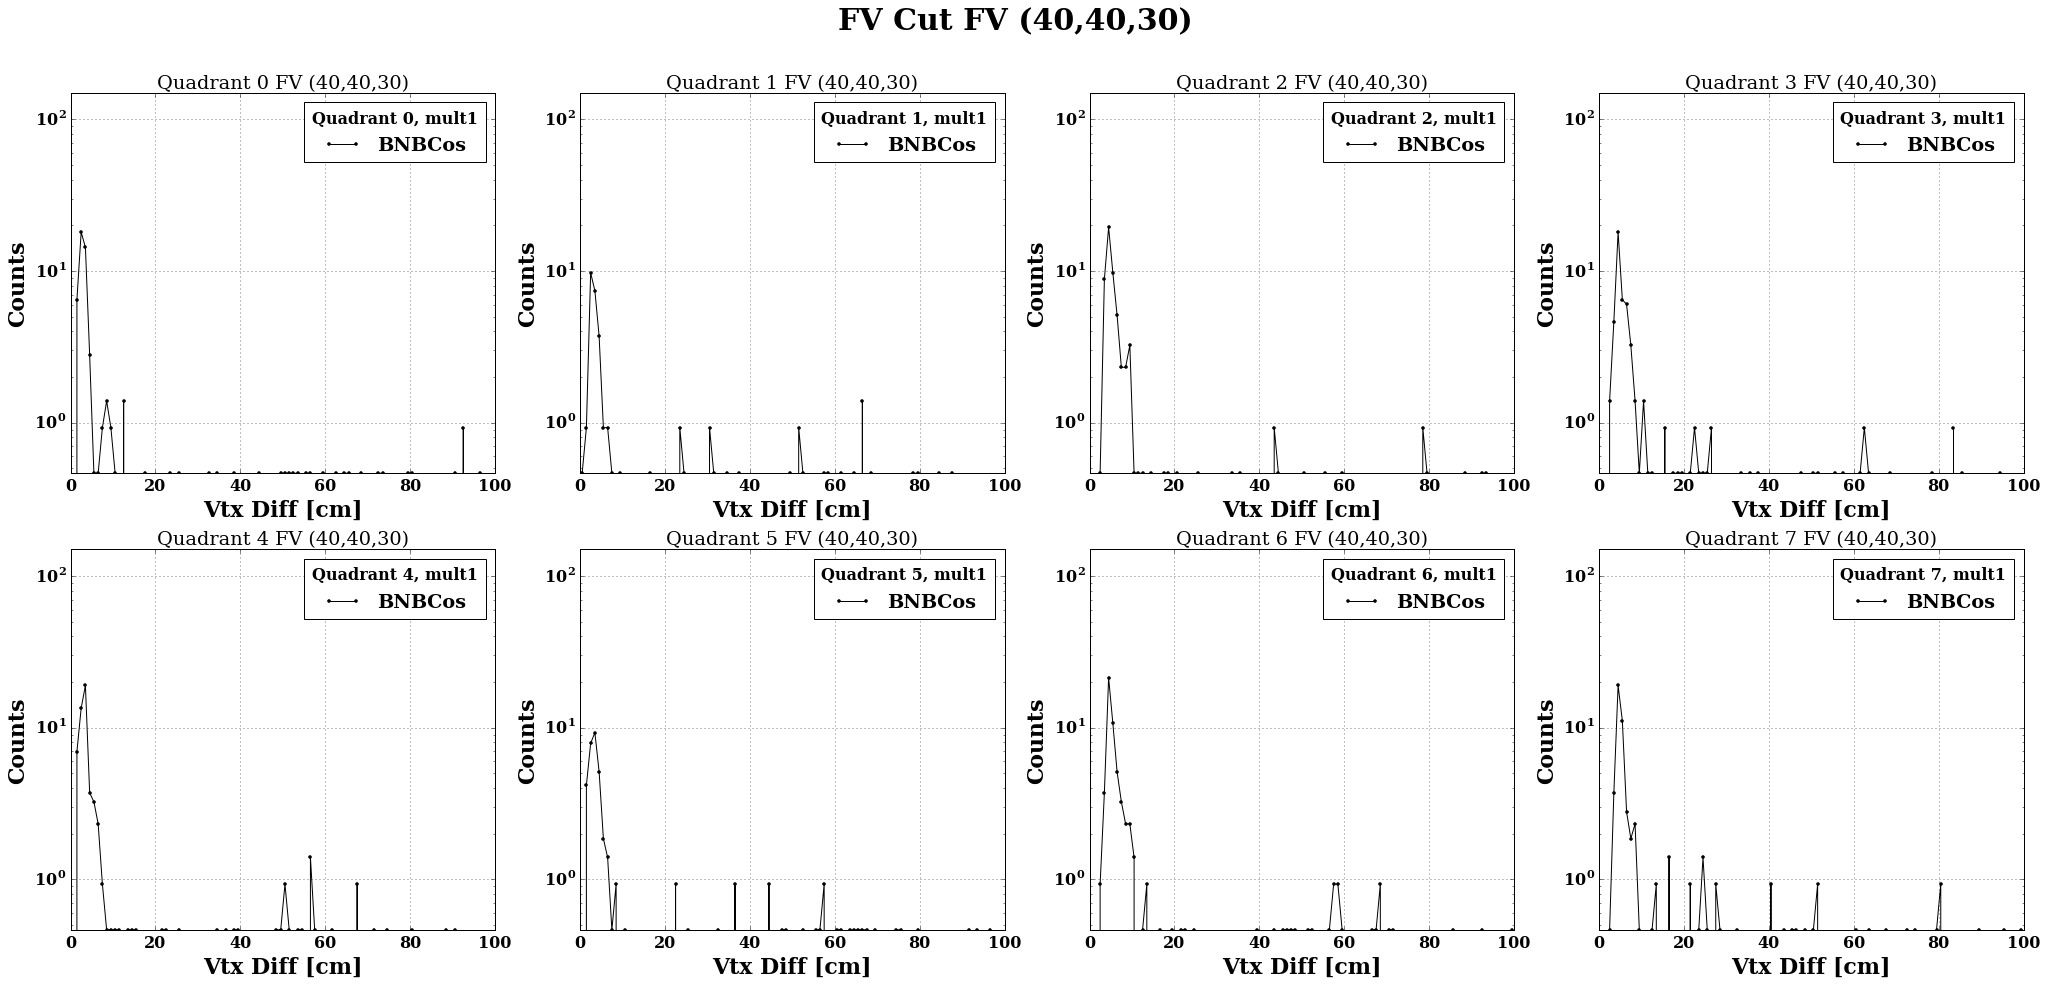

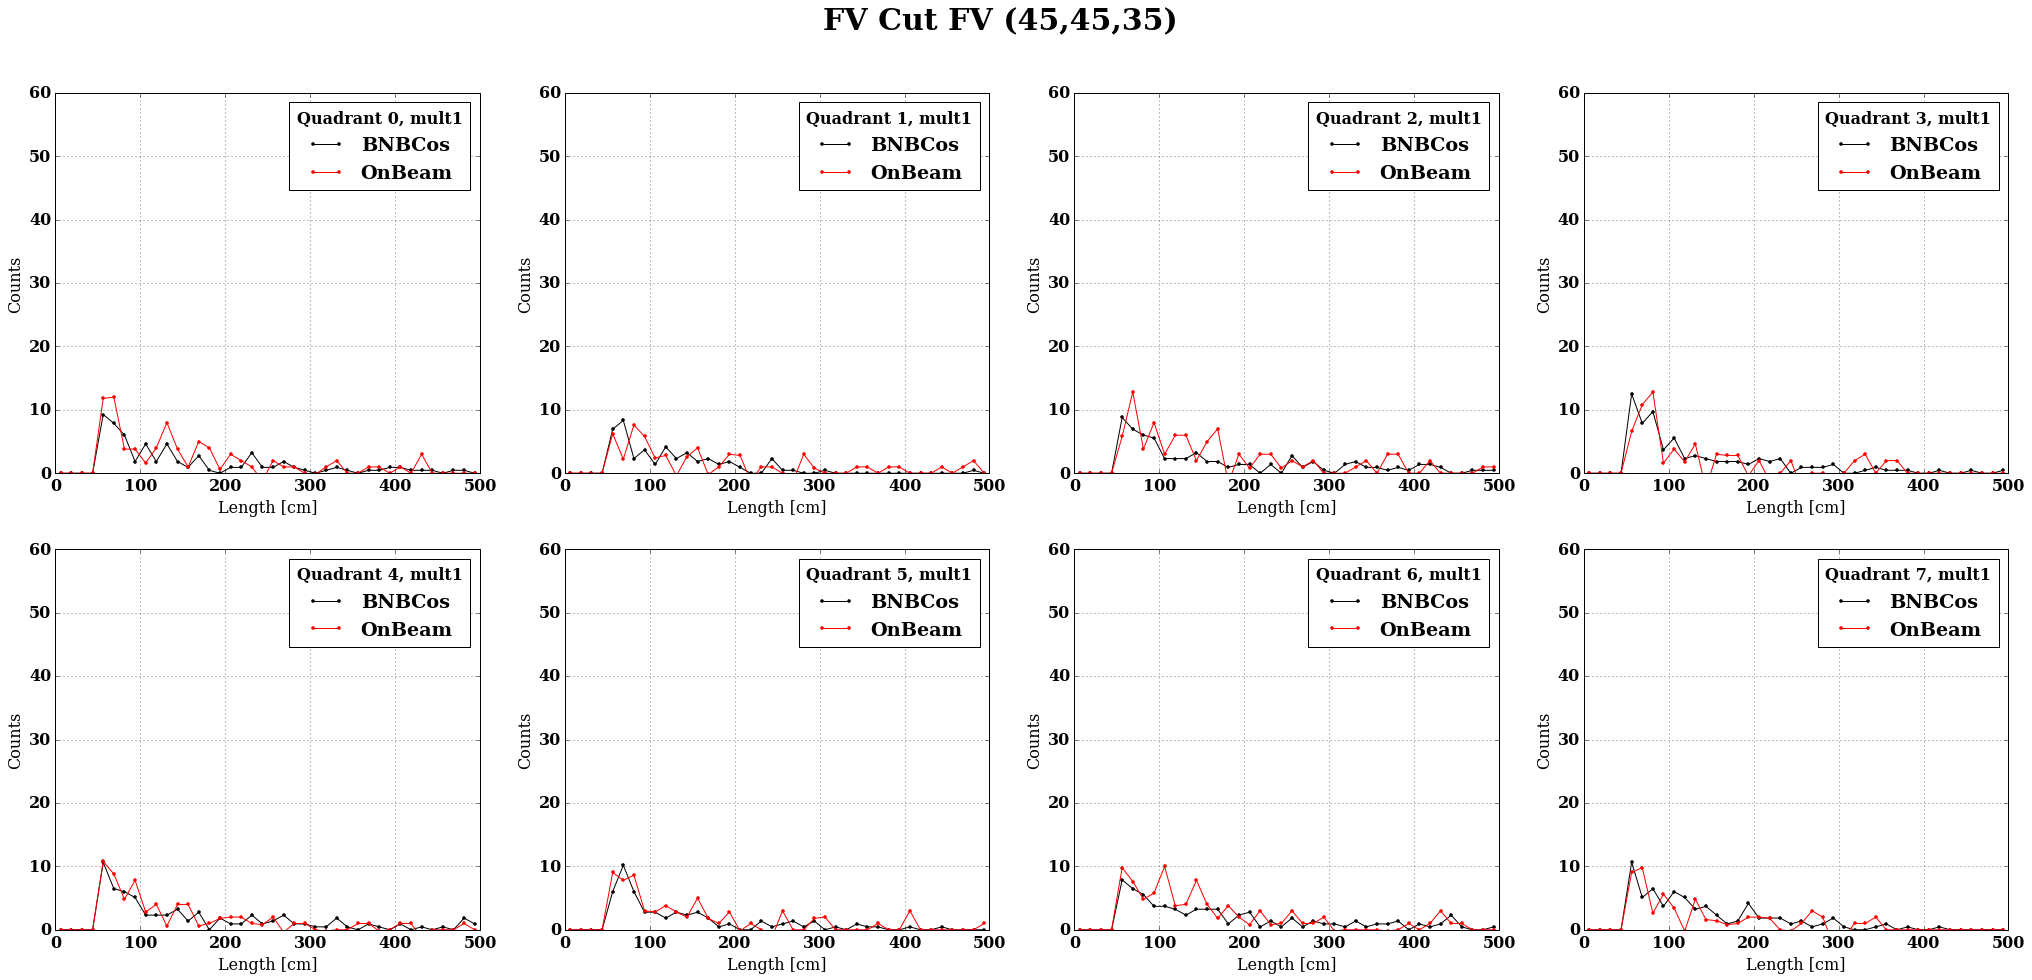

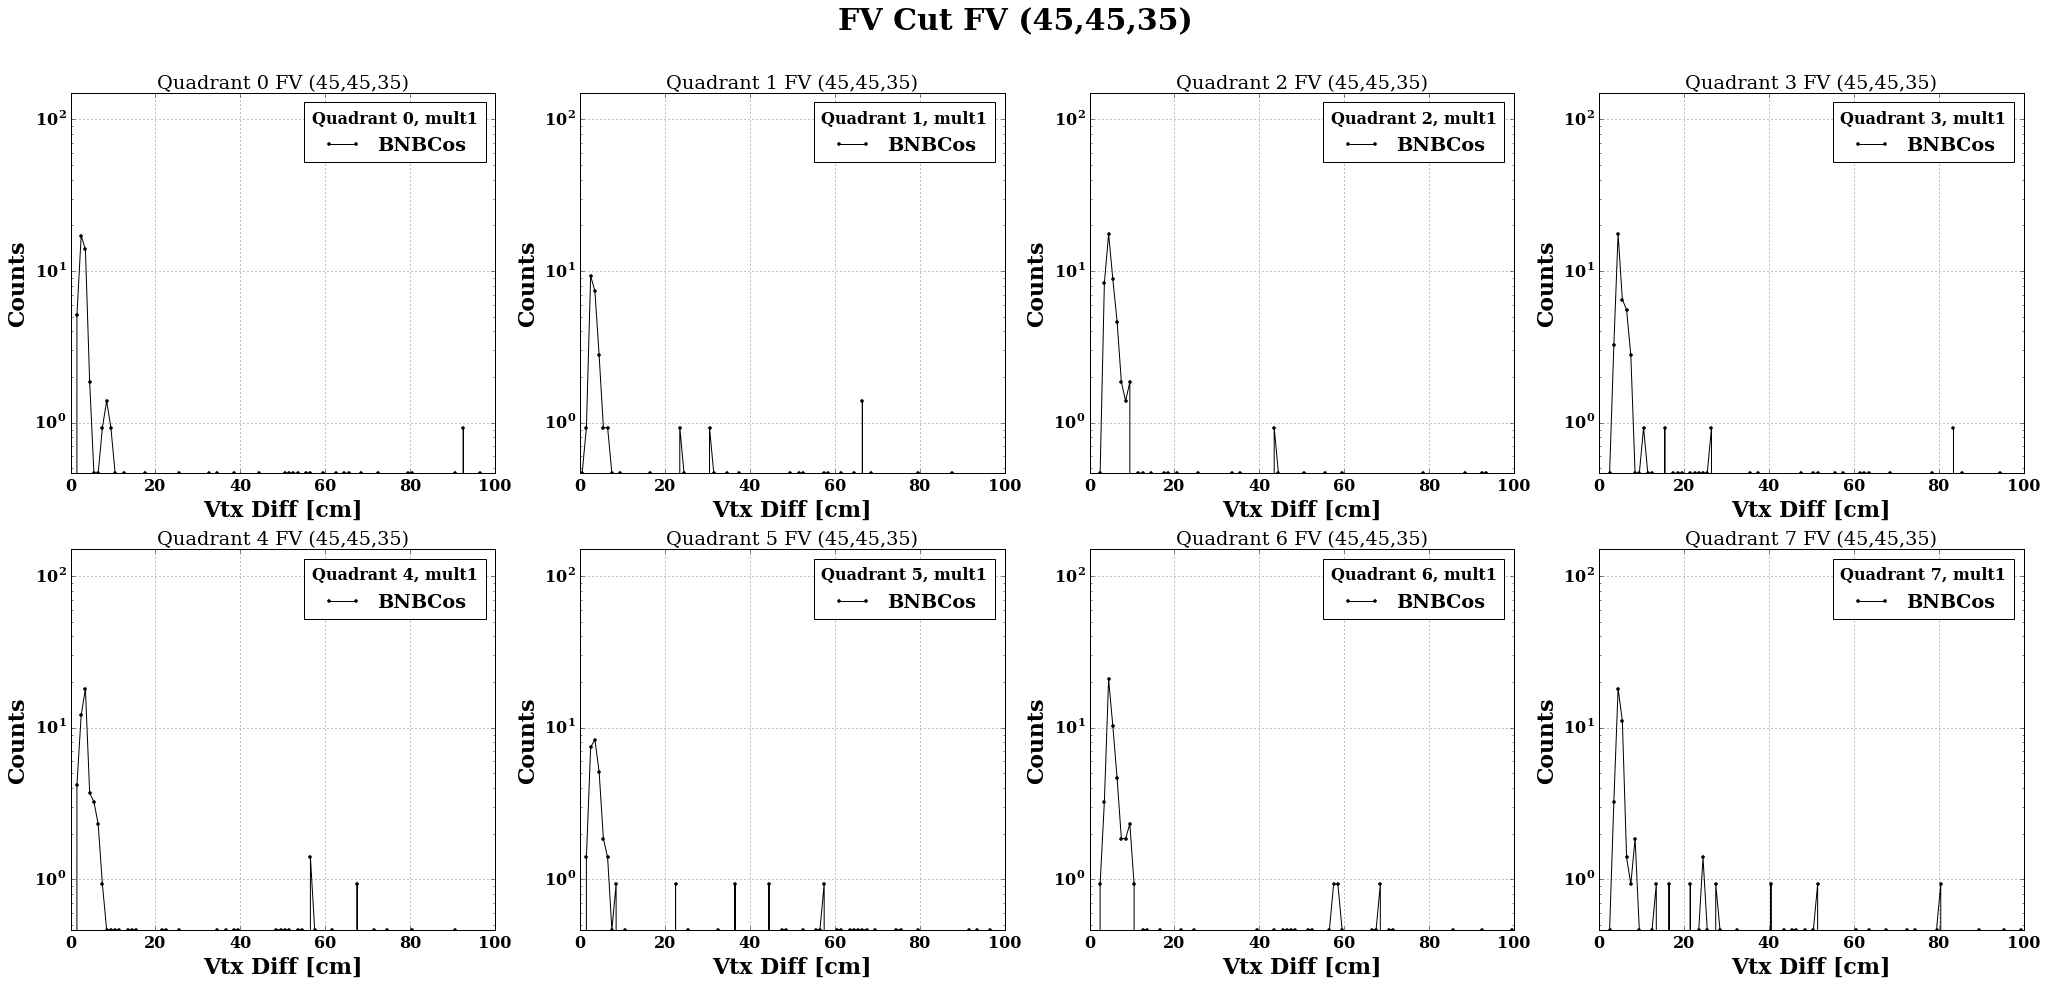

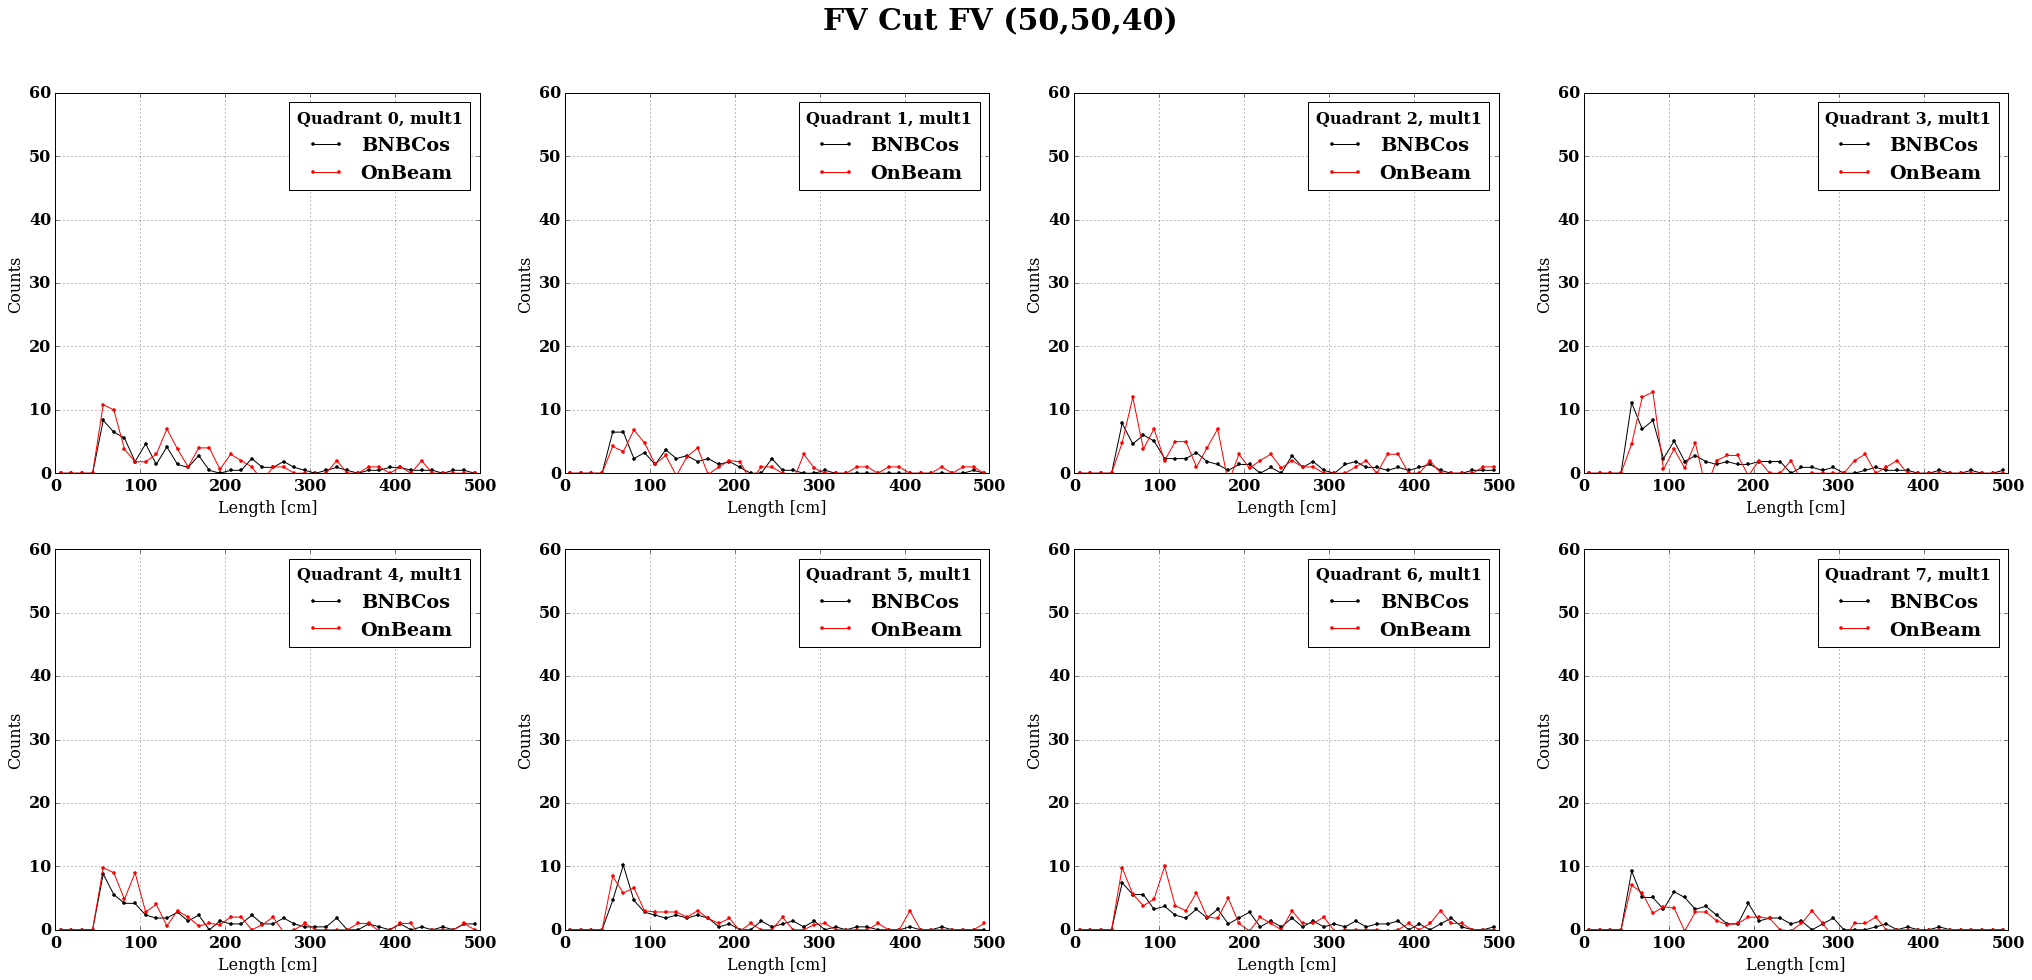

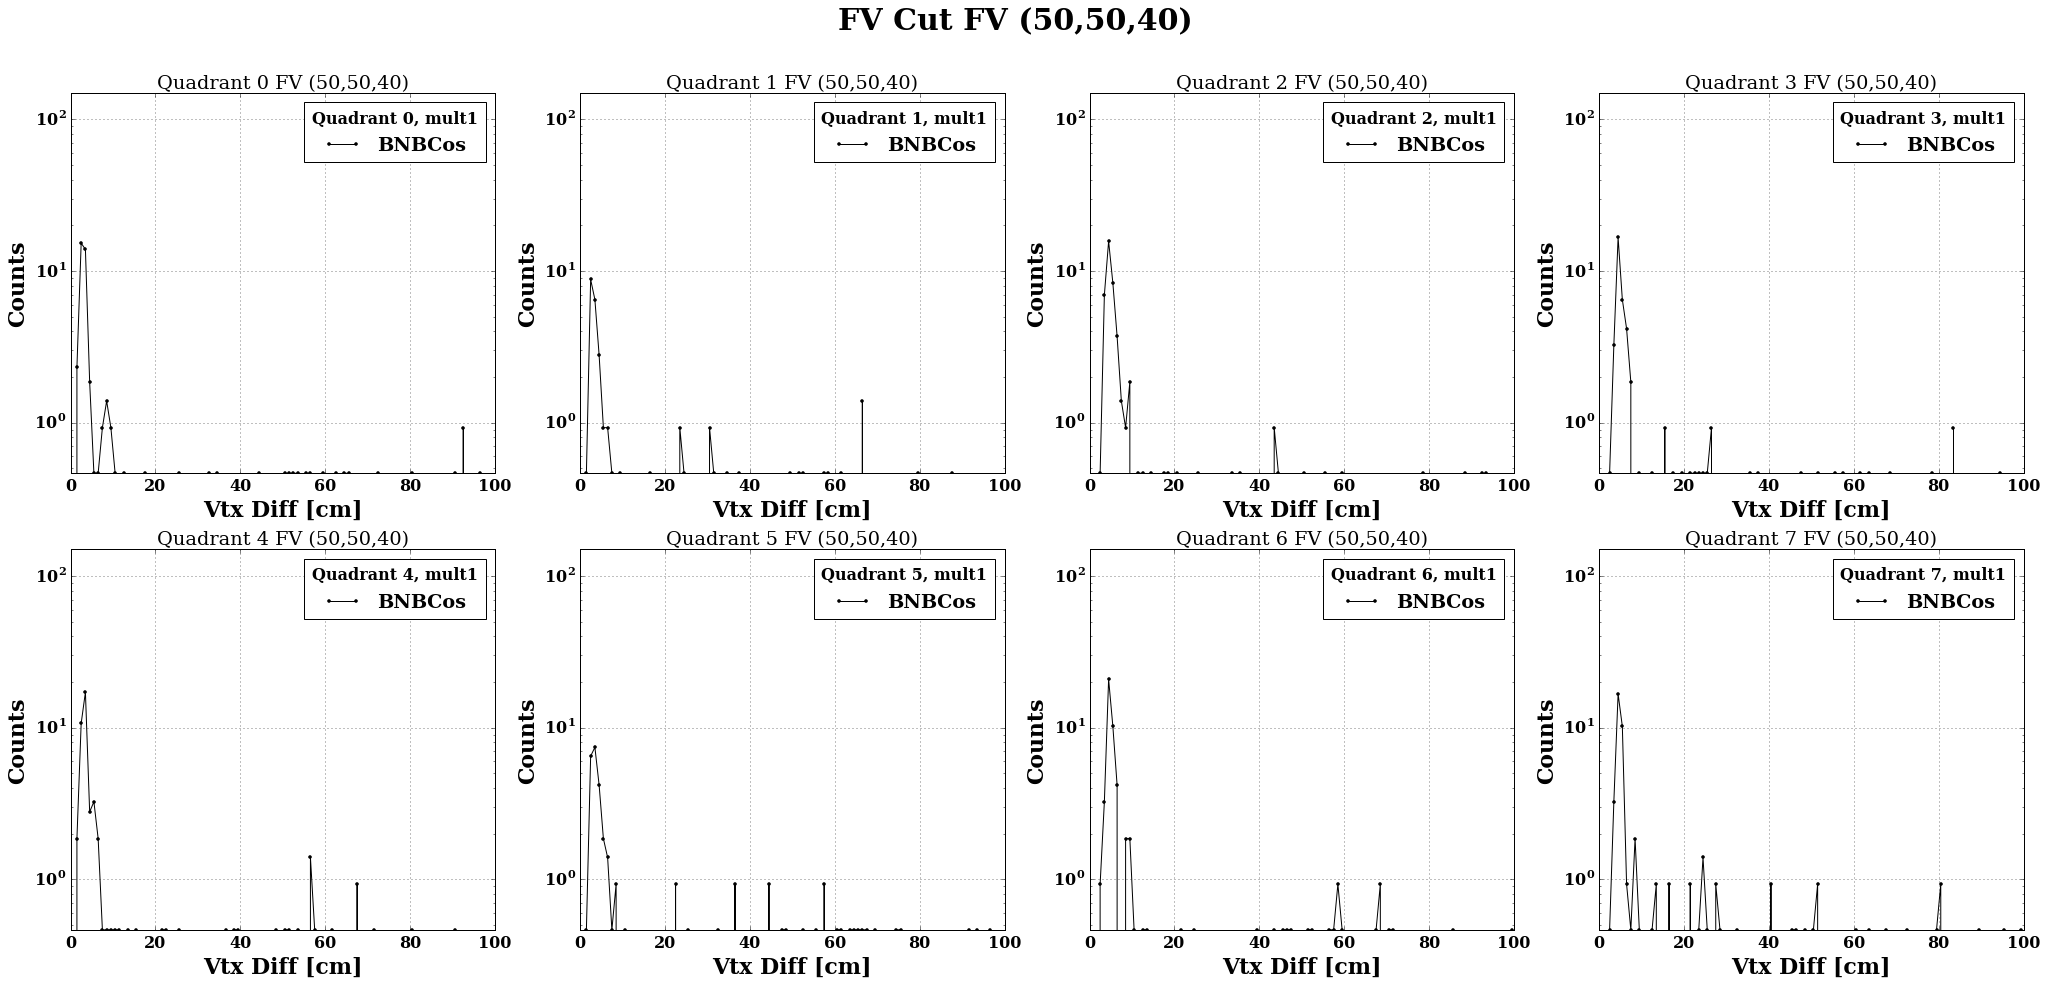

In [241]:
getFVRegions(df_beam_mult1, df_offbeam_mult1, df_bnbcos_mult1,name='mult1')

In [ ]:
getRegions(df_beam_multgt1, df_offbeam_multgt1, df_bnbcos_multgt1,name='multgt1')

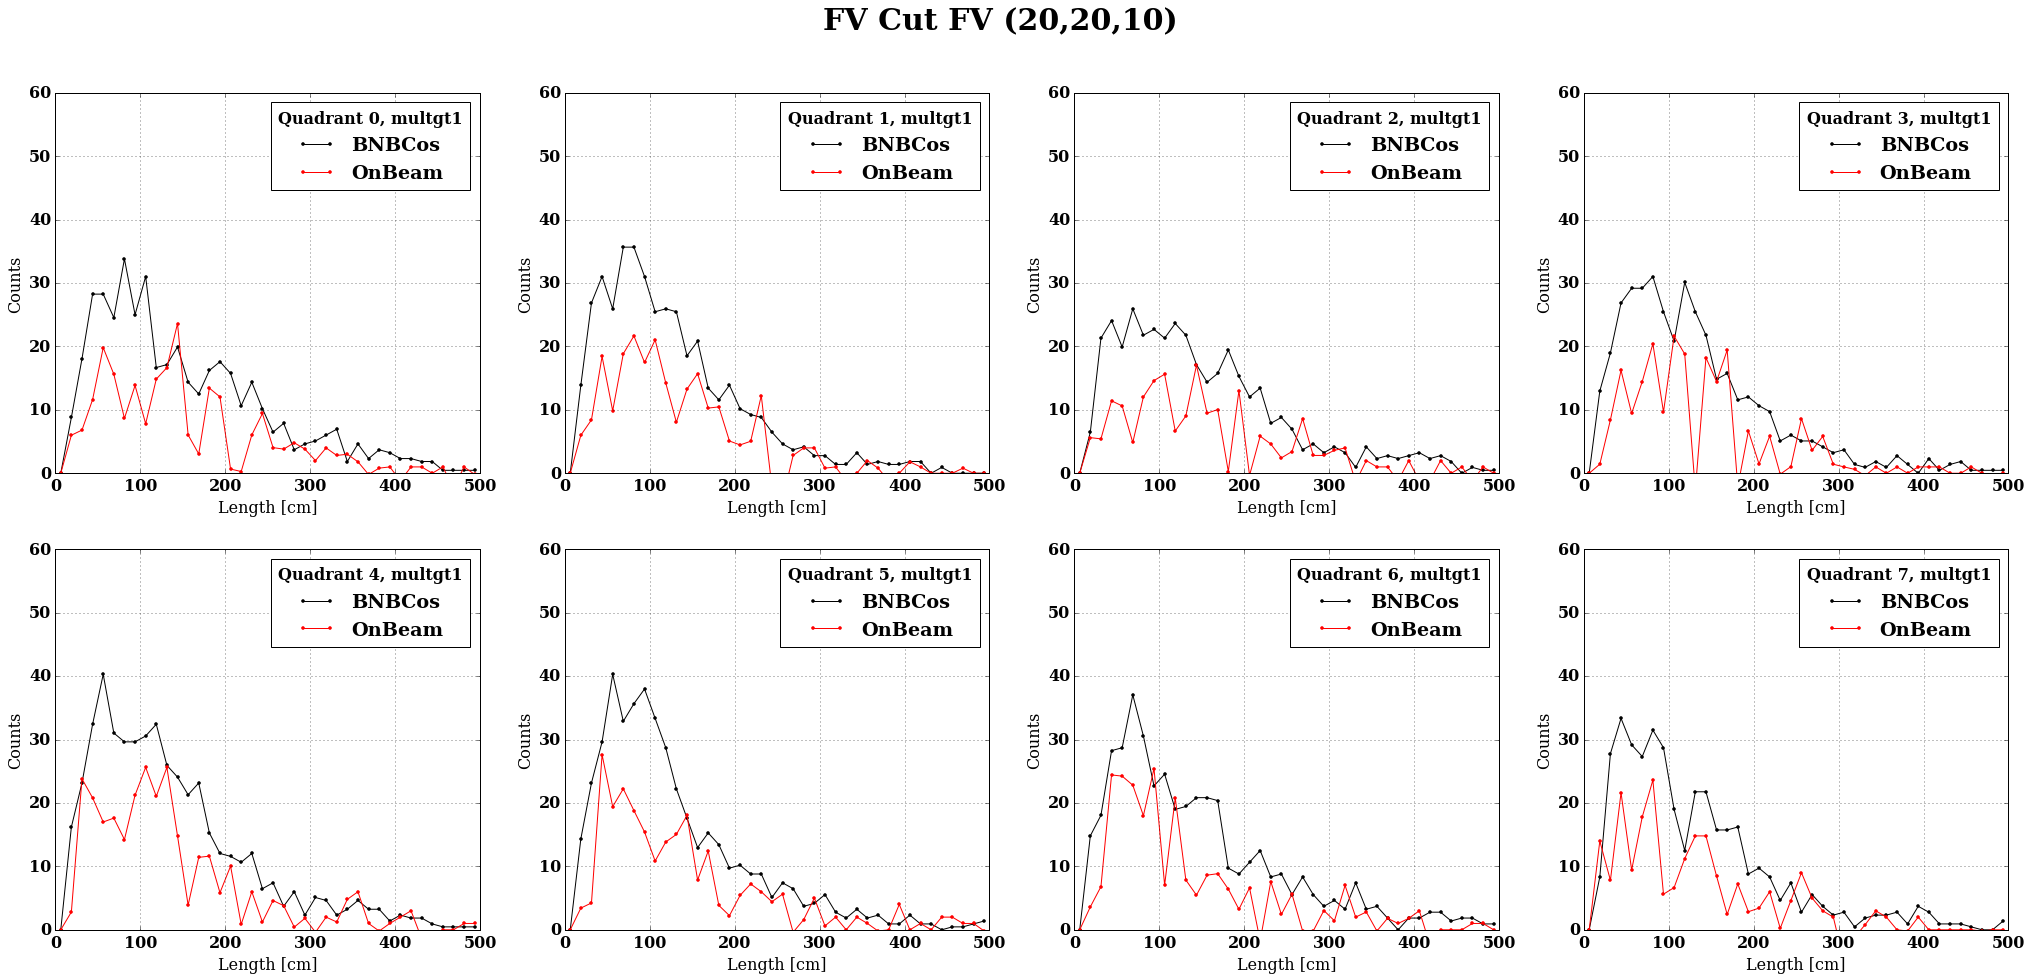

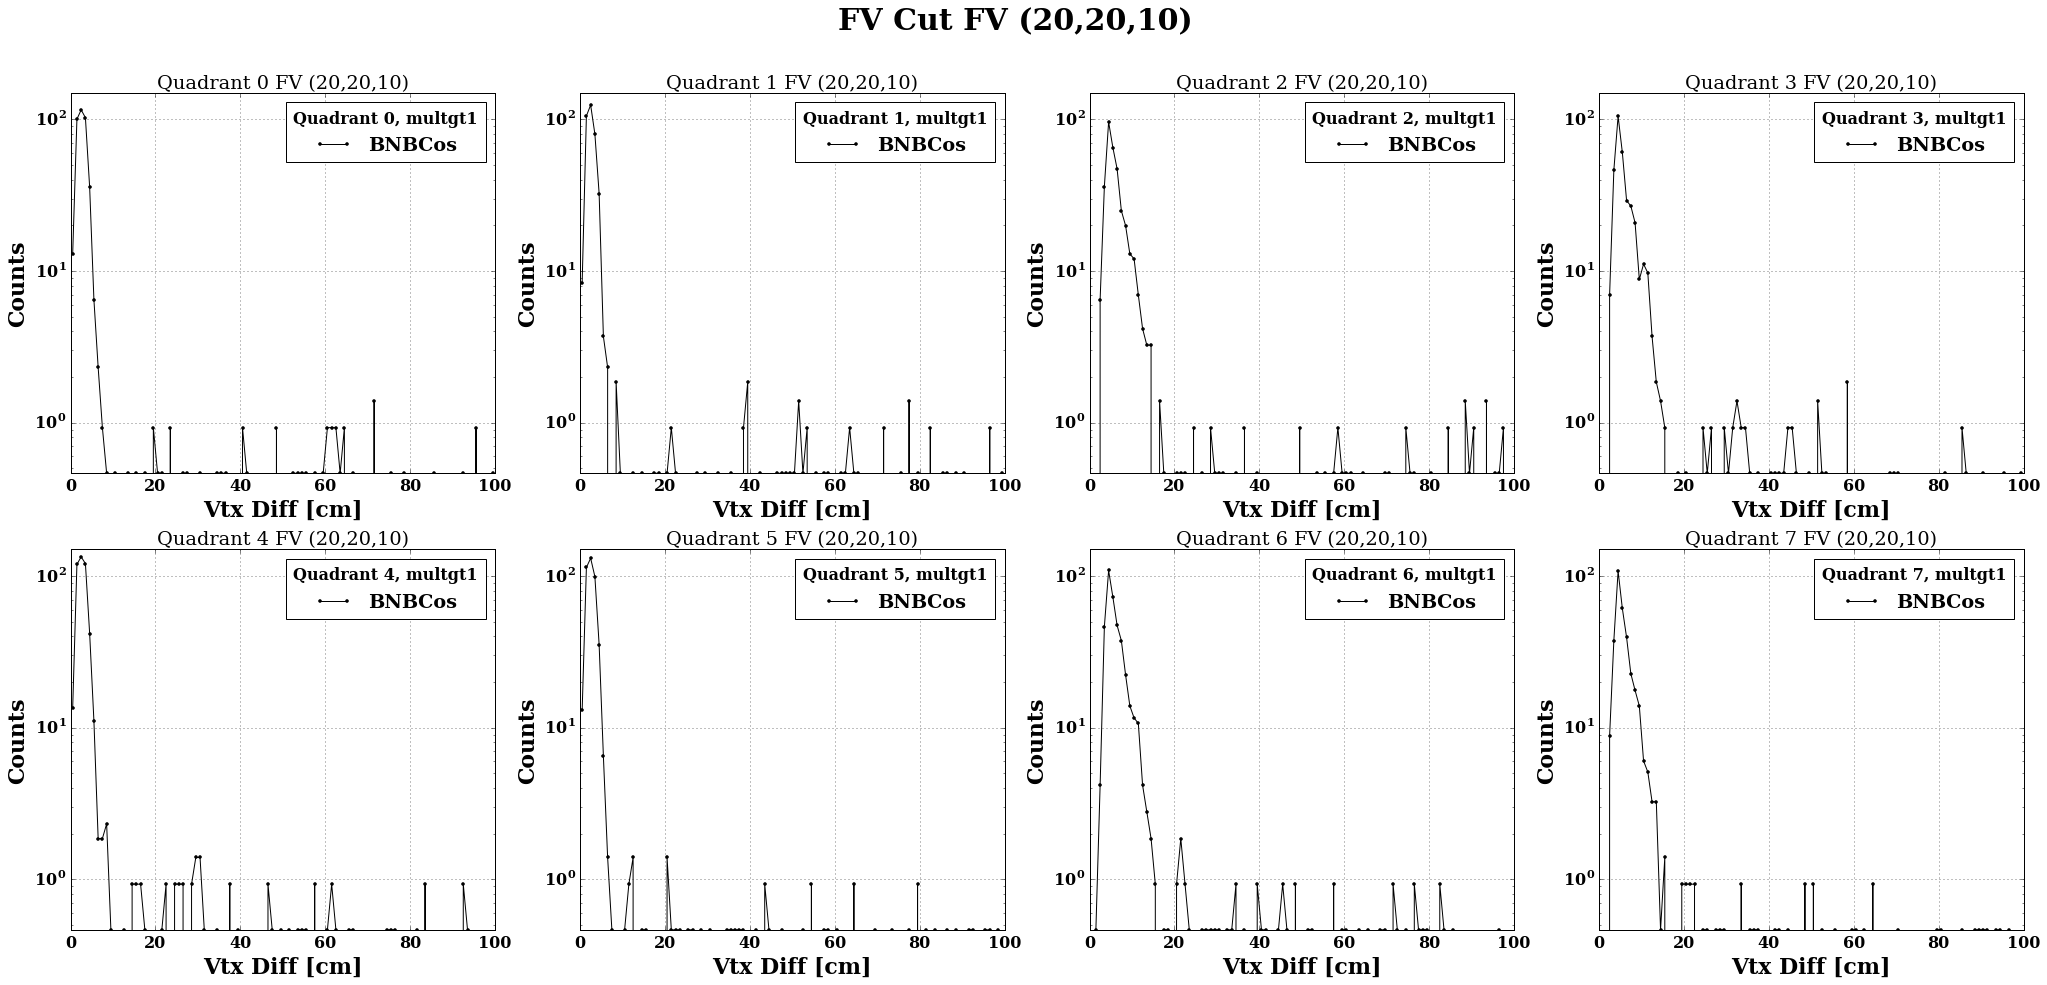

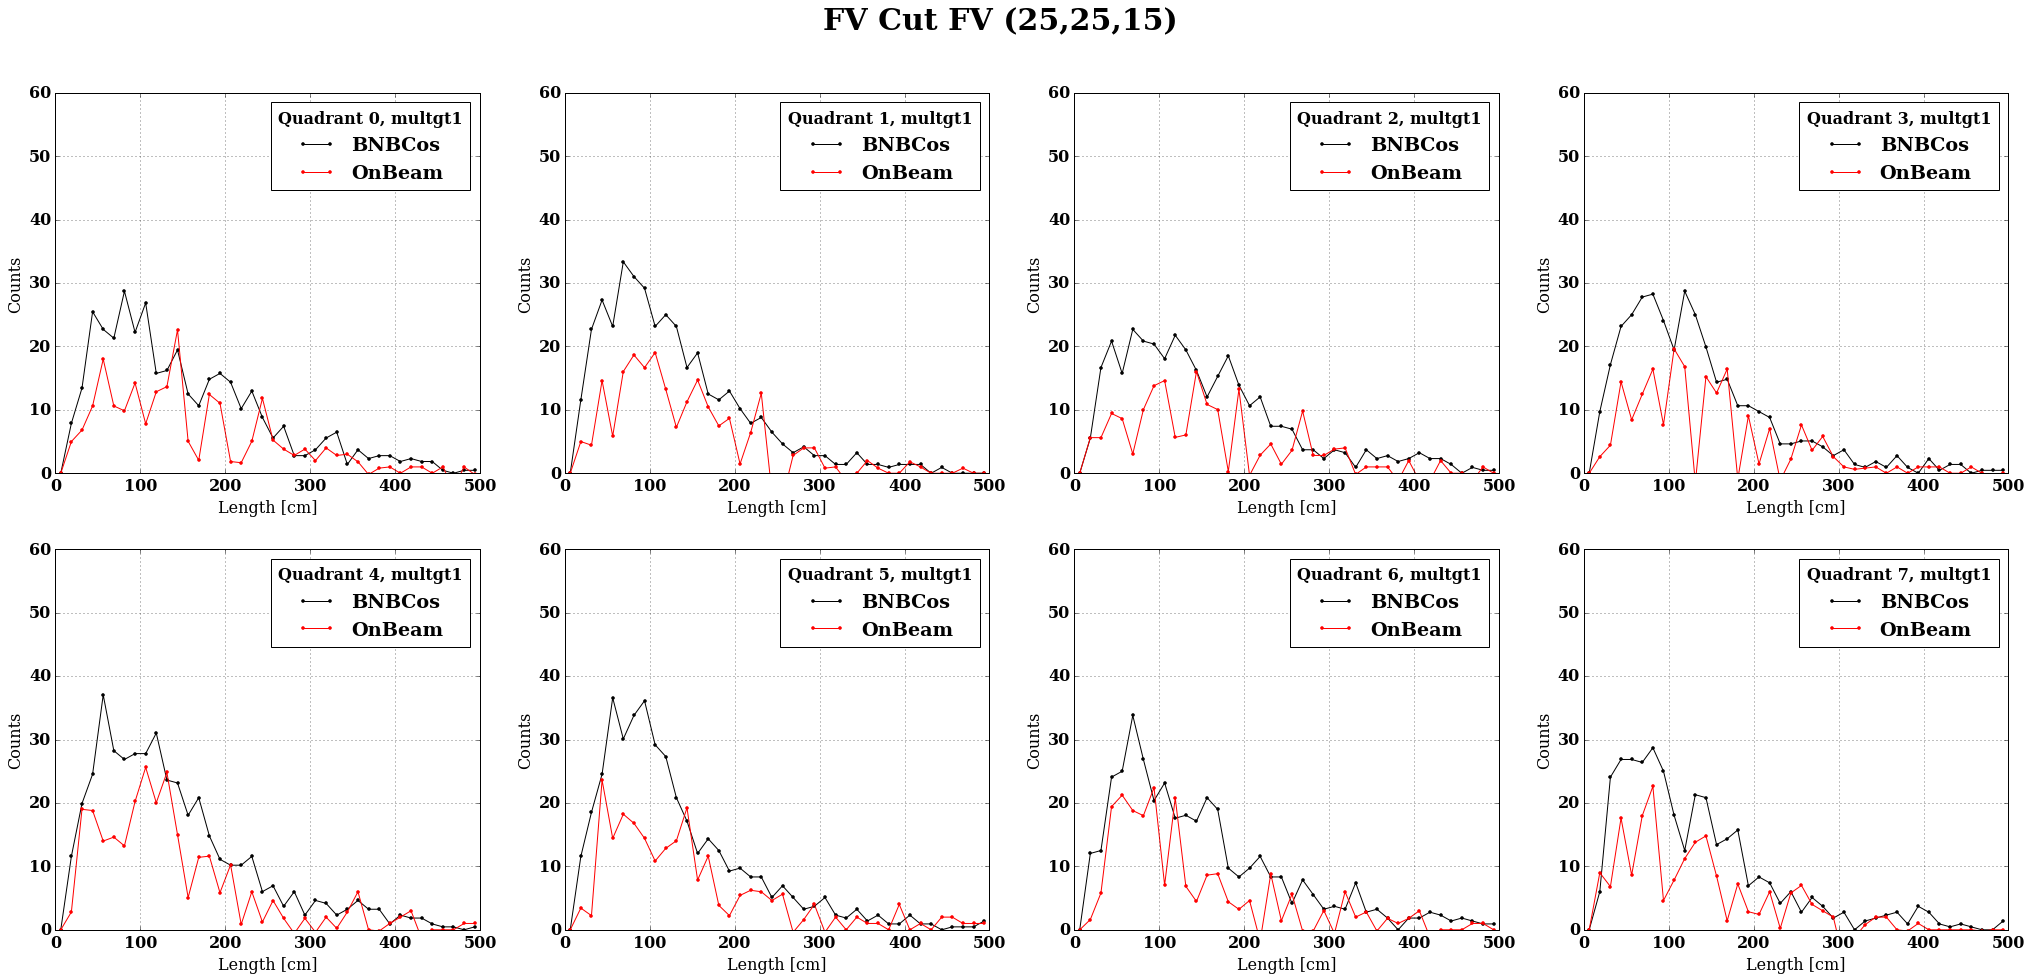

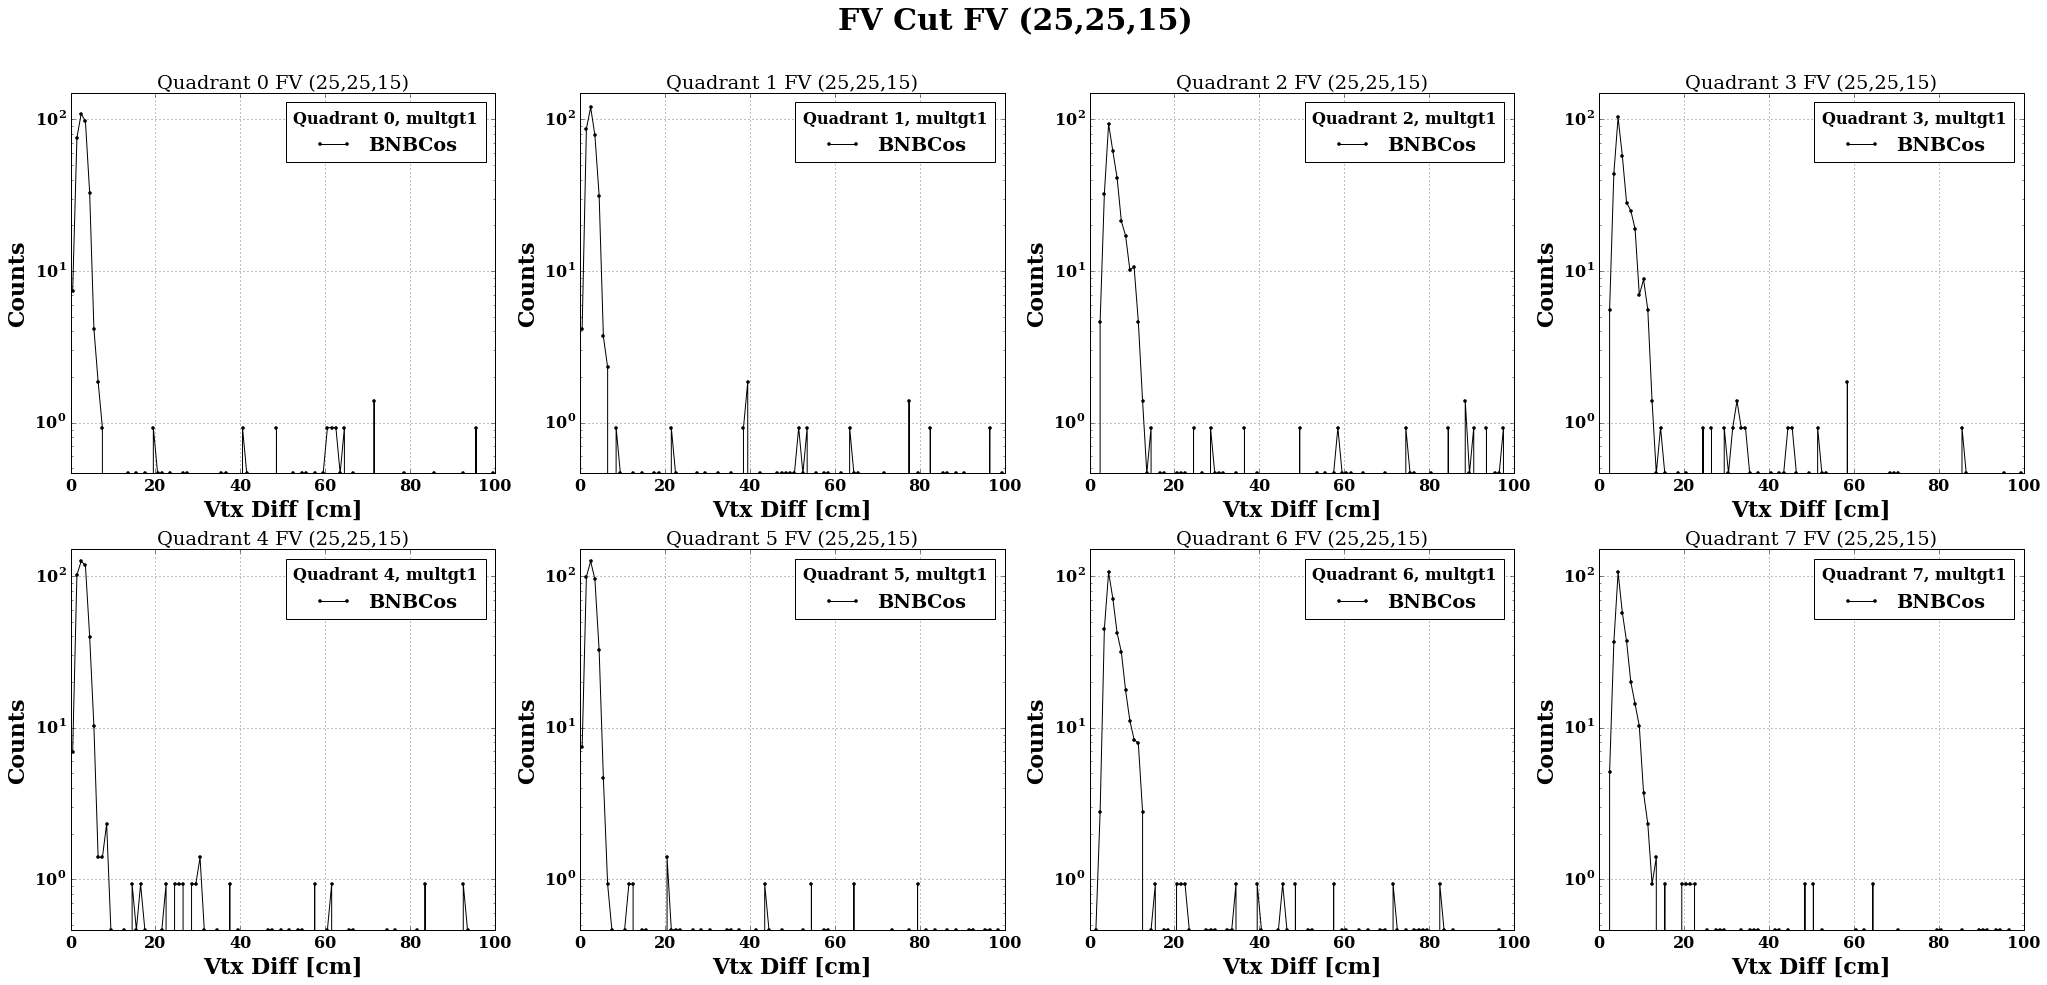

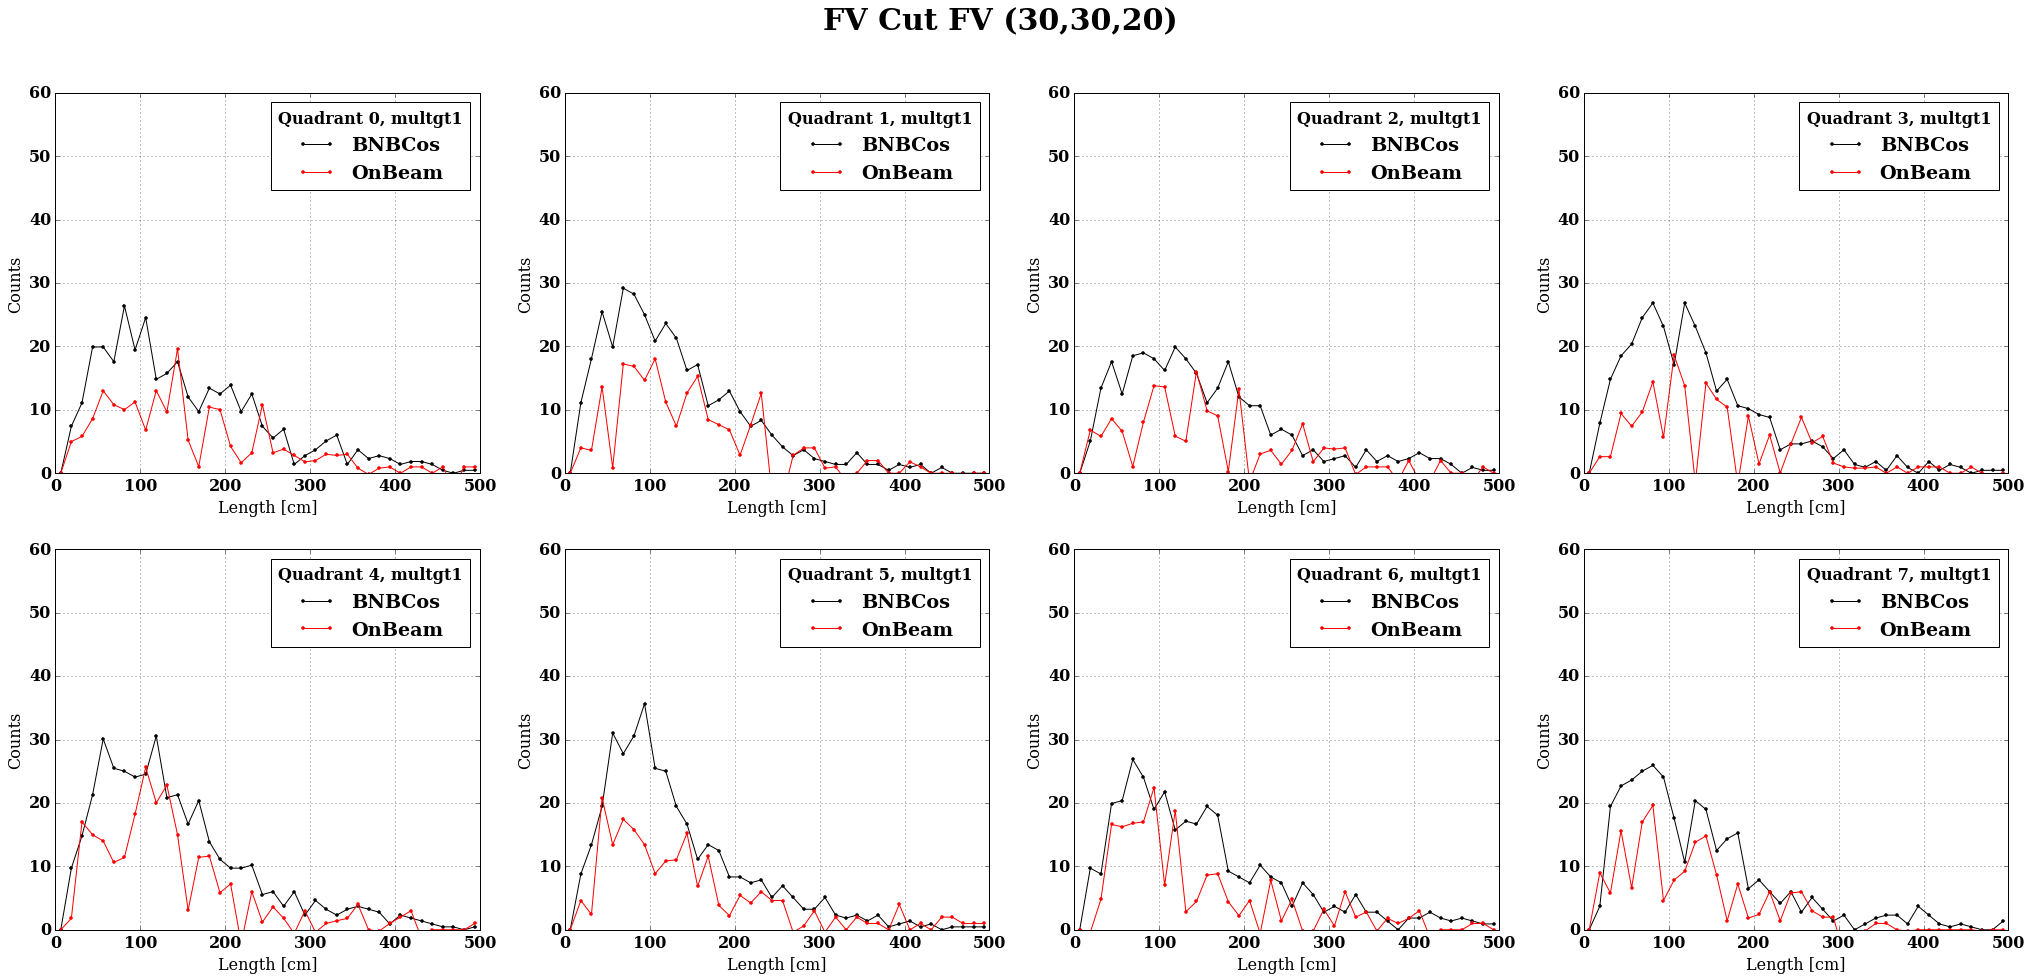

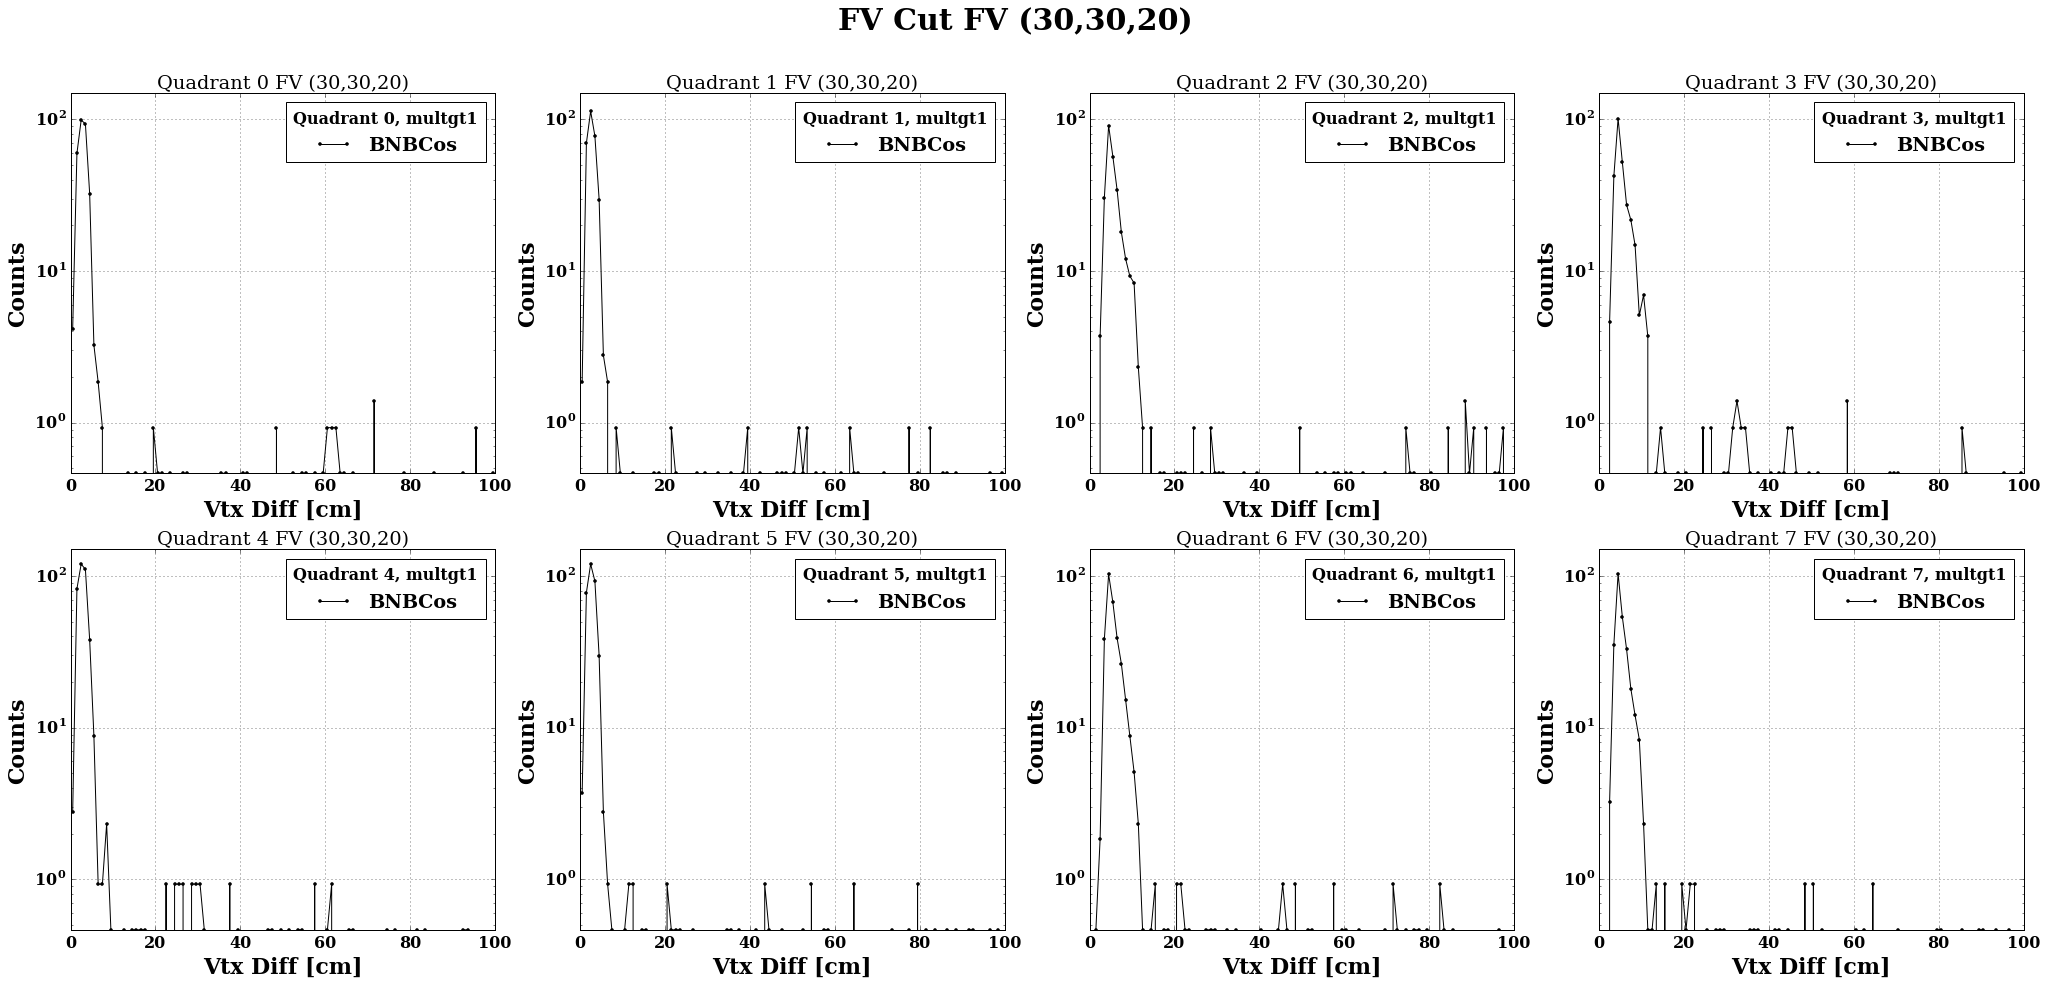

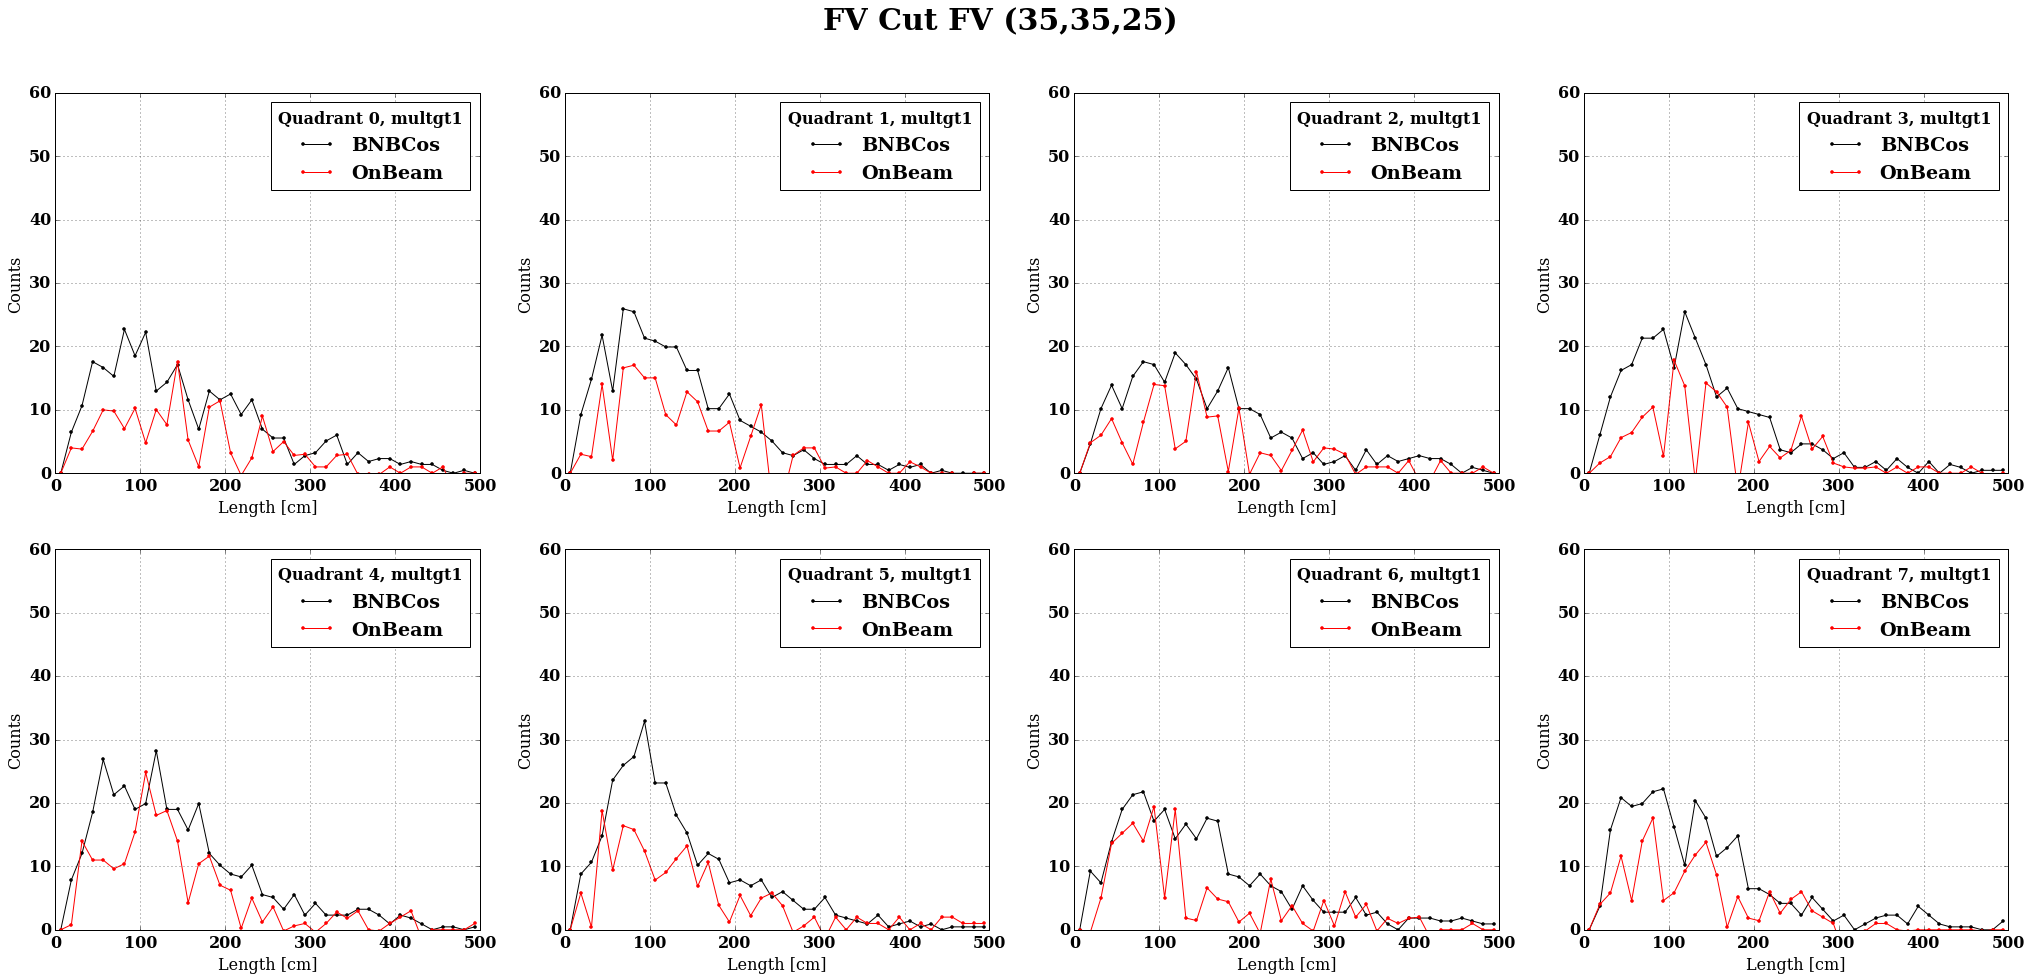

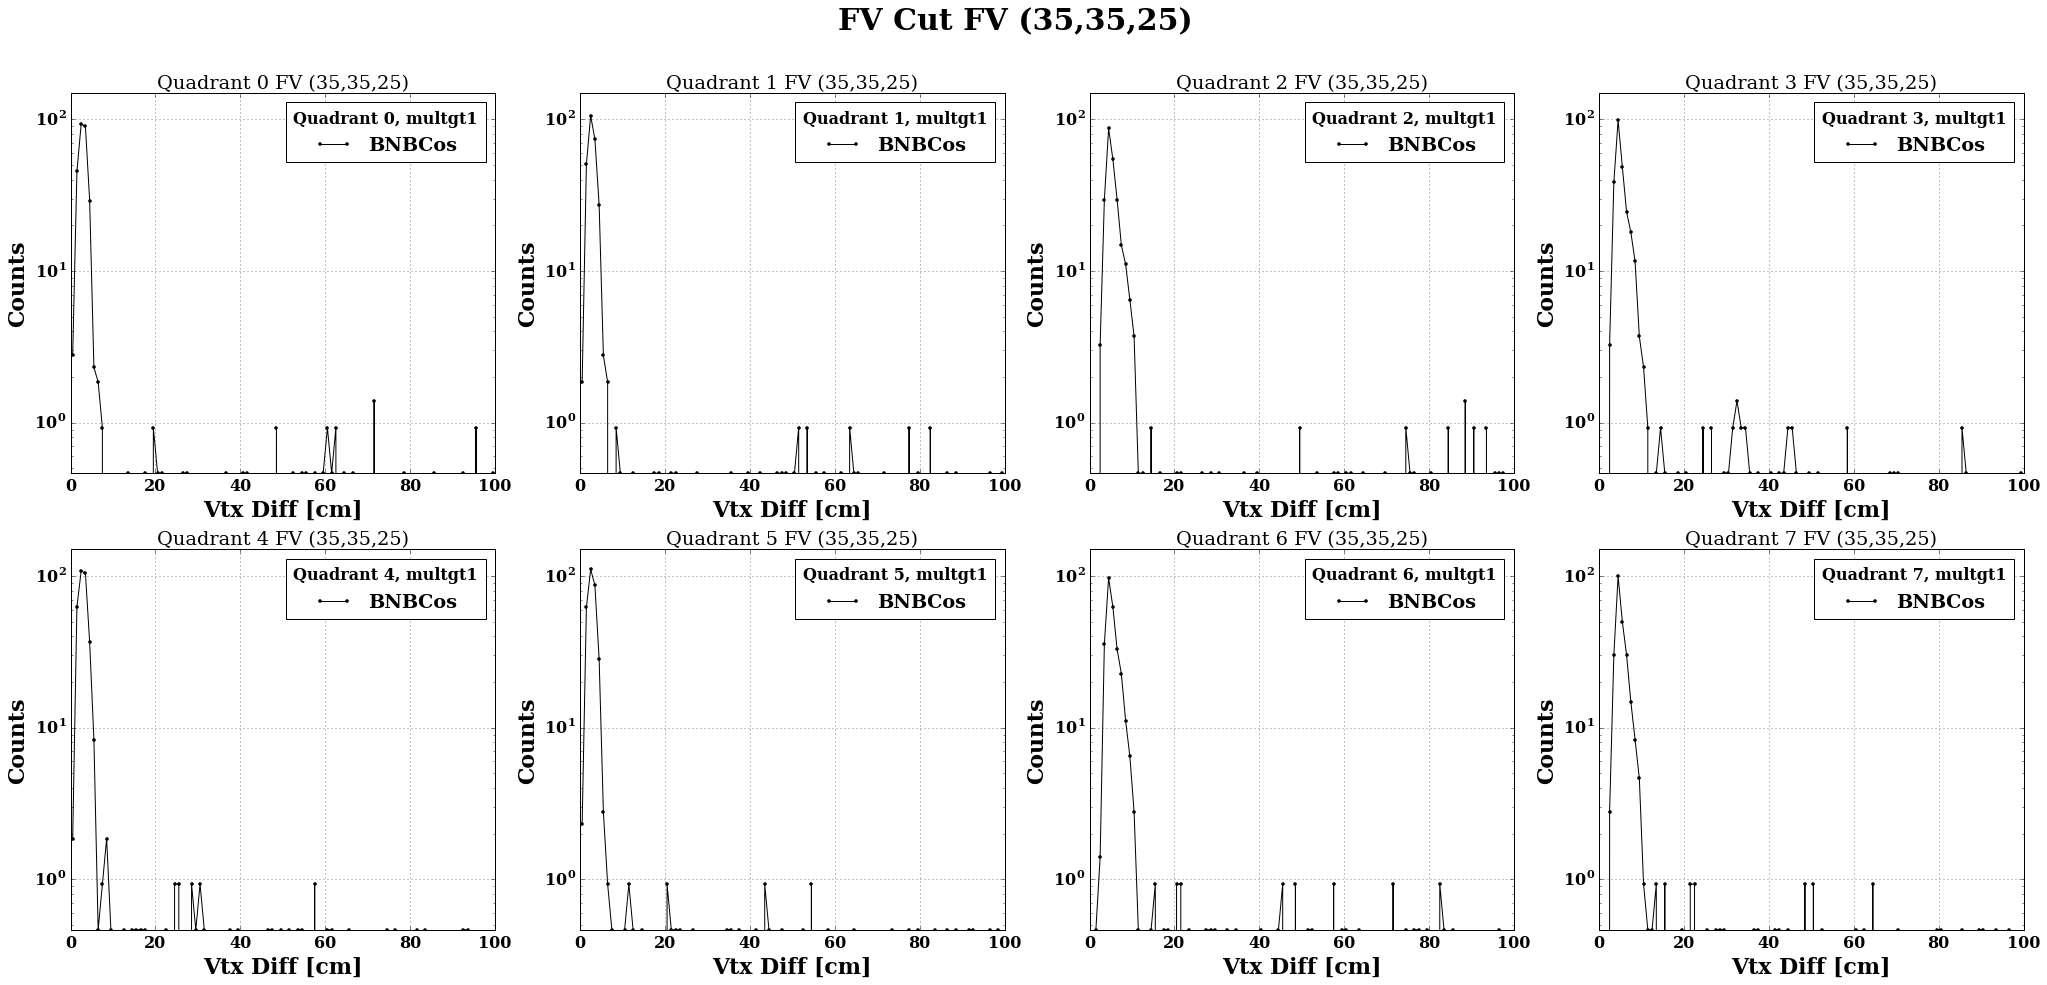

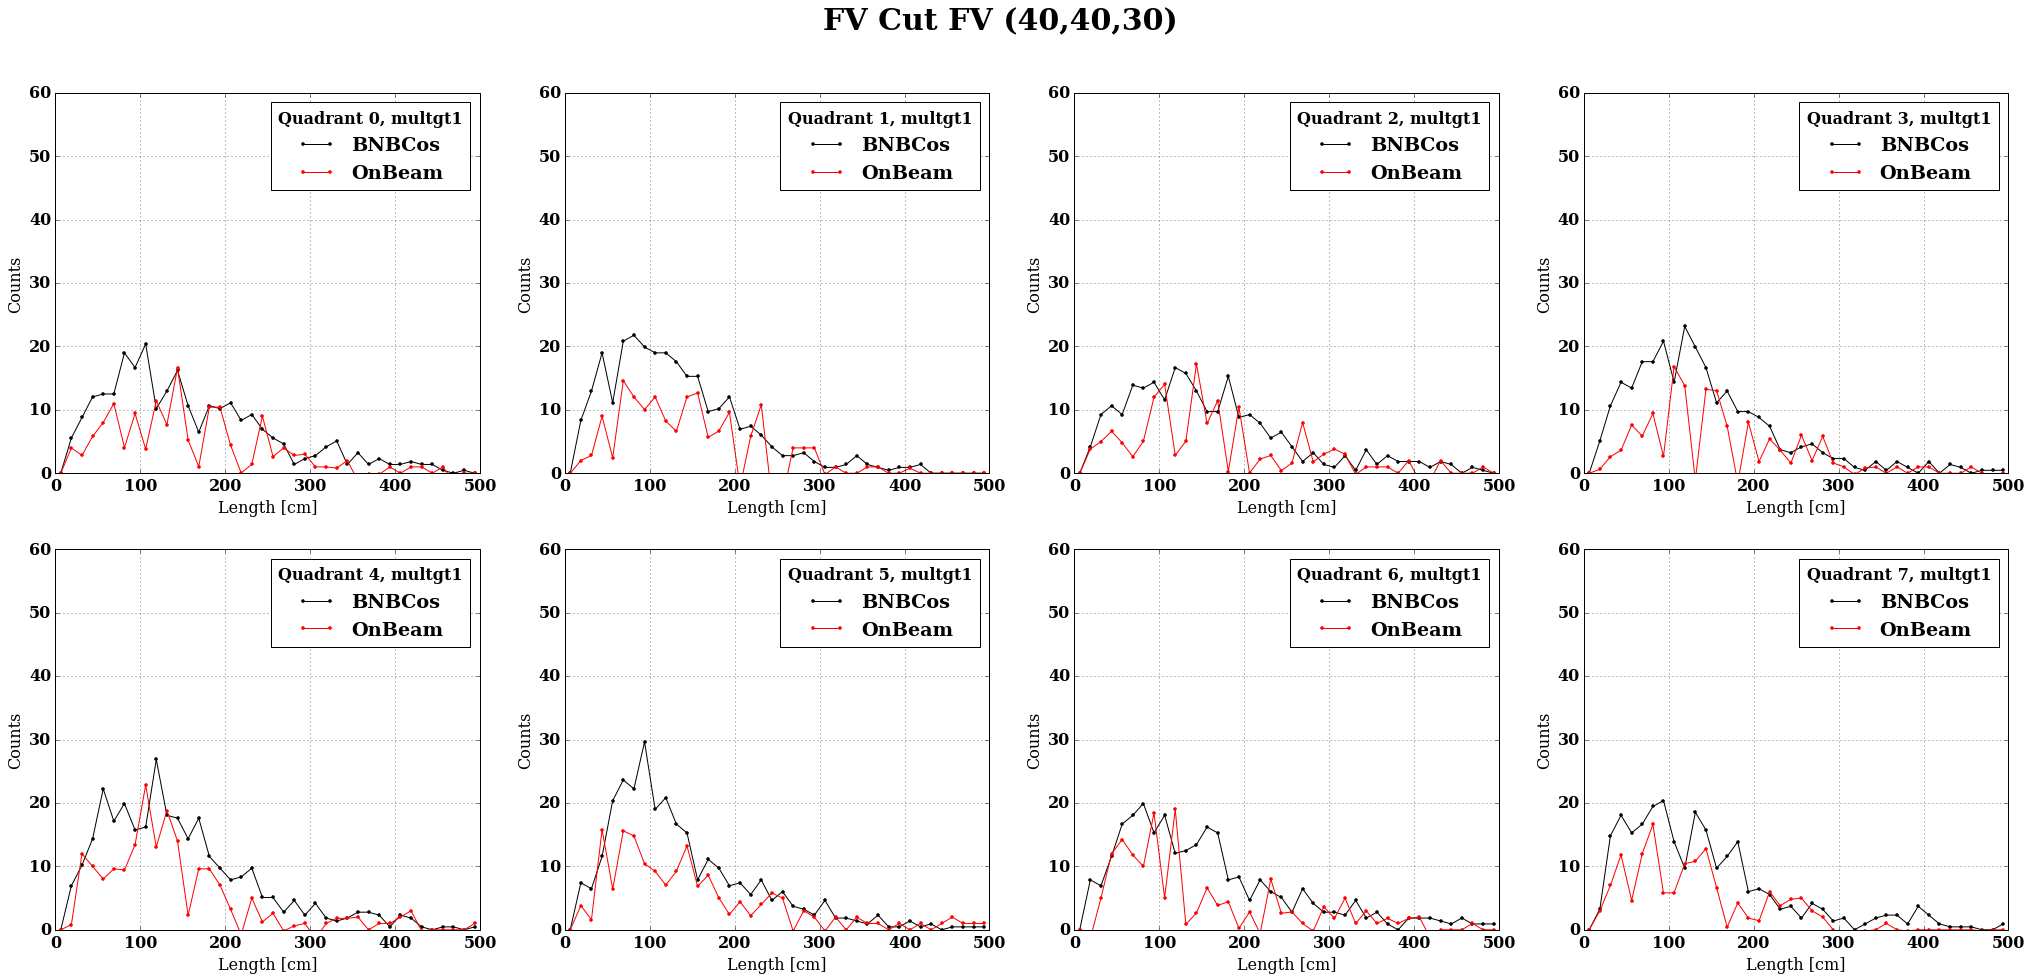

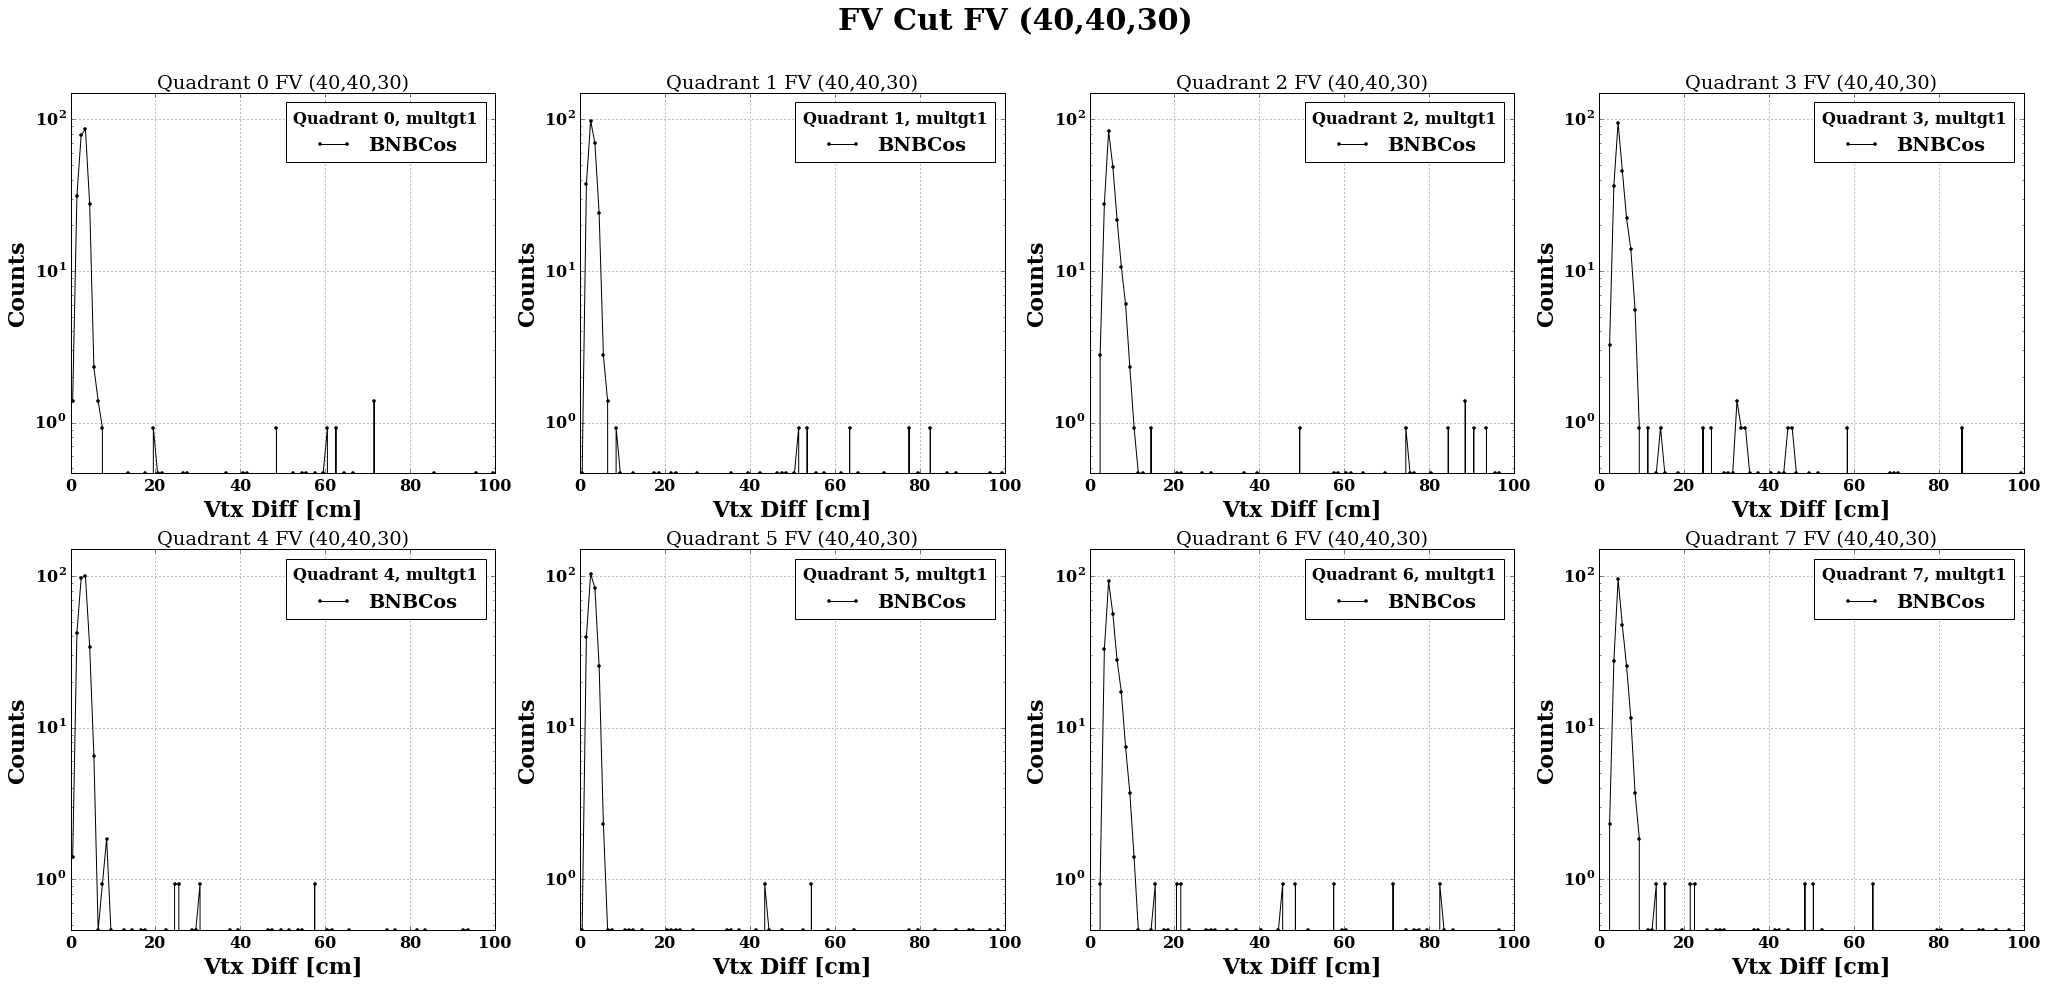

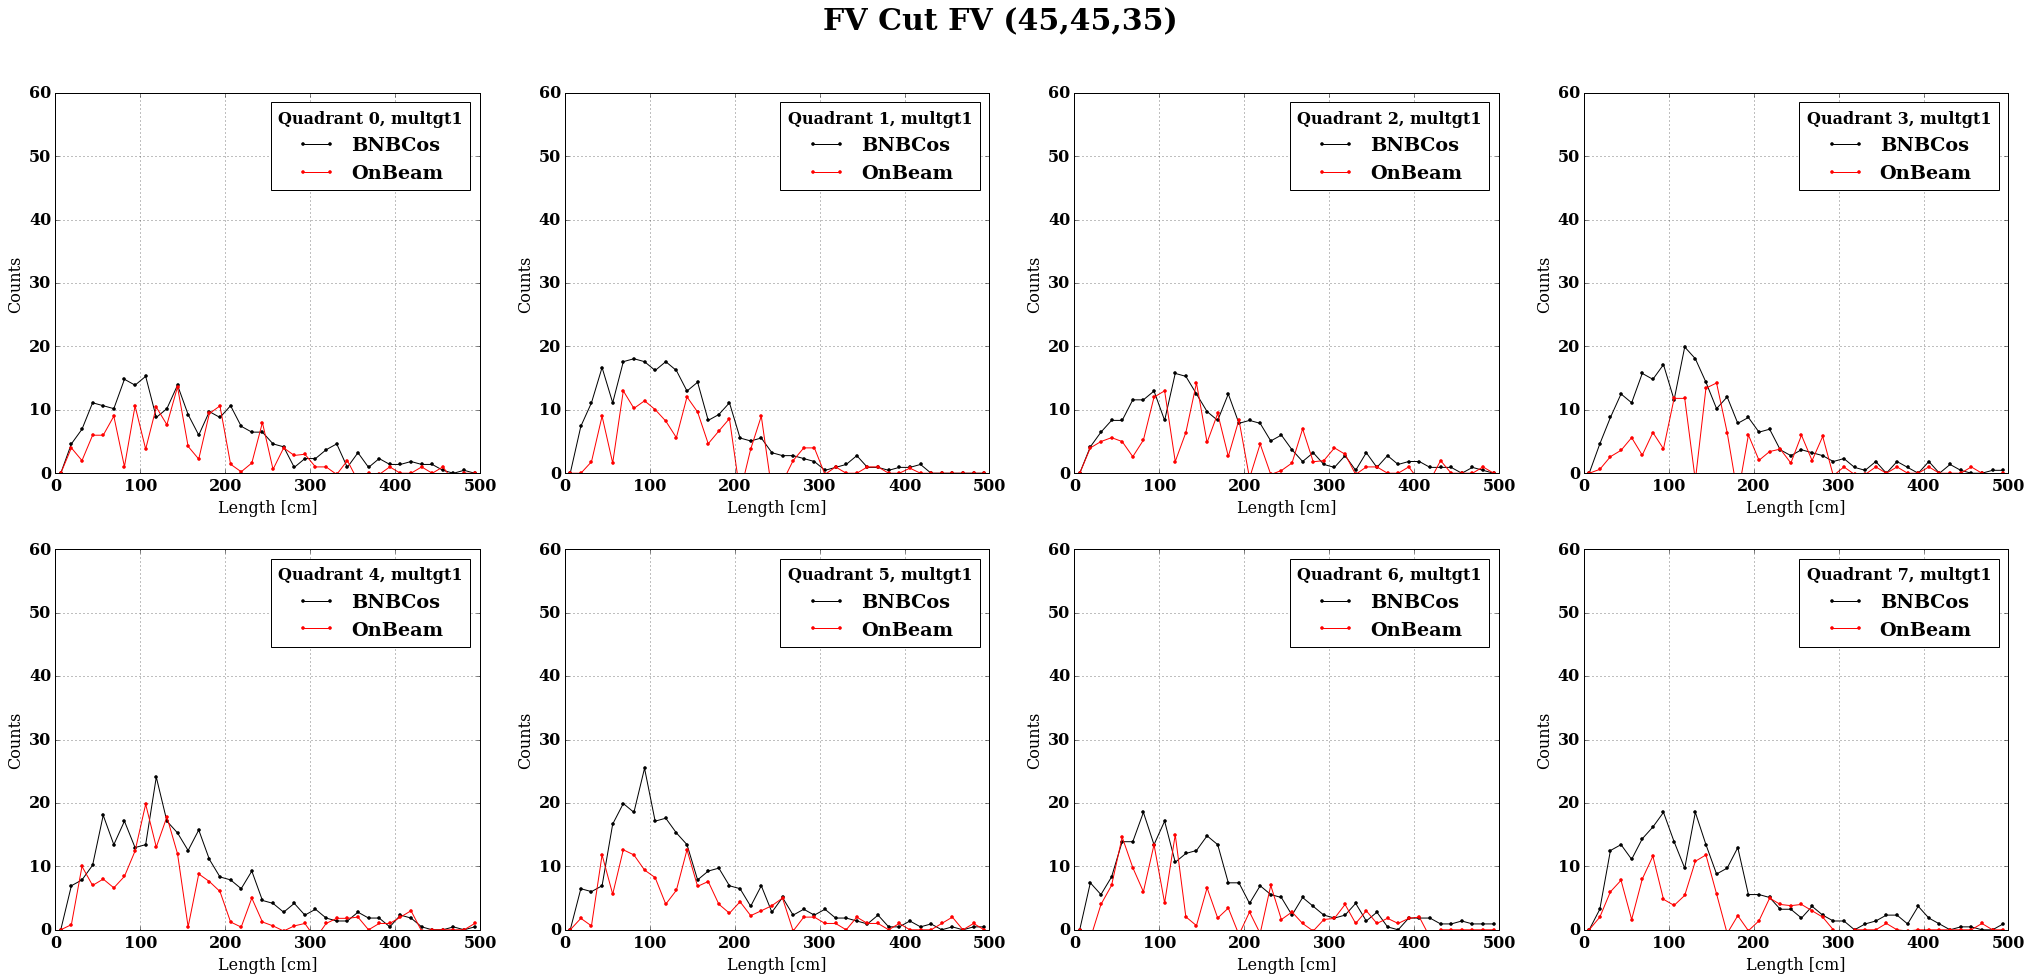

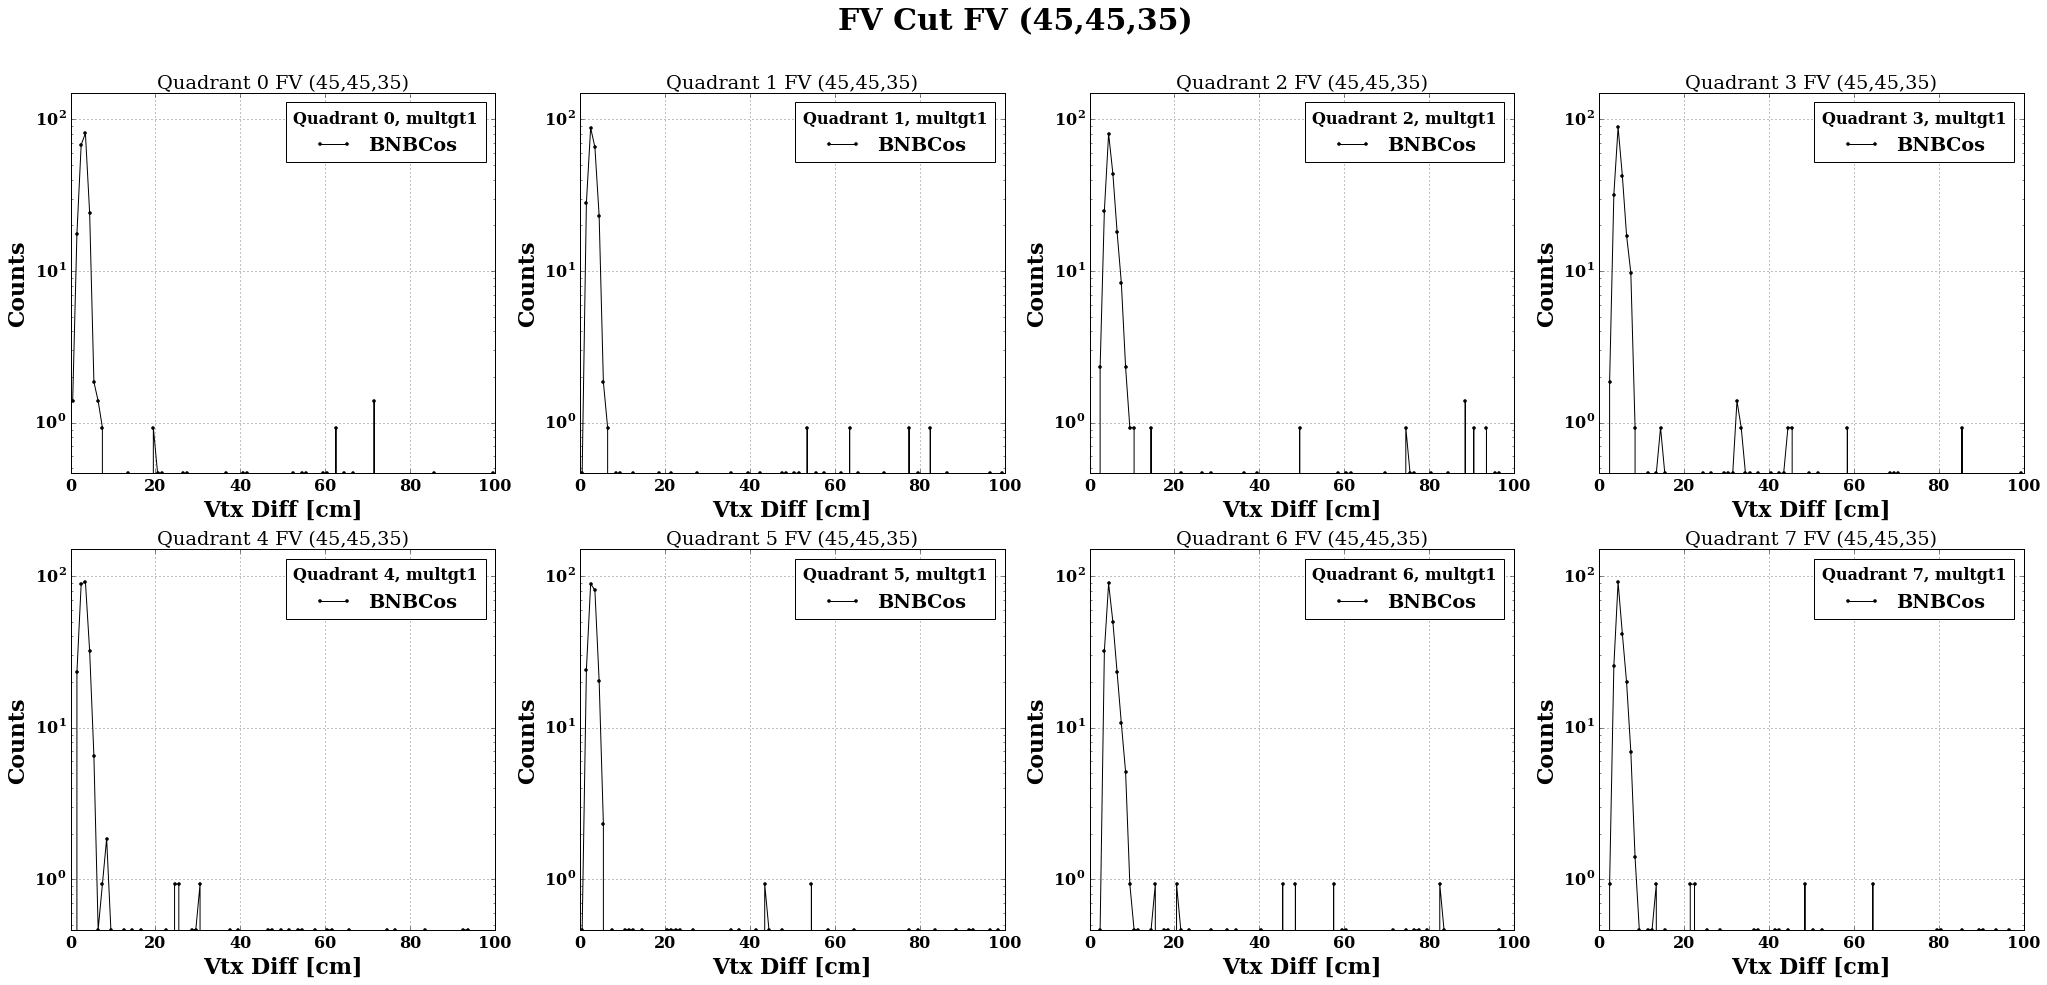

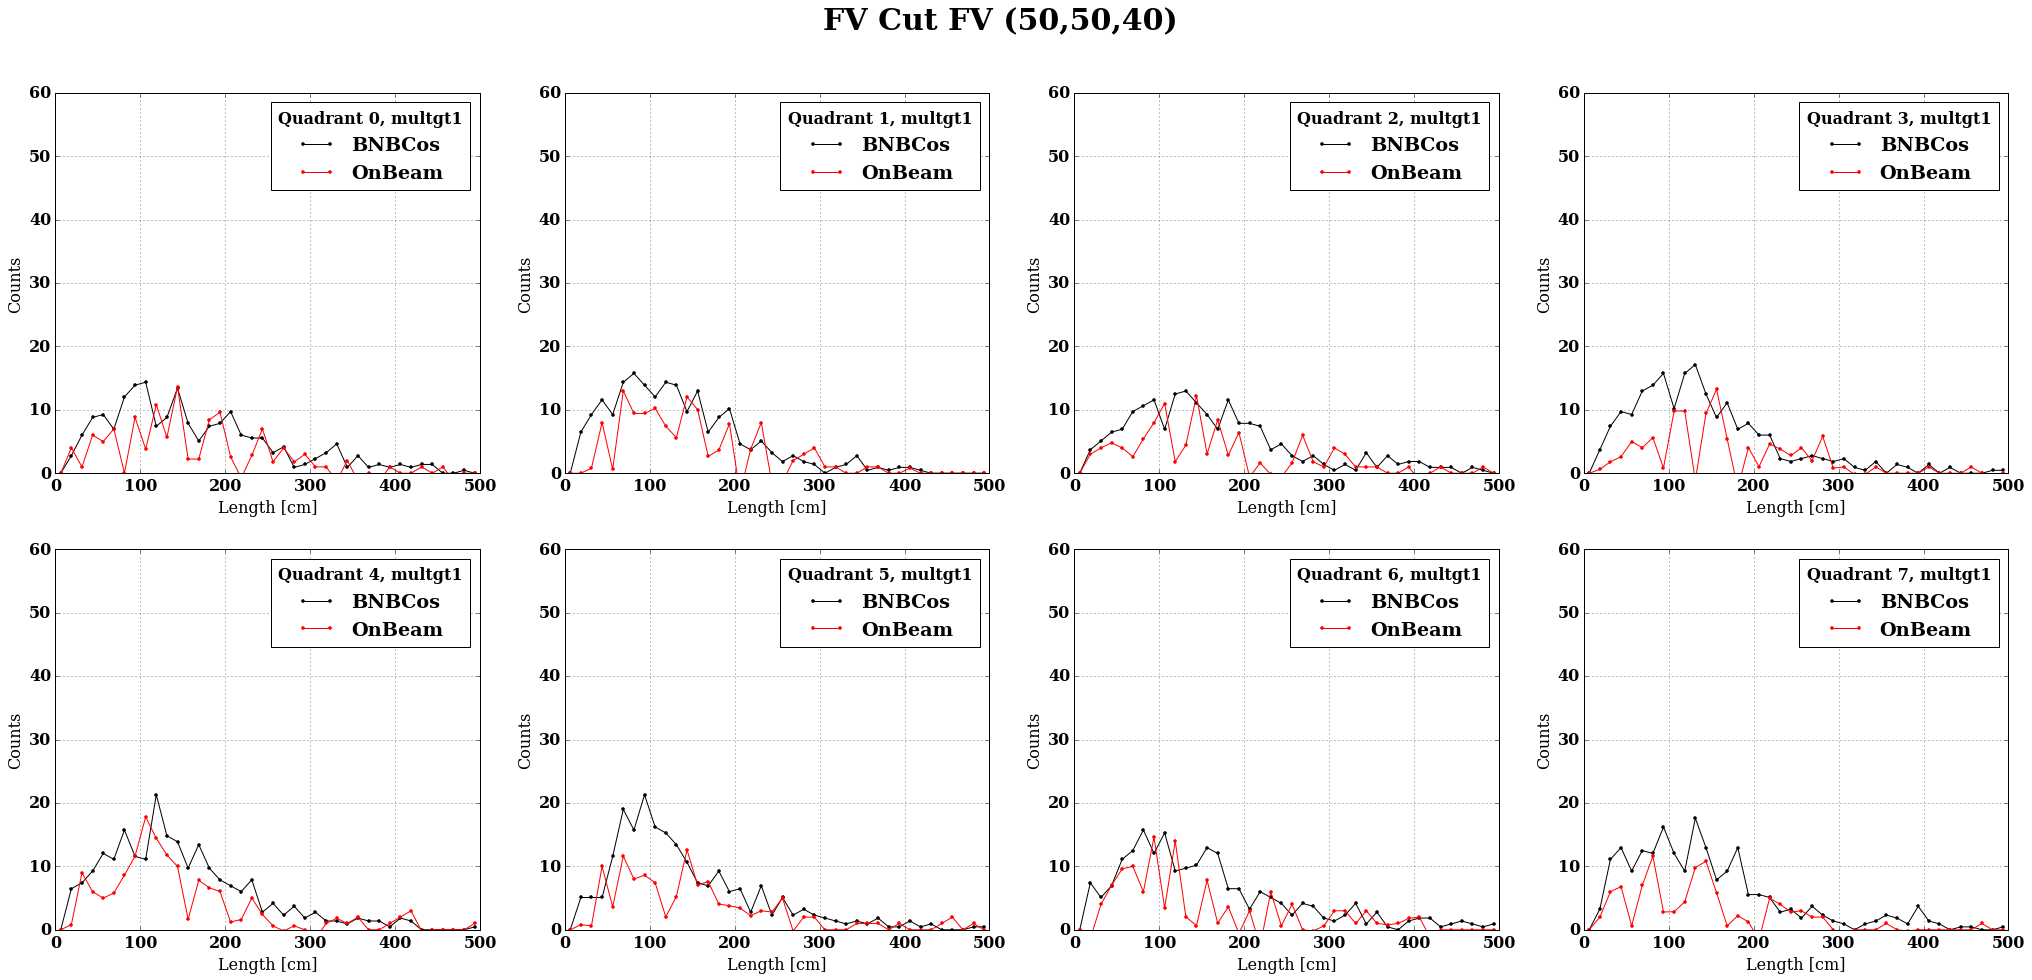

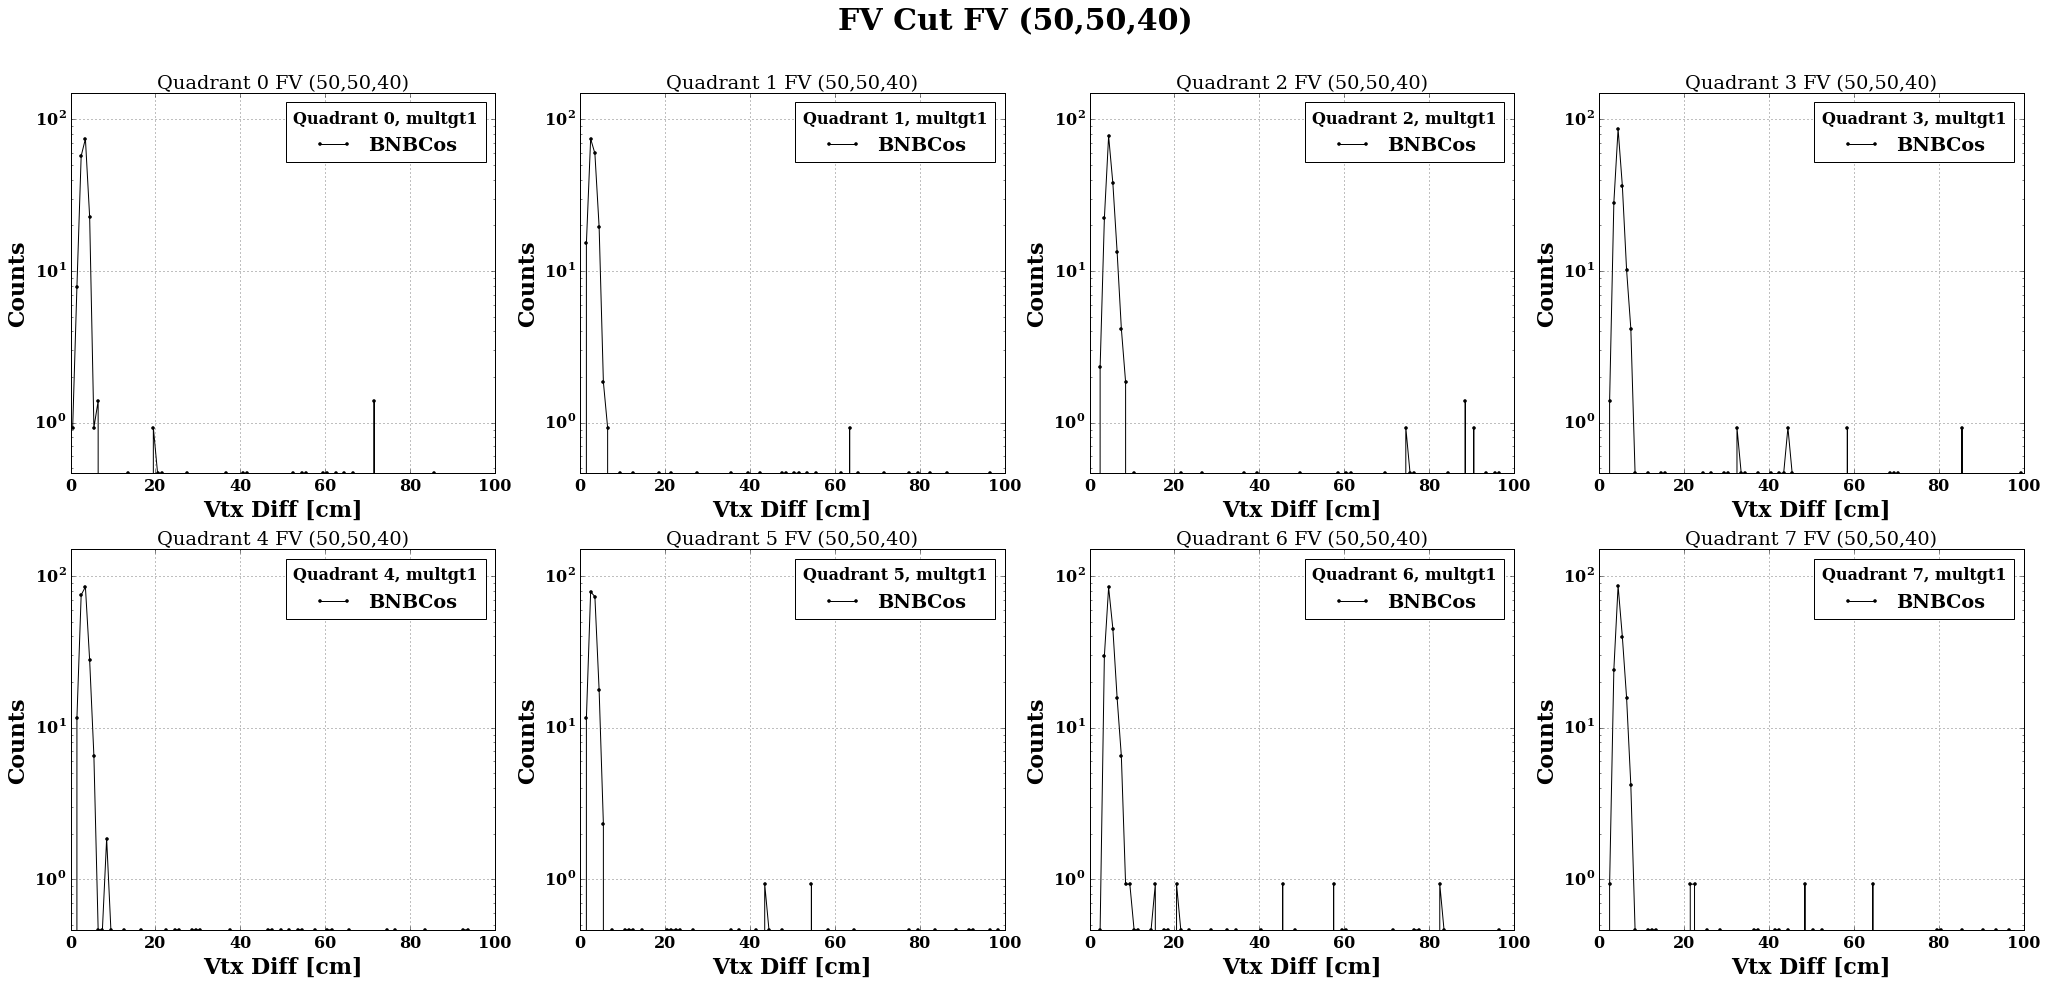

In [242]:
getFVRegions(df_beam_multgt1, df_offbeam_multgt1, df_bnbcos_multgt1,name='multgt1')

In [247]:
tot_on = 525613
tot_off = 379202
tot_bnbcos = 101600
tot_intime = 25874

scale_intime = 10.279 
int_per_1e20POT = 99035.2 
dataPOT = 0.495 * (tot_on) / 547616  
mcbnbcos_POT = float(tot_bnbcos)/int_per_1e20POT 

off_to_on = 1.23 * (382718./tot_off) * (tot_on/547616.)
mc_to_onbeam = dataPOT/mcbnbcos_POT
#print "POTS : ", dataPOT, mcbnbcos_POT 
intime_to_onbeam = dataPOT/mcbnbcos_POT*scale_intime * tot_bnbcos/tot_intime

print "MC to OnBeam : ", mc_to_onbeam
print "Off to OnBeam: ",off_to_on
print "InTime to OnBeam: ", intime_to_onbeam

MC to OnBeam :  0.463117341354
Off to OnBeam:  1.19152552442
InTime to OnBeam:  18.6927003255


In [248]:
fmcc8 ='CCpi0hist_dataMCComp_v6_meetingSuggestions.root '
#fmcc8 ='CCpi0hist_dataMCComp_v5_meetingSuggestions.root'   
a = rn.root2array(fmcc8,treename='tree')
df_cos = pd.DataFrame(a)

df_cos['calc_len'] = np.sqrt(pow(df_cos.start_x - df_cos.end_x,2) + pow(df_cos.start_y - df_cos.end_y,2) + \
                         pow(df_cos.start_z - df_cos.end_z,2) )
df_cos['len_diff'] = df_cos['len'] - df_cos['calc_len']
df_cos['tot_mult2_len'] = df_cos['tracklenshort'] + df_cos['tracklenlong']


# Add in distances to wall as well for easy fv study
df_beam_multgt1 = df_cos.query('mult == 2 and sample == 0 and flash_npe > 50')
df_offbeam_multgt1 = df_cos.query('mult == 2 and sample == 1 and flash_npe > 50')
df_bnbcos_multgt1 = df_cos.query('mult == 2 and sample == 2 and flash_npe > 50')
df_intime_multgt1 = df_cos.query('mult == 2 and sample == 3 and flash_npe > 50')

print df_bnbcos_multgt1.shape
print "SEL 2: ", df_cos.query('sample == 2').shape[0]
print df_cos.query('sample == 2 and (angleBtnTracks > -0.72 or end_y > -94 or end_y > 106 )').shape
print df_cos.query('sample == 2 and (angleBtnTracks > -0.72 or end_y > -94 or end_y > 106 )').shape


(5613, 32)
SEL 2:  9159
(9032, 32)
(9032, 32)


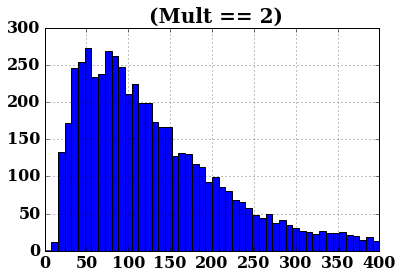

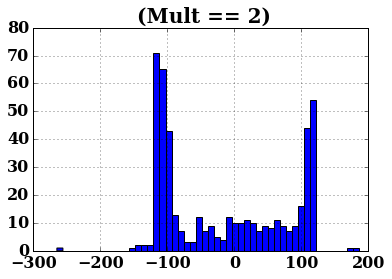

In [277]:
plt.figure()
_,_,_ = plt.hist(df_bnbcos_multgt1.len.values,bins=50,range=(0,400))
plt.grid(True)
#plt.ylabel('Track Length [cm]',fontsize=18,weight='bold')
plt.title(' (Mult == 2)',fontsize=20,weight='bold')
#plt.xlabel('Angle Between 2 longest tracks [cm]',fontsize=18,weight='bold')

plt.figure()
_,_,_ = plt.hist(df_offbeam_multgt1.end_y.values,bins=50)
plt.grid(True)
#plt.ylabel('Track Length [cm]',fontsize=18,weight='bold')
plt.title(' (Mult == 2)',fontsize=20,weight='bold')
#plt.xlabel('Angle Between 2 longest tracks [cm]',fontsize=18,weight='bold')

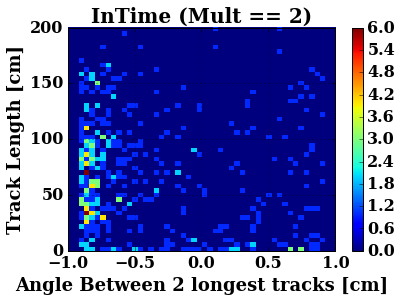

In [249]:
plt.figure()
_ = plt.hist2d(df_offbeam_multgt1.angleBtnTracks.values,df_offbeam_multgt1.tracklenshort.values,bins=50,\
               range=[(-1,1),(0,200)])
plt.grid(True)
plt.ylabel('Track Length [cm]',fontsize=18,weight='bold')
plt.title('InTime (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle Between 2 longest tracks [cm]',fontsize=18,weight='bold')
plt.colorbar()

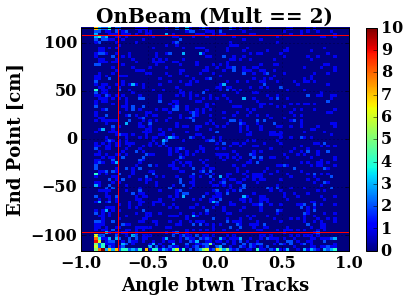

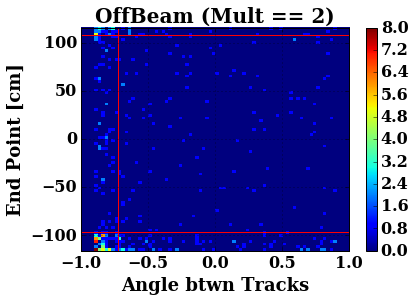

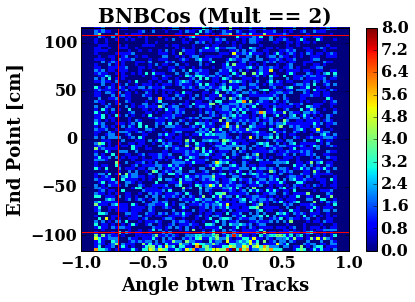

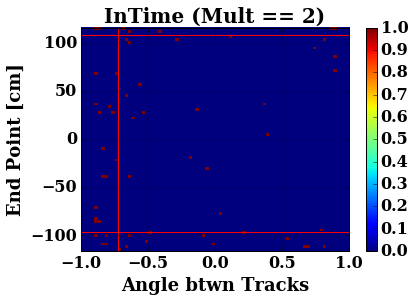

In [250]:
plt.figure()
_ = plt.hist2d(df_beam_multgt1.angleBtnTracks.values,df_beam_multgt1.end_y.values,bins=80,\
               range=[(-1,1),(-116,116)])
plt.grid(True)
plt.title('OnBeam (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('End Point [cm]',fontsize=18,weight='bold')
plt.colorbar()
plt.axhline(108,color='r',lw=1)
plt.axhline(-96,color='r',lw=1)
plt.axvline(-0.72,color='r',lw=1)

plt.figure()
_ = plt.hist2d(df_offbeam_multgt1.angleBtnTracks.values,df_offbeam_multgt1.end_y.values,bins=80,\
               range=[(-1,1),(-116,116)])
plt.grid(True)
plt.title('OffBeam (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('End Point [cm]',fontsize=18,weight='bold')
plt.colorbar()
plt.axhline(108,color='r',lw=1)
plt.axhline(-96,color='r',lw=1)
plt.axvline(-0.72,color='r',lw=1)

plt.figure()
_ = plt.hist2d(df_bnbcos_multgt1.angleBtnTracks.values,df_bnbcos_multgt1.end_y.values,bins=80,\
               range=[(-1,1),(-116,116)])
plt.grid(True)
plt.title('BNBCos (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('End Point [cm]',fontsize=18,weight='bold')
plt.colorbar()
plt.axhline(108,color='r',lw=1)
plt.axhline(-96,color='r',lw=1)
plt.axvline(-0.72,color='r',lw=1)

plt.figure()
_ = plt.hist2d(df_intime_multgt1.angleBtnTracks.values,df_intime_multgt1.end_y.values,bins=80,\
               range=[(-1,1),(-116,116)])
plt.grid(True)
plt.title('InTime (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('End Point [cm]',fontsize=18,weight='bold')
plt.colorbar()
plt.axhline(108,color='r',lw=1)
plt.axhline(-96,color='r',lw=1)
plt.axvline(-0.72,color='r',lw=1)

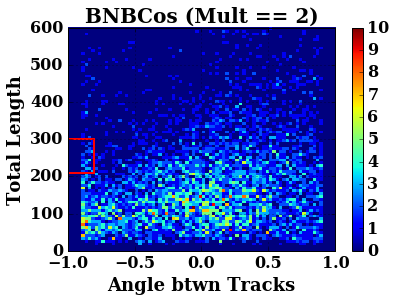

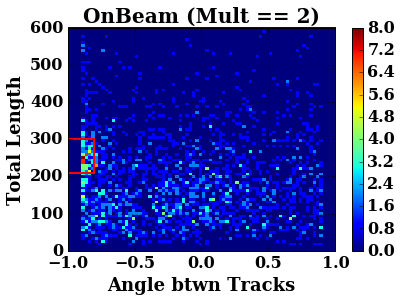

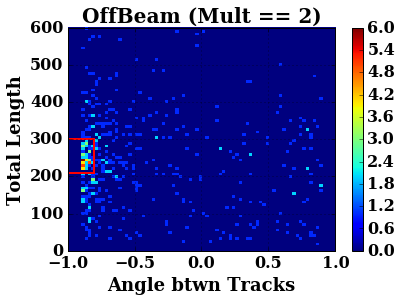

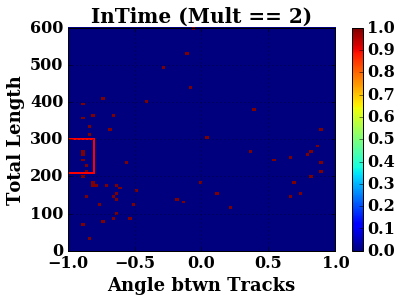

In [262]:
plt.figure()
_ = plt.hist2d(df_bnbcos_multgt1.angleBtnTracks.values,df_bnbcos_multgt1.tot_mult2_len.values,\
               bins=80,range=[(-1,1),(0,600)])
plt.grid(True)
plt.title('BNBCos (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('Total Length',fontsize=18,weight='bold')
plt.colorbar()
plt.plot((-0.8,-0.8),(210,300),color='r',lw=2)
plt.plot((-1.,-0.8),(210,210),color='r',lw=2)
plt.plot((-1.,-0.8),(300,300),color='r',lw=2)

plt.figure()
_ = plt.hist2d(df_beam_multgt1.angleBtnTracks.values,df_beam_multgt1.tot_mult2_len.values,bins=80,\
               range=[(-1,1),(0,600)])#,norm=LogNorm())
plt.grid(True)
plt.title('OnBeam (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('Total Length',fontsize=18,weight='bold')
plt.colorbar()
plt.plot((-0.8,-0.8),(210,300),color='r',lw=2)
plt.plot((-1.,-0.8),(210,210),color='r',lw=2)
plt.plot((-1.,-0.8),(300,300),color='r',lw=2)

plt.figure()
_ = plt.hist2d(df_offbeam_multgt1.angleBtnTracks.values,df_offbeam_multgt1.tot_mult2_len.values,bins=80,\
               range=[(-1,1),(0,600)])#,norm=LogNorm())
plt.grid(True)
plt.title('OffBeam (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('Total Length',fontsize=18,weight='bold')
plt.colorbar()
plt.plot((-0.8,-0.8),(210,300),color='r',lw=2)
plt.plot((-1.,-0.8),(210,210),color='r',lw=2)
plt.plot((-1.,-0.8),(300,300),color='r',lw=2)


plt.figure()
_ = plt.hist2d(df_intime_multgt1.angleBtnTracks.values,df_intime_multgt1.tot_mult2_len.values,bins=80,\
               range=[(-1,1),(0,600)])#,norm=LogNorm())
plt.grid(True)
plt.title('InTime (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('Total Length',fontsize=18,weight='bold')
plt.colorbar()
plt.plot((-0.8,-0.8),(210,300),color='r',lw=2)
plt.plot((-1.,-0.8),(210,210),color='r',lw=2)
plt.plot((-1.,-0.8),(300,300),color='r',lw=2)

In [259]:
# Add in distances to wall as well for easy fv study
df_beam = df_cos.query('sample == 0')
df_offbeam = df_cos.query('sample == 1')
df_bnbcos = df_cos.query('sample == 2')
df_intime = df_cos.query('sample == 3')

print df_beam.shape[0],df_offbeam.shape[0], df_bnbcos.shape[0]
print b.shape[0],ob.shape[0],bc.shape[0]

df_beam_not = df_cos.query('sample == 0 and mult != 2')
df_offbeam_not = df_cos.query('sample == 1 and mult != 2')
df_bnbcos_not = df_cos.query('sample == 2 and mult != 2')
df_intime_not = df_cos.query('sample == 3 and mult != 2')

df_beam_2    = df_cos.query('sample == 0 and mult == 2 and \
                            (angleBtnTracks > -0.8 or (tot_mult2_len < 210 and tot_mult2_len >300))')
df_offbeam_2 = df_cos.query('sample == 1 and mult == 2 and \
                            (angleBtnTracks > -0.8 or (tot_mult2_len < 210 and tot_mult2_len >300))')
df_bnbcos_2 = df_cos.query('sample == 2 and mult == 2 and \
                          (angleBtnTracks > -0.8 or (tot_mult2_len < 210 and tot_mult2_len >300))')
df_intime_2 = df_cos.query('sample == 3 and mult == 2 and \
                          (angleBtnTracks > -0.8 or (tot_mult2_len < 210 and tot_mult2_len >300))')

df_beam_cat = pd.concat([df_beam_2,df_beam_not])
df_offbeam_cat = pd.concat([df_offbeam_2,df_offbeam_not])
df_bnbcos_cat = pd.concat([df_bnbcos_2,df_bnbcos_not])
df_intime_cat = pd.concat([df_intime_2,df_intime_not])

3883 982 9159
1877 323 5497


In [261]:

print "SEL 2: "
print " OnBeam: ", df_beam.shape[0]
print " OffBeam: ", df_offbeam.shape[0]
print " BNBCos: ", df_bnbcos.shape[0]
print " InTime: ", df_intime.shape[0]

print "SEL 2 Scaled: "
print " OnBeam: %.0f"% df_beam.shape[0]
print " OffBeam: %.2f"% (df_offbeam.shape[0] * off_to_on)
print " On - OffBeam: %.2f" % (df_beam.shape[0] - df_offbeam.shape[0] * off_to_on)
print " BNBCos: %.2f"% (df_bnbcos.shape[0] * mc_to_onbeam)
#print " InTime: %.2f"% (df_intime.shape[0] * intime_to_onbeam)


print "\nCut Adjusts Scaled: "
print " OnBeam: ", df_beam_cat.shape[0]
print " OffBeam: ",df_offbeam_cat.shape[0] * off_to_on
print " On - OffBeam: ", df_beam_cat.shape[0] - df_offbeam_cat.shape[0] * off_to_on
print " BNBCos: ",df_bnbcos_cat.shape[0] * mc_to_onbeam
#print " InTime: ",df_intime_cat.shape[0] * intime_to_onbeam


SEL 2: 
 OnBeam:  3883
 OffBeam:  982
 BNBCos:  9159
 InTime:  146
SEL 2 Scaled: 
 OnBeam: 3883
 OffBeam: 1170.08
 On - OffBeam: 2712.92
 BNBCos: 4241.69

Cut Adjusts Scaled: 
 OnBeam:  3562
 OffBeam:  968.710251355
 On - OffBeam:  2593.28974864
 BNBCos:  4080.99001201


In [167]:
b = df_beam_multgt1.query('(angleBtnTracks > -0.72 or end_y < 108) and \
                          (angleBtnTracks > -0.65 or end_y > -96 )')
ob = df_offbeam_multgt1.query('(angleBtnTracks > -0.72 or end_y < 108) and \
                          (angleBtnTracks > -0.65 or end_y > -96 )')
bc = df_bnbcos_multgt1.query('(angleBtnTracks > -0.72 or end_y < 108) and \
                          (angleBtnTracks > -0.65 or end_y > -96 )')

In [221]:
# Add in distances to wall as well for easy fv study
df_beam = df_cos.query('sample == 0')
df_offbeam = df_cos.query('sample == 1')
df_bnbcos = df_cos.query('sample == 2')
df_intime = df_cos.query('sample == 3')

print df_beam.shape[0],df_offbeam.shape[0], df_bnbcos.shape[0]
print b.shape[0],ob.shape[0],bc.shape[0]

df_beam_not = df_cos.query('sample == 0 and mult != 2')
df_offbeam_not = df_cos.query('sample == 1 and mult != 2')
df_bnbcos_not = df_cos.query('sample == 2 and mult != 2')
df_intime_not = df_cos.query('sample == 3 and mult != 2')

df_beam_2    = df_cos.query('sample == 0 and mult == 2 and (angleBtnTracks > -0.72 or end_y < 108) and \
                          (angleBtnTracks > -0.65 or end_y > -96 )')
df_offbeam_2 = df_cos.query('sample == 1 and mult == 2 and (angleBtnTracks > -0.72 or end_y < 108) and \
                          (angleBtnTracks > -0.65 or end_y > -96 )')
df_bnbcos_2 = df_cos.query('sample == 2 and mult == 2 and (angleBtnTracks > -0.72 or end_y < 108) and \
                          (angleBtnTracks > -0.65 or end_y > -96 )')
df_intime_2 = df_cos.query('sample == 3 and mult == 2 and (angleBtnTracks > -0.72 or end_y < 108) and \
                          (angleBtnTracks > -0.65 or end_y > -96 )')

df_beam_cat = pd.concat([df_beam_2,df_beam_not])
df_offbeam_cat = pd.concat([df_offbeam_2,df_offbeam_not])
df_bnbcos_cat = pd.concat([df_bnbcos_2,df_bnbcos_not])
df_intime_cat = pd.concat([df_intime_2,df_intime_not])

3883 982 9159
1877 323 5497


In [225]:

#print "SEL 2: "
#print " OnBeam: ", df_beam.shape[0]
#print " OffBeam: ", df_offbeam.shape[0]
#print " BNBCos: ", df_bnbcos.shape[0]
#print " InTime: ", df_intime.shape[0]

print "SEL 2 Scaled: "
print " OnBeam: ", df_beam.shape[0]
print " OffBeam: ", df_offbeam.shape[0] * off_to_on
print " On - OffBeam: ", df_beam.shape[0] - df_offbeam.shape[0] * off_to_on 
print " BNBCos: ", df_bnbcos.shape[0] * mc_to_onbeam
#print " InTime: ", df_intime.shape[0] * intime_to_onbeam


print "\nCut Adjusts Scaled: "
print " OnBeam: ", df_beam_cat.shape[0]
print " OffBeam: ",df_offbeam_cat.shape[0] * off_to_on
print " On - OffBeam: ", df_beam_cat.shape[0] - df_offbeam_cat.shape[0] * off_to_on
print " BNBCos: ",df_bnbcos_cat.shape[0] * mc_to_onbeam
#print " InTime: ",df_intime_cat.shape[0] * intime_to_onbeam


SEL 2 Scaled: 
 OnBeam:  3883
 OffBeam:  1170.07806498
 On - OffBeam:  2712.92193502
 BNBCos:  4241.69172946

Cut Adjusts Scaled: 
 OnBeam:  3662
 OffBeam:  983.008557649
 On - OffBeam:  2678.99144235
 BNBCos:  4187.97011787


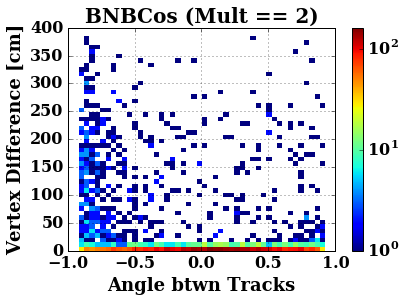

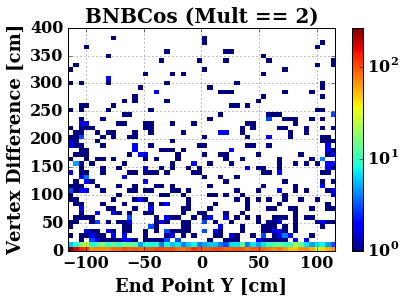

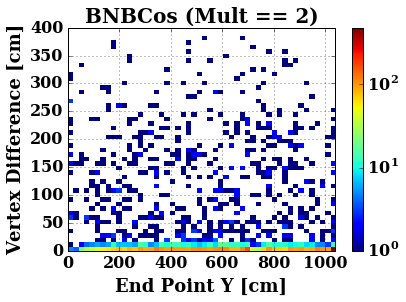

In [190]:
plt.figure()
_ = plt.hist2d(df_bnbcos_multgt1.angleBtnTracks.values,df_bnbcos_multgt1.vtx_diff.values,bins=50, norm=LogNorm(),\
               range=[(-1,1),(0,400)])
plt.grid(True)
plt.title('BNBCos (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('Angle btwn Tracks',fontsize=18,weight='bold')
plt.ylabel('Vertex Difference [cm]',fontsize=18,weight='bold')
plt.colorbar()

plt.figure()
_ = plt.hist2d(df_bnbcos_multgt1.end_y.values,df_bnbcos_multgt1.vtx_diff.values,bins=50, norm=LogNorm(),\
               range=[(-116,116),(0,400)])
plt.grid(True)
plt.title('BNBCos (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('End Point Y [cm]',fontsize=18,weight='bold')
plt.ylabel('Vertex Difference [cm]',fontsize=18,weight='bold')
plt.colorbar()

plt.figure()
_ = plt.hist2d(df_bnbcos_multgt1.end_z.values,df_bnbcos_multgt1.vtx_diff.values,bins=50, norm=LogNorm(),\
               range=[(0,1040),(0,400)])
plt.grid(True)
plt.title('BNBCos (Mult == 2)',fontsize=20,weight='bold')
plt.xlabel('End Point Y [cm]',fontsize=18,weight='bold')
plt.ylabel('Vertex Difference [cm]',fontsize=18,weight='bold')
plt.colorbar()

In [10]:
df_beam_mult2 = df.query('sample == 0')#and vtx_diff > 20) ')
df_offbeam_mult2 = df.query(' sample == 1')#and vtx_diff > 20')
df_bnbcos_mult2 = df.query('sample == 2 and vtx_diff >= 25 and mult >= 2')
df_intime_mult2 = df.query(' sample == 3 and vtx_diff >= 25 and mult >=2')

df_on = df_beam_mult2
df_off = df_offbeam_mult2
df_mcbnb = df_bnbcos_mult2

In [11]:
x_beam = df_on.reco_vtx_x.values
x_offbeam = df_off.reco_vtx_x.values
x_bnbcos = df_mcbnb.reco_vtx_x.values

nbins = 50
x_off_x, y_off_x = np.histogram(x_offbeam,bins=nbins)
x_on_x, y_on_x = np.histogram(x_beam,bins=nbins)
x_bnb_x, y_bnb_x = np.histogram(x_bnbcos,bins=nbins)
bins_x = (y_bnb_x[:-1] + y_bnb_x[1:])/2

x_offbeam = [ x_off_x[i]*off_to_on for i in xrange(len(x_off_x)) ]
x_bnbcos = [ x_bnb_x[i]*mc_to_onbeam for i in xrange(len(x_bnb_x)) ]
x_off_min_on = [x_on_x[i] - x_off_x[i]*off_to_on for i in xrange(len(x_on_x))]

x_ratio = [ x_off_min_on[i] / x_bnbcos[i] for i in xrange(len(x_bnbcos)) ]

In [12]:
y_beam = df_on.reco_vtx_y.values
y_offbeam = df_off.reco_vtx_y.values
y_bnbcos = df_mcbnb.reco_vtx_y.values

#nbins = 20
x_off, y_off = np.histogram(y_offbeam,bins=nbins)
x_on, y_on = np.histogram(y_beam,bins=nbins)
x_bnb, y_bnb = np.histogram(y_bnbcos,bins=nbins)
bins = (y_bnb[:-1] + y_bnb[1:])/2

y_offbeam = [ x_off[i]*off_to_on for i in xrange(len(x_off)) ]
y_bnbcos = [ x_bnb[i]*mc_to_onbeam for i in xrange(len(x_bnb)) ]
y_off_min_on = [x_on[i] - x_off[i]*off_to_on for i in xrange(len(x_on))]

y_ratio = [ y_off_min_on[i] / y_bnbcos[i] for i in xrange(len(y_bnbcos)) ]

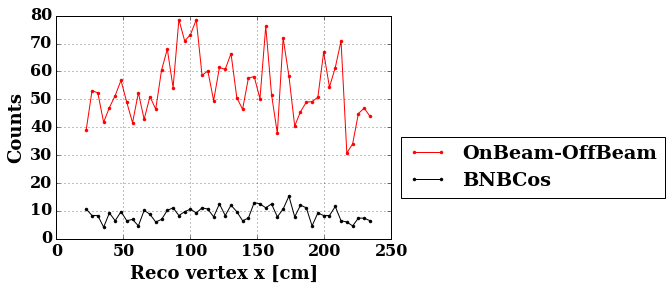

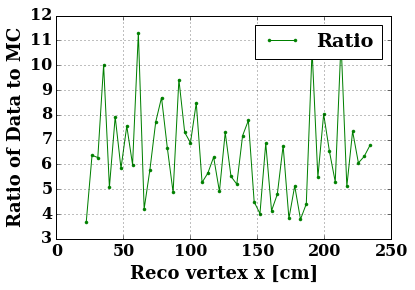

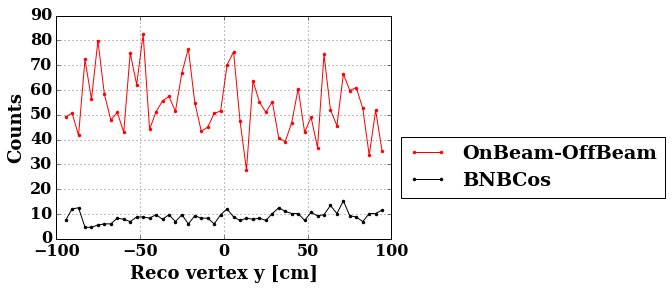

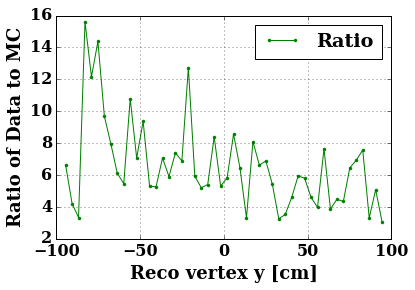

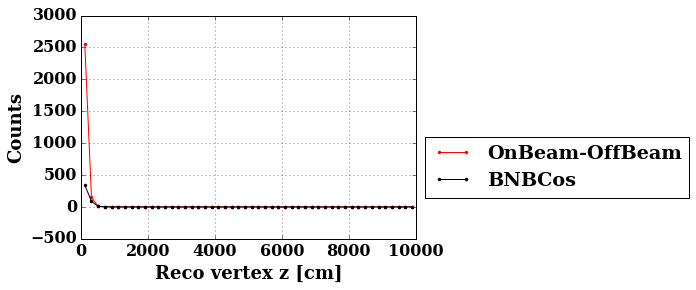

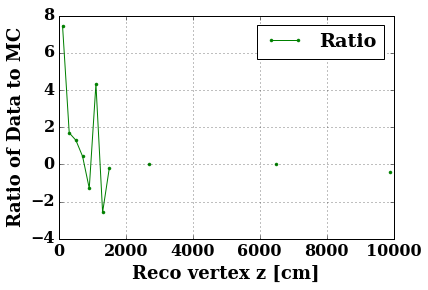

In [14]:
plt.figure()
plt.plot(bins_x,x_off_min_on,'r-',marker='.',lw=1,label='OnBeam-OffBeam')
plt.plot(bins_x,x_bnbcos,'k-',marker='.',lw=1,label='BNBCos')
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
#plt.title('Mult 1 and 2',fontsize=20,weight='bold')
plt.xlabel('Reco vertex x [cm]',fontsize=18,weight='bold')
plt.ylabel('Counts',fontsize=18,weight='bold')

plt.figure()
plt.grid(True)
plt.plot(bins_x,x_ratio,'-',color='g',label="Ratio",marker='.')
plt.legend()
plt.ylabel('Ratio of Data to MC',fontsize=18,weight='bold')
plt.xlabel('Reco vertex x [cm]',fontsize=18,weight='bold')
#plt.ylim(0,1)

plt.figure()
plt.plot(bins,y_off_min_on,'r-',marker='.',lw=1,label='OnBeam-OffBeam')
plt.plot(bins,y_bnbcos,'k-',marker='.',lw=1,label='BNBCos')
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
#plt.title('Mult 1 and 2',fontsize=20,weight='bold')
plt.xlabel('Reco vertex y [cm]',fontsize=18,weight='bold')
plt.ylabel('Counts',fontsize=18,weight='bold')
#ax2 = plt.twinx()
#plt.plot(bins,y_ratio,'-',color='g',label="Ratio",marker='.')

plt.figure()
plt.grid(True)
plt.plot(bins,y_ratio,'-',color='g',label="Ratio",marker='.')
plt.legend()
plt.ylabel('Ratio of Data to MC',fontsize=18,weight='bold')
plt.xlabel('Reco vertex y [cm]',fontsize=18,weight='bold')
#plt.ylim(0,1)


plt.figure()
plt.plot(bins_z,z_off_min_on,'r-',marker='.',lw=1,label='OnBeam-OffBeam')
plt.plot(bins_z,z_bnbcos,'k-',marker='.',lw=1,label='BNBCos')
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
#plt.title('Mult 1 and 2',fontsize=20,weight='bold')
#plt.yscale('log')
plt.ylabel('Counts',fontsize=18,weight='bold')
plt.xlabel('Reco vertex z [cm]',fontsize=18,weight='bold')

plt.figure()
plt.grid(True)
plt.plot(bins_z,z_ratio,'-',color='g',label="Ratio",marker='.')
plt.legend()
plt.ylabel('Ratio of Data to MC',fontsize=18,weight='bold')
plt.xlabel('Reco vertex z [cm]',fontsize=18,weight='bold')
#plt.ylim(0,1)


In [ ]:
ot_on = 525613
tot_off = 379202
tot_bnbcos = 101600
int_per_1e20POT = 99035.2 
dataPOT = 0.495 * (tot_on) / 547616  
mcbnbcos_POT = float(tot_bnbcos)/int_per_1e20POT 
off_to_on = 1.23 * (382718./tot_off) * (tot_on/547616.)
mc_to_onbeam = dataPOT/mcbnbcos_POT

In [18]:
z_beam = df.query('sample == 0 and mult == 2')#and vtx_diff > 20) ')
z_offbeam = df.query(' sample == 1 and mult == 2')# and mult >0')#and vtx_diff > 20')
z_bnbcos = df.query('sample == 2 and mult == 2')# and mult > 0')

nbins = 50 
x_off_z, y_off_z = np.histogram(z_offbeam.len.values,bins=nbins,range=(0,500))
x_on_z, y_on_z = np.histogram(z_beam.len.values,bins=nbins,range=(0,500))
x_bnb_z, y_bnb_z = np.histogram(z_bnbcos.len.values,bins=nbins,range=(0,500))

bins_z = (y_bnb_z[:-1] + y_bnb_z[1:])/2

z_offbeam = [ x_off_z[i]*off_to_on for i in xrange(len(x_off_z)) ]
z_bnbcos = [ x_bnb_z[i]*mc_to_onbeam for i in xrange(len(x_bnb_z)) ]
z_off_min_on = [x_on_z[i] - x_off_z[i]*off_to_on for i in xrange(len(x_on_z))]

d_beam = df.query('sample == 0')#and vtx_diff > 20) ')
d_offbeam = df.query(' sample == 1')# and mult >0')#and vtx_diff > 20')
d_bnbcos = df.query('sample == 2')# and mult > 0')

x_off_m, y_off_m = np.histogram(d_offbeam.mult.values,bins=6,range=(0,6))
x_on_m, y_on_m = np.histogram(d_beam.mult.values,bins=6,range=(0,6))
x_bnb_m, y_bnb_m = np.histogram(d_bnbcos.mult.values,bins=6,range=(0,6))

bins_m = (y_bnb_m[:-1] + y_bnb_m[1:])/2

m_offbeam = [ x_off_m[i]*off_to_on for i in xrange(len(x_off_m)) ]
m_bnbcos = [ x_bnb_m[i]*mc_to_onbeam for i in xrange(len(x_bnb_m)) ]
m_off_min_on = [x_on_m[i] - x_off_m[i]*off_to_on for i in xrange(len(x_on_m))]

err_x= (bins_z[1] - bins_z[0]) *0.5

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


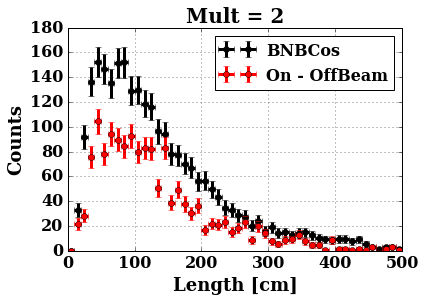

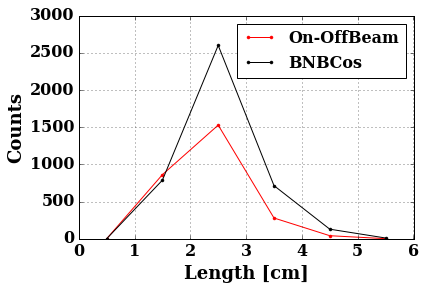

In [20]:
plt.figure()
#plt.plot(bins_z,z_off_min_on,'r-',marker='.',lw=1,label='On-OffBeam')
#plt.plot(bins_z,z_bnbcos,'k-',marker='.',lw=1,label='BNBCos')
plt.errorbar(bins_z,z_bnbcos,yerr=np.sqrt(z_bnbcos),xerr=err_x,fmt='o',color='k',lw=3,label='BNBCos')
plt.errorbar(bins_z,z_off_min_on,yerr=np.sqrt(z_off_min_on),xerr=err_x,fmt='o',color='r',lw=3,label='On - OffBeam')
plt.legend(fontsize=16)#loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.title('Mult = 2',fontsize=20,weight='bold')
#plt.yscale('log')
plt.ylabel('Counts',fontsize=18,weight='bold')
plt.xlabel('Length [cm]',fontsize=18,weight='bold')
plt.ylim(0,180)

plt.figure()
plt.plot(bins_m,m_off_min_on,'r-',marker='.',lw=1,label='On-OffBeam')
plt.plot(bins_m,m_bnbcos,'k-',marker='.',lw=1,label='BNBCos')
plt.legend(fontsize=16)#loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
#plt.title('Mult 1 and 2',fontsize=20,weight='bold')
#plt.yscale('log')
plt.ylabel('Counts',fontsize=18,weight='bold')
plt.xlabel('Length [cm]',fontsize=18,weight='bold')
#plt.ylim(0,80)


In [13]:
x_beam = df_on.end_x.values
x_offbeam = df_off.end_x.values
x_bnbcos = df_mcbnb.end_x.values

nbins = 50
x_off_x, y_off_x = np.histogram(x_offbeam,bins=nbins)
x_on_x, y_on_x = np.histogram(x_beam,bins=nbins)
x_bnb_x, y_bnb_x = np.histogram(x_bnbcos,bins=nbins)
bins_x = (y_bnb_x[:-1] + y_bnb_x[1:])/2

x_offbeam = [ x_off_x[i]*off_to_on for i in xrange(len(x_off_x)) ]
x_bnbcos = [ x_bnb_x[i]*mc_to_onbeam for i in xrange(len(x_bnb_x)) ]
x_off_min_on = [x_on_x[i] - x_off_x[i]*off_to_on for i in xrange(len(x_on_x))]

x_ratio = [ x_off_min_on[i] / x_bnbcos[i] for i in xrange(len(x_bnbcos)) ]

In [14]:
y_beam = df_on.end_y.values
y_offbeam = df_off.end_y.values
y_bnbcos = df_mcbnb.end_y.values

#nbins = 20
x_off, y_off = np.histogram(y_offbeam,bins=nbins)
x_on, y_on = np.histogram(y_beam,bins=nbins)
x_bnb, y_bnb = np.histogram(y_bnbcos,bins=nbins)
bins = (y_bnb[:-1] + y_bnb[1:])/2

y_offbeam = [ x_off[i]*off_to_on for i in xrange(len(x_off)) ]
y_bnbcos = [ x_bnb[i]*mc_to_onbeam for i in xrange(len(x_bnb)) ]
y_off_min_on = [x_on[i] - x_off[i]*off_to_on for i in xrange(len(x_on))]

y_ratio = [ y_off_min_on[i] / y_bnbcos[i] for i in xrange(len(y_bnbcos)) ]

/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in double_scalars


In [15]:
z_beam = df_on.end_z.values
z_offbeam = df_off.end_z.values
z_bnbcos = df_mcbnb.end_z.values

#nbins = 10 

x_off_z, y_off_z = np.histogram(z_offbeam,bins=nbins)
x_on_z, y_on_z = np.histogram(z_beam,bins=nbins)
x_bnb_z, y_bnb_z = np.histogram(z_bnbcos,bins=nbins)

bins_z = (y_bnb_z[:-1] + y_bnb_z[1:])/2

z_offbeam = [ x_off_z[i]*off_to_on for i in xrange(len(x_off_z)) ]
z_bnbcos = [ x_bnb_z[i]*mc_to_onbeam for i in xrange(len(x_bnb_z)) ]
z_off_min_on = [x_on_z[i] - x_off_z[i]*off_to_on for i in xrange(len(x_on_z))]

z_ratio = [ z_off_min_on[i] / z_bnbcos[i] for i in xrange(len(z_bnbcos)) ]

In [24]:
df_onbeam = df.query('sample == 0')
df_offbeam = df.query('sample == 1')
df_bnbcos = df.query('sample == 2 ')
#df_intime = df.query('(mult == 1 or mult == 2) and sample == 3')


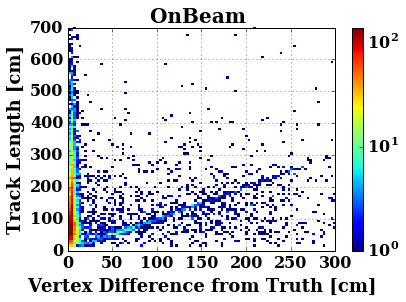

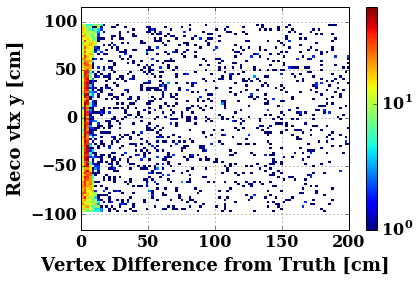

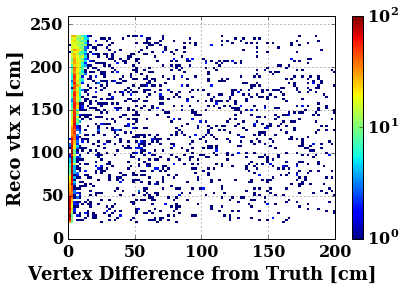

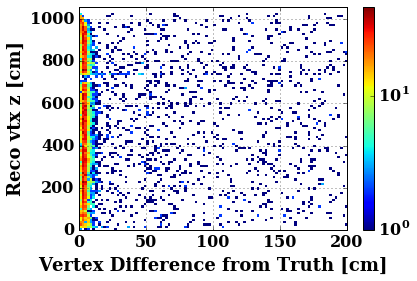

In [30]:
plt.figure()
_ = plt.hist2d(df_bnbcos.vtx_diff.values,df_bnbcos.len.values,bins=100,\
               range=[(0,300),(0,700)],norm=LogNorm())
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.ylabel('Track Length [cm]',fontsize=18,weight='bold')
plt.title('OnBeam ',fontsize=20,weight='bold')
plt.xlabel('Vertex Difference from Truth [cm]',fontsize=18,weight='bold')
plt.colorbar()

plt.figure()
_ = plt.hist2d(df_bnbcos.vtx_diff.values,df_bnbcos.reco_vtx_y.values,bins=100,\
               range=[(0,200),(-116,116)],norm=LogNorm())
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.xlabel('Vertex Difference from Truth [cm]',fontsize=18,weight='bold')
plt.ylabel('Reco vtx y [cm]',fontsize=18,weight='bold')
plt.colorbar()


plt.figure()
_ = plt.hist2d(df_bnbcos.vtx_diff.values,df_bnbcos.reco_vtx_x.values,bins=100,\
               range=[(0,200),(0,260)],norm=LogNorm())
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.xlabel('Vertex Difference from Truth [cm]',fontsize=18,weight='bold')
plt.ylabel('Reco vtx x [cm]',fontsize=18,weight='bold')
plt.colorbar()


plt.figure()
_ = plt.hist2d(df_bnbcos.vtx_diff.values,df_bnbcos.reco_vtx_z.values,bins=100,\
               range=[(0,200),(0,1060)],norm=LogNorm())
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.xlabel('Vertex Difference from Truth [cm]',fontsize=18,weight='bold')
plt.ylabel('Reco vtx z [cm]',fontsize=18,weight='bold')
plt.colorbar()



In [22]:
df_onbeam = df.query('sample == 0 ')
df_offbeam = df.query('sample == 1')
df_bnbcos = df.query('sample == 2 and vtx_diff < 15')
#df_intime = df.query('(mult == 1 or mult == 2) and sample == 3')

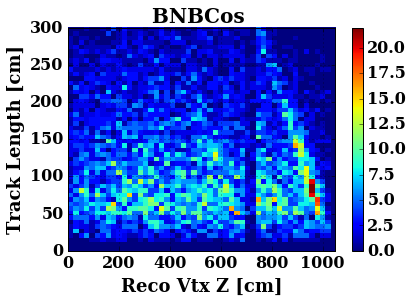

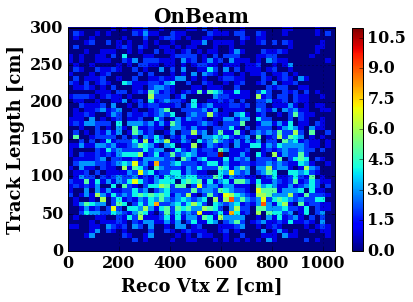

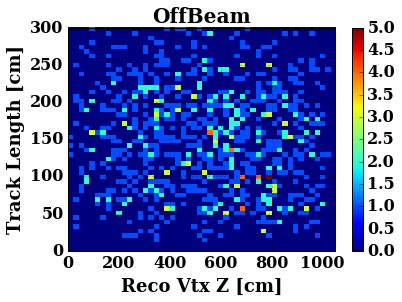

In [21]:
plt.figure()
_ = plt.hist2d(df_bnbcos.reco_vtx_z.values,df_bnbcos.len.values,bins=50,\
               range=[(0,1050),(0,300)])#,norm=LogNorm())
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.ylabel('Track Length [cm]',fontsize=18,weight='bold')
plt.title('BNBCos ',fontsize=20,weight='bold')
plt.xlabel('Reco Vtx Z [cm]',fontsize=18,weight='bold')
plt.colorbar()
#plt.axvline(900,color='r',lw=2)

plt.figure()
_ = plt.hist2d(df_onbeam.reco_vtx_z.values,df_onbeam.len.values,bins=50,\
               range=[(0,1050),(0,300)])#,norm=LogNorm())
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.ylabel('Track Length [cm]',fontsize=18,weight='bold')
plt.title('OnBeam',fontsize=20,weight='bold')
plt.xlabel('Reco Vtx Z [cm]',fontsize=18,weight='bold')
plt.colorbar()
#plt.axvline(900,color='r',lw=2)


plt.figure()
_ = plt.hist2d(df_offbeam.reco_vtx_z.values,df_offbeam.len.values,bins=50,\
               range=[(0,1050),(0,300)])#,norm=LogNorm())
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.ylabel('Track Length [cm]',fontsize=18,weight='bold')
plt.title('OffBeam',fontsize=20,weight='bold')
plt.xlabel('Reco Vtx Z [cm]',fontsize=18,weight='bold')
plt.colorbar()

#df_bnbcos.head()